# ⚽ 2026 World Cup Readiness Framework - Exploratory Data Analysis

**Team:** XOH - SOOMI OH, YOO MI OH

**Date:** February 2026  

**For Executive Summary:** See `EDA_Executive.ipynb`

## Overview 
The 2026 FIFA World Cup, co-hosted across the United States, Canada, and Mexico, represents the largest edition of the tournament in history — 48 nations, three confederations of host advantage, and a genuinely open competitive landscape for the first time since the format expanded.

This report presents a data-driven framework for **quantifying national team readiness** ahead of that tournament. The central argument is simple: predicting World Cup performance requires more than ranking teams by FIFA rating or recent results. It requires understanding three distinct but interconnected questions simultaneously; who are the players, what kind of team do they form, and what contextual factors shape their tournament prospects.

To answer these questions, we built a **three-layer** analytical system grounded in StatsBomb open data. Tournament-level team data from the 2022 and 2024 provides the tactical foundation - eight dimensions of collective behaviour that reveal **how teams actually play,** not how they are perceived to play. Player-level performance data spanning 2021 to 2025 across all competitions provides the **individual quality layer** — 10 metrics covering finishing, ball progression, attacking contribution, defensive output and pressing quality, time-decay weighted to prioritise recent form. These two independent evidence streams are **synthesised** into a single **Readiness Score** per national team, adjusted for managerial stability, club cohesion, host advantage, confederation travel factors, and tactical archetype historical success rates.

**The result is not a prediction.** It is a structured, auditable, reality-grounded assessment of which squads are **best positioned to compete** and why.

## I. Data Architecture & Sources
### 1.1 The Raw Material

We use the **StatsBomb Open Data** dataset, accessed via the official template repository scripts:

| Dataset | Format | Description |
|---|---|---|
| Matches | Parquet/CSV | Match metadata: competition, season, teams, score, date |
| Events | Parquet/CSV | 12.2M event-level rows: passes, shots, pressures, carries, etc. |
| Lineups | Parquet/CSV | Player-match lineups with positions |
| 360° Frames | Parquet/CSV | Freeze-frame tracking (for select matches only) |

Data is downloaded by running `download_data.py` per the root `README.md`, then read locally from `data/Statsbomb/`.

In [23]:
# Import eda template functions
%config InlineBackend.figure_format = 'retina'
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

import sys
import importlib
sys.path.append(str(Path('..').resolve()))

from templates.eda_starter_template import (
    safe_run,
    analyze_sb_360,
    analyze_sb_lineups_adv,
    analyze_sb_reference_adv
)

# Import custom functions
from analysis.eda_functions import (
    overall_summary_table,
    plot_event_type_distribution,
    plot_360_coverage_analysis,
    plot_matches_market_overview,
    plot_tactical_evolution_basics,
    plot_360_player_heatmap,
    plot_player_versatility_gradient
    
)

from analysis.data_loader import (
    load_tournament_data_8d, 
    load_player_data_for_scoring
)

from analysis.team_metrics_eda import (
    plot_metric_distributions,
    plot_correlation_matrix,
    plot_tactical_scatter,
    plot_outcome_by_quadrant,
    plot_competition_radar,
    plot_tactical_consistency_scatter,
    
)

from analysis.player_metrics_eda import (
    load_all_players,
    plot_row_counts,
    #plot_coverage_heatmap,
    plot_metric_distributions_pl,
    plot_minutes_distribution,
    plot_player_archetype_scatter,
    plot_quality_minutes_scatter,
    plot_player_trajectory,
    plot_player_consistency
)
STATSBOMB_DIR = Path("..") / "data" / "Statsbomb"
overall_summary_table(STATSBOMB_DIR);

KeyboardInterrupt: 

### 1.2 Match Data: Competition Coverage & Temporal Scope

#### Dataset at a Glance
- **3,464 matches** across 21 competitions
- **Temporal:** 
    - 54% concentrated in 2015-2016 (1,860 matches)
    - Pre-2015: 425 scattered matches
    - Post-2016: 1,179 matches over 8 years.
- **Competitions:** La Liga 25%, Ligue 1 13%, Premier League 12%, Serie A 11%, Bundesliga 10%, Women's football 9.4%.
- **Outcomes:** 
    - 45.2% home wins, 23.0% draws
    - 31.8% away wins. 2.85 goals/match average.
- **Quality:** No duplicate IDs. Missing data limited to non-essential fields.

Saved: figures/matches_overview.png


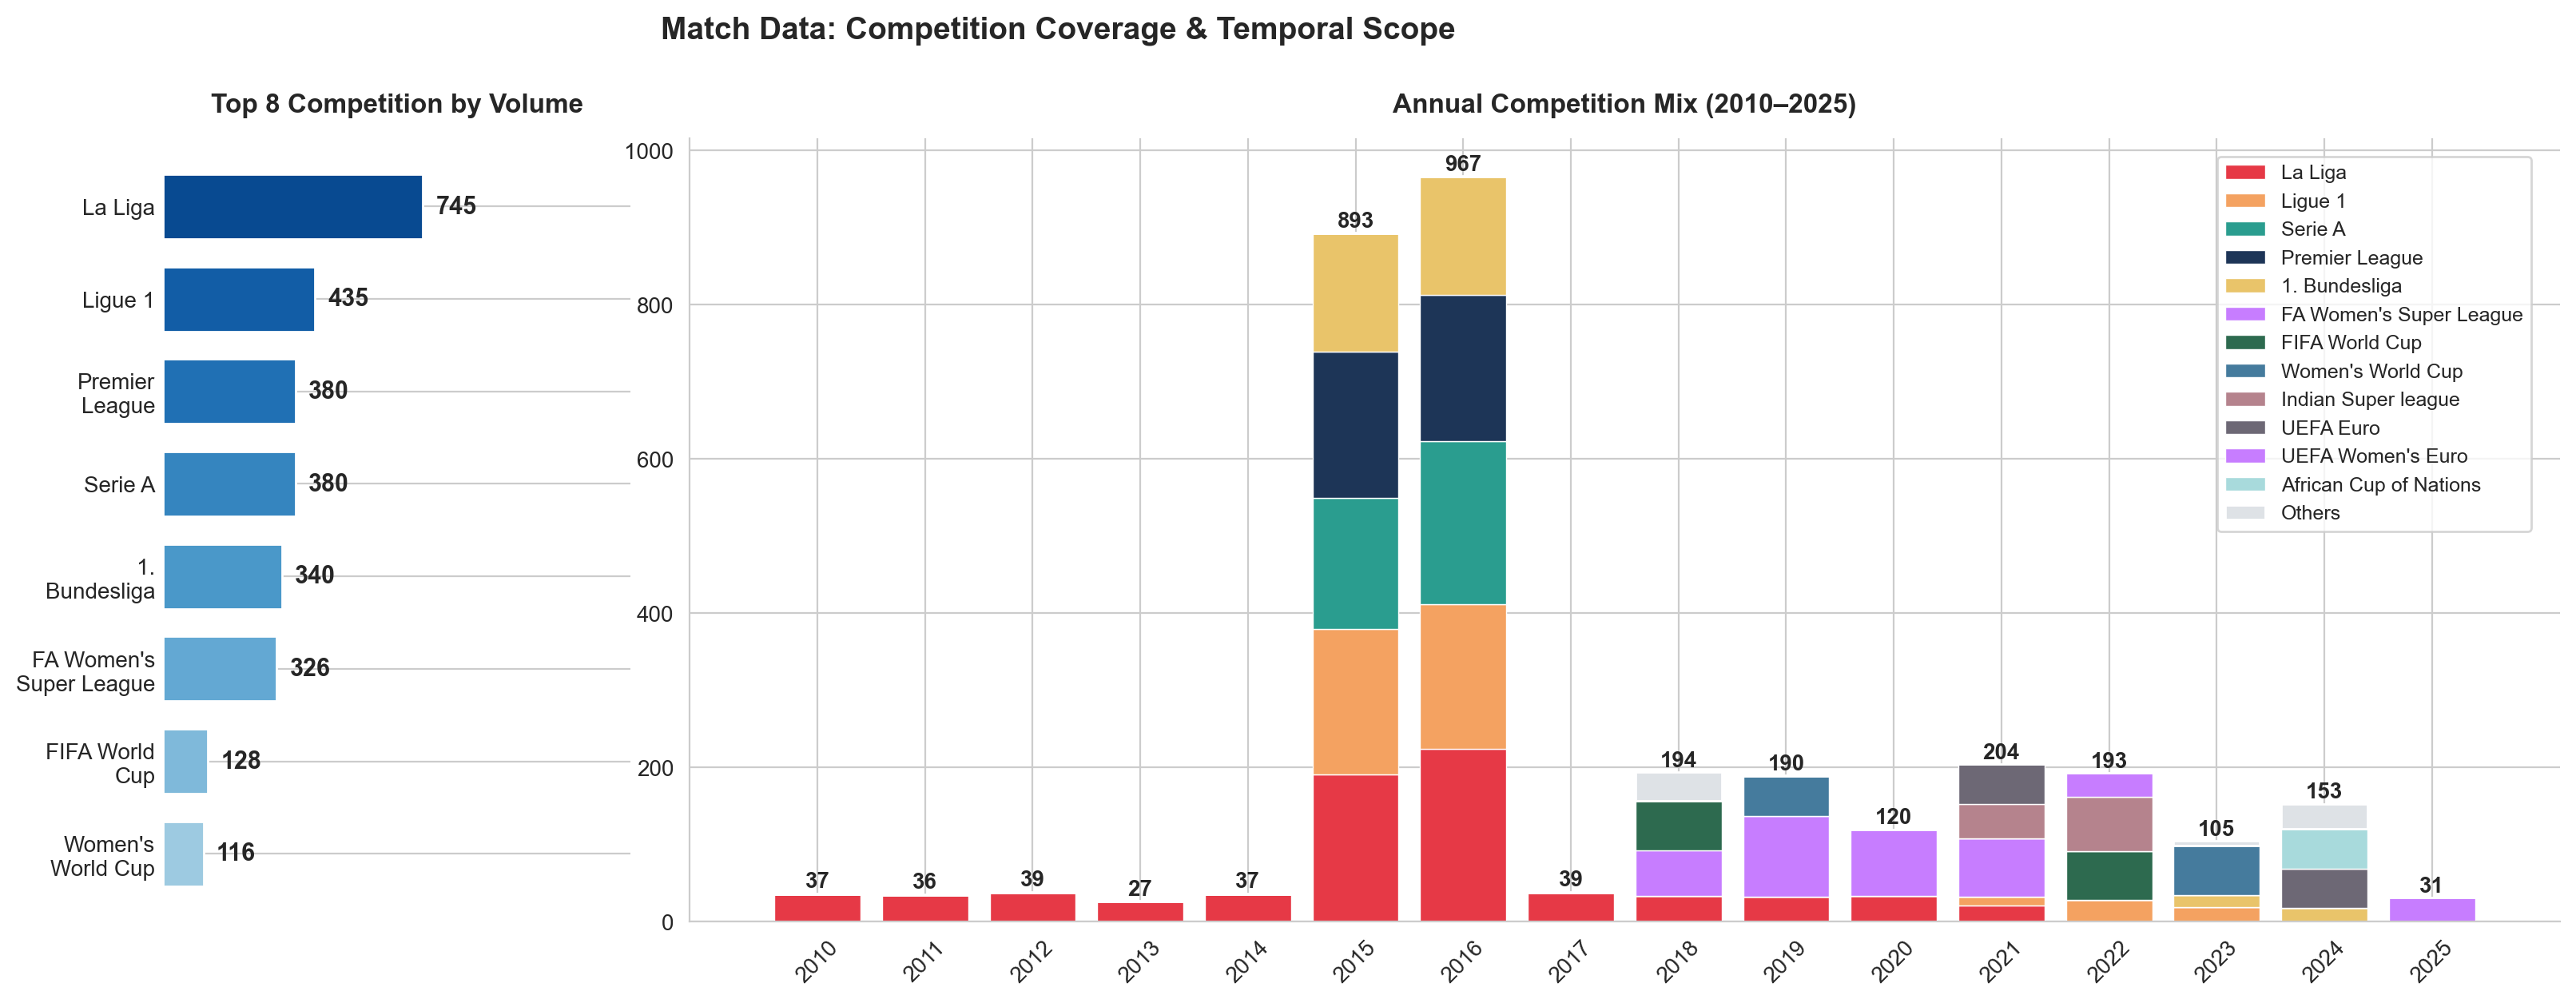

In [ ]:
plot_matches_market_overview(STATSBOMB_DIR)

#### Temporal Distribution & The Case for Recency

The longitudinal dataset exhibits a significant **sampling bias;** specifically, the 2015/16 window accounts for over 50% of the total club match records. This "StatsBomb Legacy Spike" (peaking at 967 matches in 2016) is a byproduct of historical data availability rather than a genuine evolution in match volume. Integrating this era creates two primary risks for a 2026 predictive model:
- **Tactical "Monoculture":** With 748 matches originating from a specific La Liga era, the model risks over-indexing on high-volume, low-tempo possession metrics.
- **Regime Decay:** The physical and tactical intensity of the current game (measured by PPDA and high-turnover rates) has rendered 2015-era benchmarks obsolete.

To maintain a model that is tactically "current," we restrict our training data to the post-2021 cycle. This five-season window (2021-2025) provides the necessary volume to filter out variance-driven outliers (single-season "purple patches") while ensuring the model is not anchored to the lower-intensity metabolic rates of the mid-2010s. 

For team archetypes, we prioritize a "Tournament-First" weighting, specifically indexing against the 2022 World Cup, Euro 2024, and Copa América 2024. This choice is vital because international tournaments now act as the primary "meta-shifters" for global tactics:
- **Euro 2024 vs. Copa América 2024:** Our approach accounts for the divergence between the high-possession, "controlled" sequences of European sides and the direct, high-transition profiles dominant in the Americas.
- **The "Relational" Shift:** We move away from rigid positional grids to capture the rise of "Organized Unpredictability" — fluid micro-structures where player functions supersede fixed positions.

The tradeoff is a deliberate move toward **recency over quantity.** By prioritizing the most recent 60 months of elite competition, we ensure our predictive outputs reflect the "8-second transition" era rather than a bygone era of stagnant possession.

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 1.3 Event Data: The Pulse of the Game

#### Dataset at a Glance
- **12,188,949 events** across 3,464 matches
- **Distribution:** Pass 27.8%, Ball Receipt 26.0%, Carry 21.6%, Pressure 9.1%, Shot 0.7%
- **Barcelona bias:** 10.2% of all events. Top 10 players all Barcelona 2010s (Messi, Busquets, Xavi, Iniesta).
- **Shot quality:** 
    - 9,383 total xG across 88,023 shots (0.107 avg)
    - Only 8.1% qualify as big chances (xG > 0.3)
    - Median 0.055 suggests many speculative efforts.
- **Passes:** 77.7% completion rate
- **Temporal:** 50.4% first half, 49.2% second half
- **Quality:** No duplicate IDs. 99.25% have location data. 20.9% under pressure.

Saved: figures/event_type_dis.png


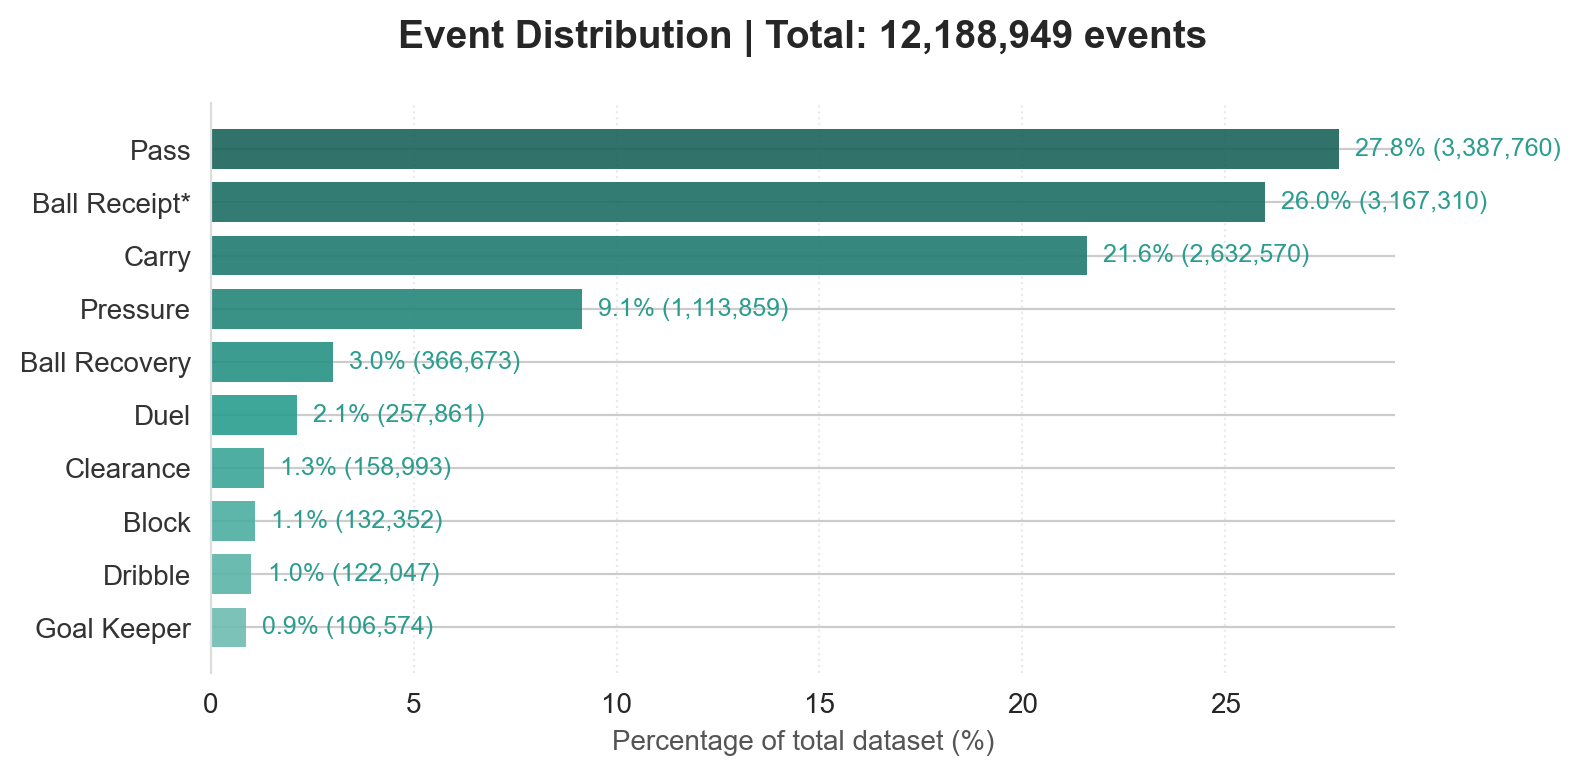

In [ ]:
import analysis.eda_functions
importlib.reload(analysis.eda_functions)
from analysis.eda_functions  import * 
plot_event_type_distribution(STATSBOMB_DIR)

#### Event-Stream Granularity & Tactical Intent

The core of our model is built on a high-fidelity event stream comprising **12.2M discrete actions across 3,464 matches,** averaging **~3,519 events per game.** Unlike synchronous tracking data (GPS), which merely charts spatial coordinates, this event-based architecture captures **player agency** and tactical decision-making.

By indexing 35 unique event types, we have moved beyond "where" a player is to "why" they are there. The data distribution is heavily weighted toward high-leverage actions:
- **Progression & Possession (49.4%):** A massive sample of Passes (27.8%) and Carries (21.6%) allows for nuanced profiling of build-up phases and zone-to-zone transitions.
- **Defensive Intensity (12%):** With Pressures (9.1%) as a core metric, the model can quantify defensive "proactivity". It captures the "DNA" of modern high-pressing systems that tracking data often obscures.

This "action-rich" approach ensures the model isn't just descriptive of physical output but is **tactically diagnostic.** It allows us to map the functional "connective tissue" of a team — measuring how verticality and ball-retention strategies manifest in high-pressure game states.

Saved: figures/tactical_evolution.png


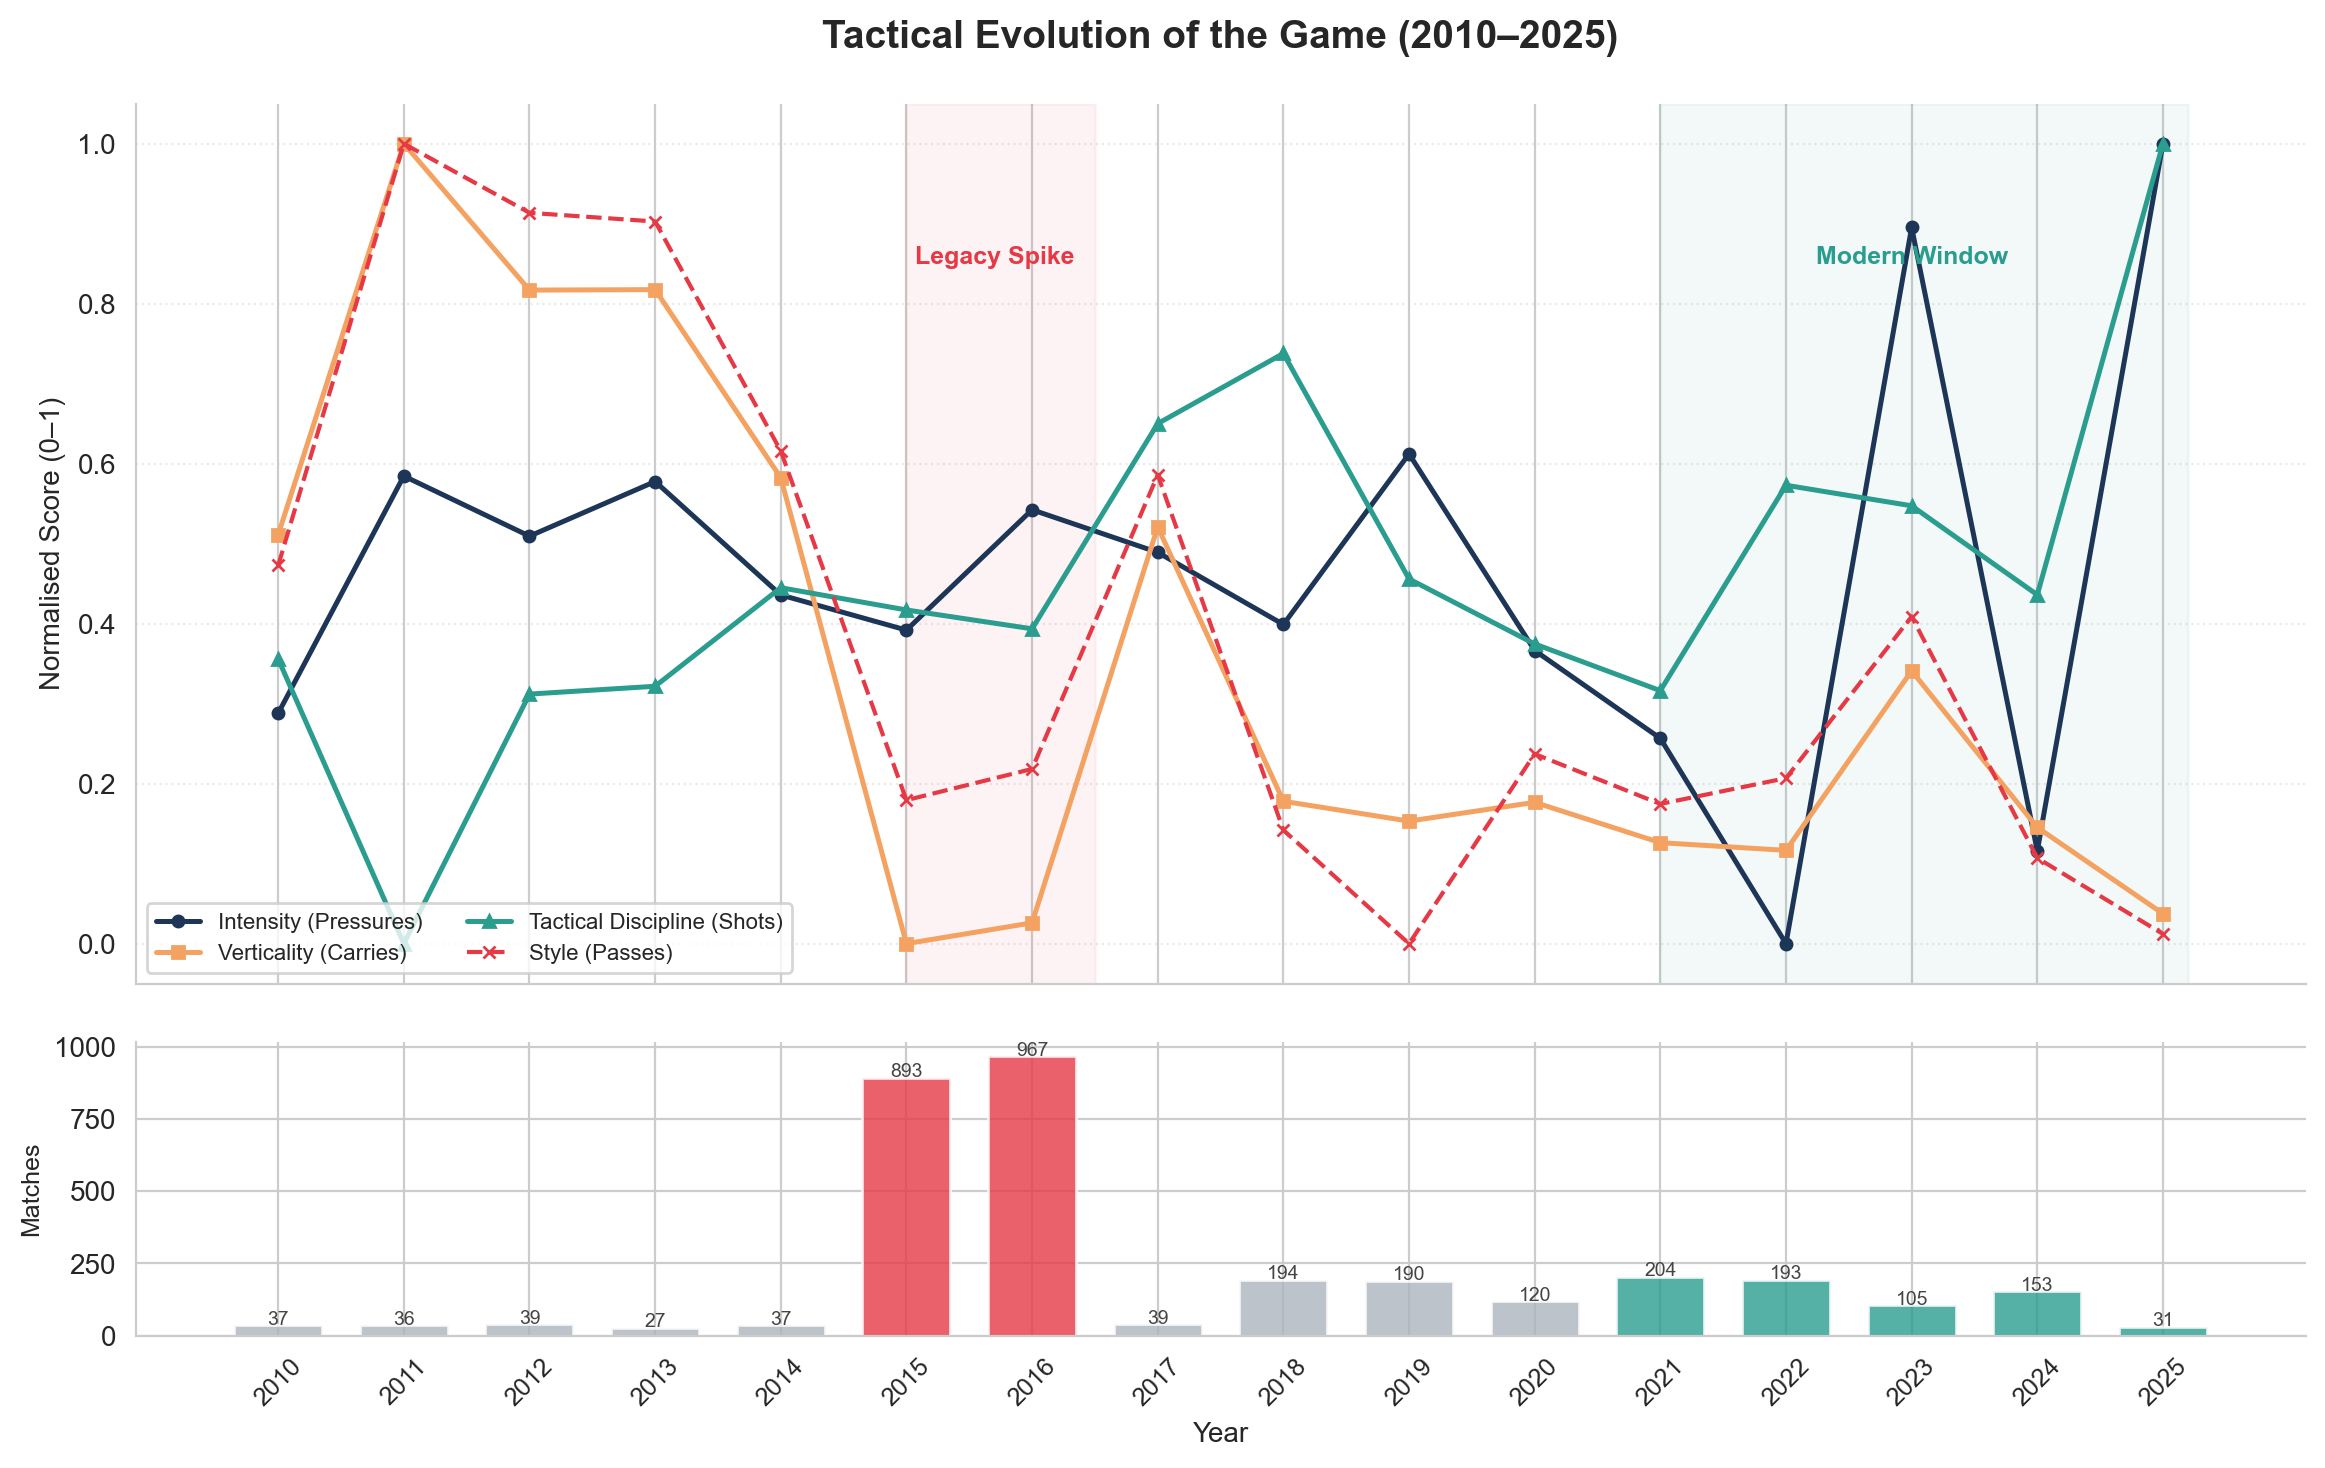

In [ ]:
plot_tactical_evolution_basics(STATSBOMB_DIR)

#### The Tactical Inflection: Navigating the "Sparsity Canyon"
The Tactical Evolution (2010-2025) chart is a tale of two distinct data regimes separated by a period of significant sample sparsity. Understanding this longitudinal landscape is critical for validating our 2026 predictive weights.

**1.** **The Legacy Spike (2015-2016): The Volume Artifact**

The red-shaded era represents a historical peak in match volume (~1,800 matches), primarily driven by early industry data releases.
- **Tactical Monoculture:** This period is defined by a high correlation between Style (Passes) and Verticality (Carries), reflecting the dominant "possession-first" philosophy of the mid-2010s.
- **Dated Benchmarks:** While volume is high, the "metabolic rate", the intensity of pressing and transition, is significantly lower than modern standards, making it an unreliable baseline for 2026 forecasting.

**2.** **The 2017-2020 "Sparsity Canyon"**

Following the 2016 peak, the dataset enters a period of extreme slimness.
- **The "Data Gap":** With match counts dropping as low as 39 in 2017 and 120 in 2020, the trend lines in this middle section exhibit high "noise."
- **Methodological Pivot:** Rather than attempting to interpolate through this sparse data, we treat this gap as a Hard Tactical Break. It serves as the "border" that justifies our decision to ignore legacy patterns in favor of the modern era.

**3.** **The Modern Meta (2021-2025): Tournament-Driven Signals**

Post-2021, the data volume recovers, but the Compositional Profile shifts. Unlike the league-heavy 2015 era, this window is weighted toward international tournaments. 
- **The 2023 "Intensity" Spike:** This 0.9 peak is a direct byproduct of the 2023 Women’s World Cup. It captures the frantic, high-transition "Knockout Metabolism" that defines tournament football.
- **The 2024 "Rest-Defense" Correction:** The dip in 2024 reflects the structural discipline of Euro 2024, where elite sides prioritized positional control over raw pressure volume.

By identifying the Legacy Spike as a "bygone era" and recognizing the 2017-2020 gap as a loss of statistical signal, we are left with a clear mandate: **the 2021-2025 window is the only valid blueprint for 2026.** We are trading the "comfort" of 2015's raw volume for the "accuracy" of the current tournament-heavy high-intensity meta.

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 1.4 Lineup Data: Who Was on the Pitch
#### Dataset at a Glance
- **165,820 entries** across 3,464 matches with 10,808 unique players identified.
- **Participation:** 58.3% of the recorded lineup entries actually saw game time (96,698 players/instances).
- **Substitutions:** 5.9 avg per match. Starters averaged 84.7 min, while substitutes averaged 21.5 min of playing time.
- **Playing Time:** 55.8% played 90+ min, 18.5% played 60-90 min, 9.0% played 30-60 min, and 16.7% played under 30 min.
- **Cards:** 19,606 total cards (11.8% of records). 96.5% were Yellow Cards. Sergio Busquets leads the disciplinary table with 130 cards.
- **Quality:** 60,491 duplicate (match_id, player_id) pairs detected (36.5%), representing significant tactical flexibility and position changes during matches.

In [ ]:
lineups_results = safe_run(analyze_sb_lineups_adv, "lineups")


  STATSBOMB: LINEUPS
Records: 165,820 | Matches: 3,464 | Unique Players: 10,808
Quality: 60,491 duplicate (match_id, player_id) pairs (36.5%), likely position changes.
Participation: Only 58.3% actually played (96,698).
Substitutions: 5.9 avg per match. Starters 84.7 min avg, subs 21.5 min avg.

--- Position Distribution ---
shape: (10, 2)
┌───────────────────────┬───────┐
│ position_name         ┆ count │
│ ---                   ┆ ---   │
│ str                   ┆ u32   │
╞═══════════════════════╪═══════╡
│ null                  ┆ 34179 │
│ Center Forward        ┆ 9325  │
│ Right Center Back     ┆ 9021  │
│ Left Center Back      ┆ 8888  │
│ Right Wing            ┆ 8780  │
│ Left Wing             ┆ 8653  │
│ Right Back            ┆ 8431  │
│ Left Back             ┆ 8103  │
│ Goalkeeper            ┆ 7029  │
│ Right Center Midfield ┆ 6872  │
└───────────────────────┴───────┘

--- Playing Time Distribution ---
shape: (4, 2)
┌───────────┬───────┐
│ bin       ┆ count │
│ ---       ┆ ---   

#### The Functional Player Profile 
The lineup dataset, comprising 165,820 entries across 10,808 unique players, provides the vital human context to our event stream. However, raw participation data is notoriously noisy; to build a robust 2026 Readiness Score, we must distinguish between "squad fillers" and "system anchors."

**1. The "Super-Sub" Trap: Normalizing for Metabolic Load**

Our analysis reveals a significant disparity in "mileage": Starters average 84.7 minutes, whereas substitutes average just 21.5 minutes.
- **The Per-90 Distortion:** Evaluating subs on a pure "Per-90" basis creates an artificial performance ceiling (the "Super-Sub Bias"). A 10-minute cameo against a tired defense can produce "elite" metrics that are physically unsustainable over a full 90-minute shift.
- **The 270-Minute Threshold:** To ensure our 2026 projections are grounded in physical reality, we should implement a minimum volume threshold of 270 minutes (three full-match equivalents). This filters for "Foundation Players" — those with the aerobic capacity and tactical consistency to survive the grueling 48-team tournament format.

**2. Disciplinary Profiling & Availability**

With 19,606 cards recorded (11.8% of entries), the dataset offers a high-resolution look at disciplinary risk.
- **The Busquets Benchmark:** Sergio Busquets’ 130 cards serve as a baseline for "Tactical Cynicism", the ability to disrupt transitions without necessarily being "unproductive."
- **Availability Forecasting:** For 2026, the model should incorporate these disciplinary trends to project Suspension Risks, a critical factor in the condensed schedule of a World Cup.

**3. The "Position Paradox": Quantifying Tactical Plasticity**

A technical audit detected 60,491 duplicate player-match pairs (36.5%). While technically redundant, these entries are a vital proxy for Tactical Plasticity.
- **The "Shape-Shifter" Effect:** This duplication represents mid-game structural shifts (e.g., a winger dropping to wing-back or a #10 moving to a "false nine").
- **Minutes-Weighted Classification:** To resolve the "Position Paradox," the model can utilize a Minutes-Weighted Primary Position. By indexing a player’s coordinates against their time-on-pitch, we classify them by their primary functional role rather than emergency tactical adjustments.

Saved: figures/profile_evol_example.png


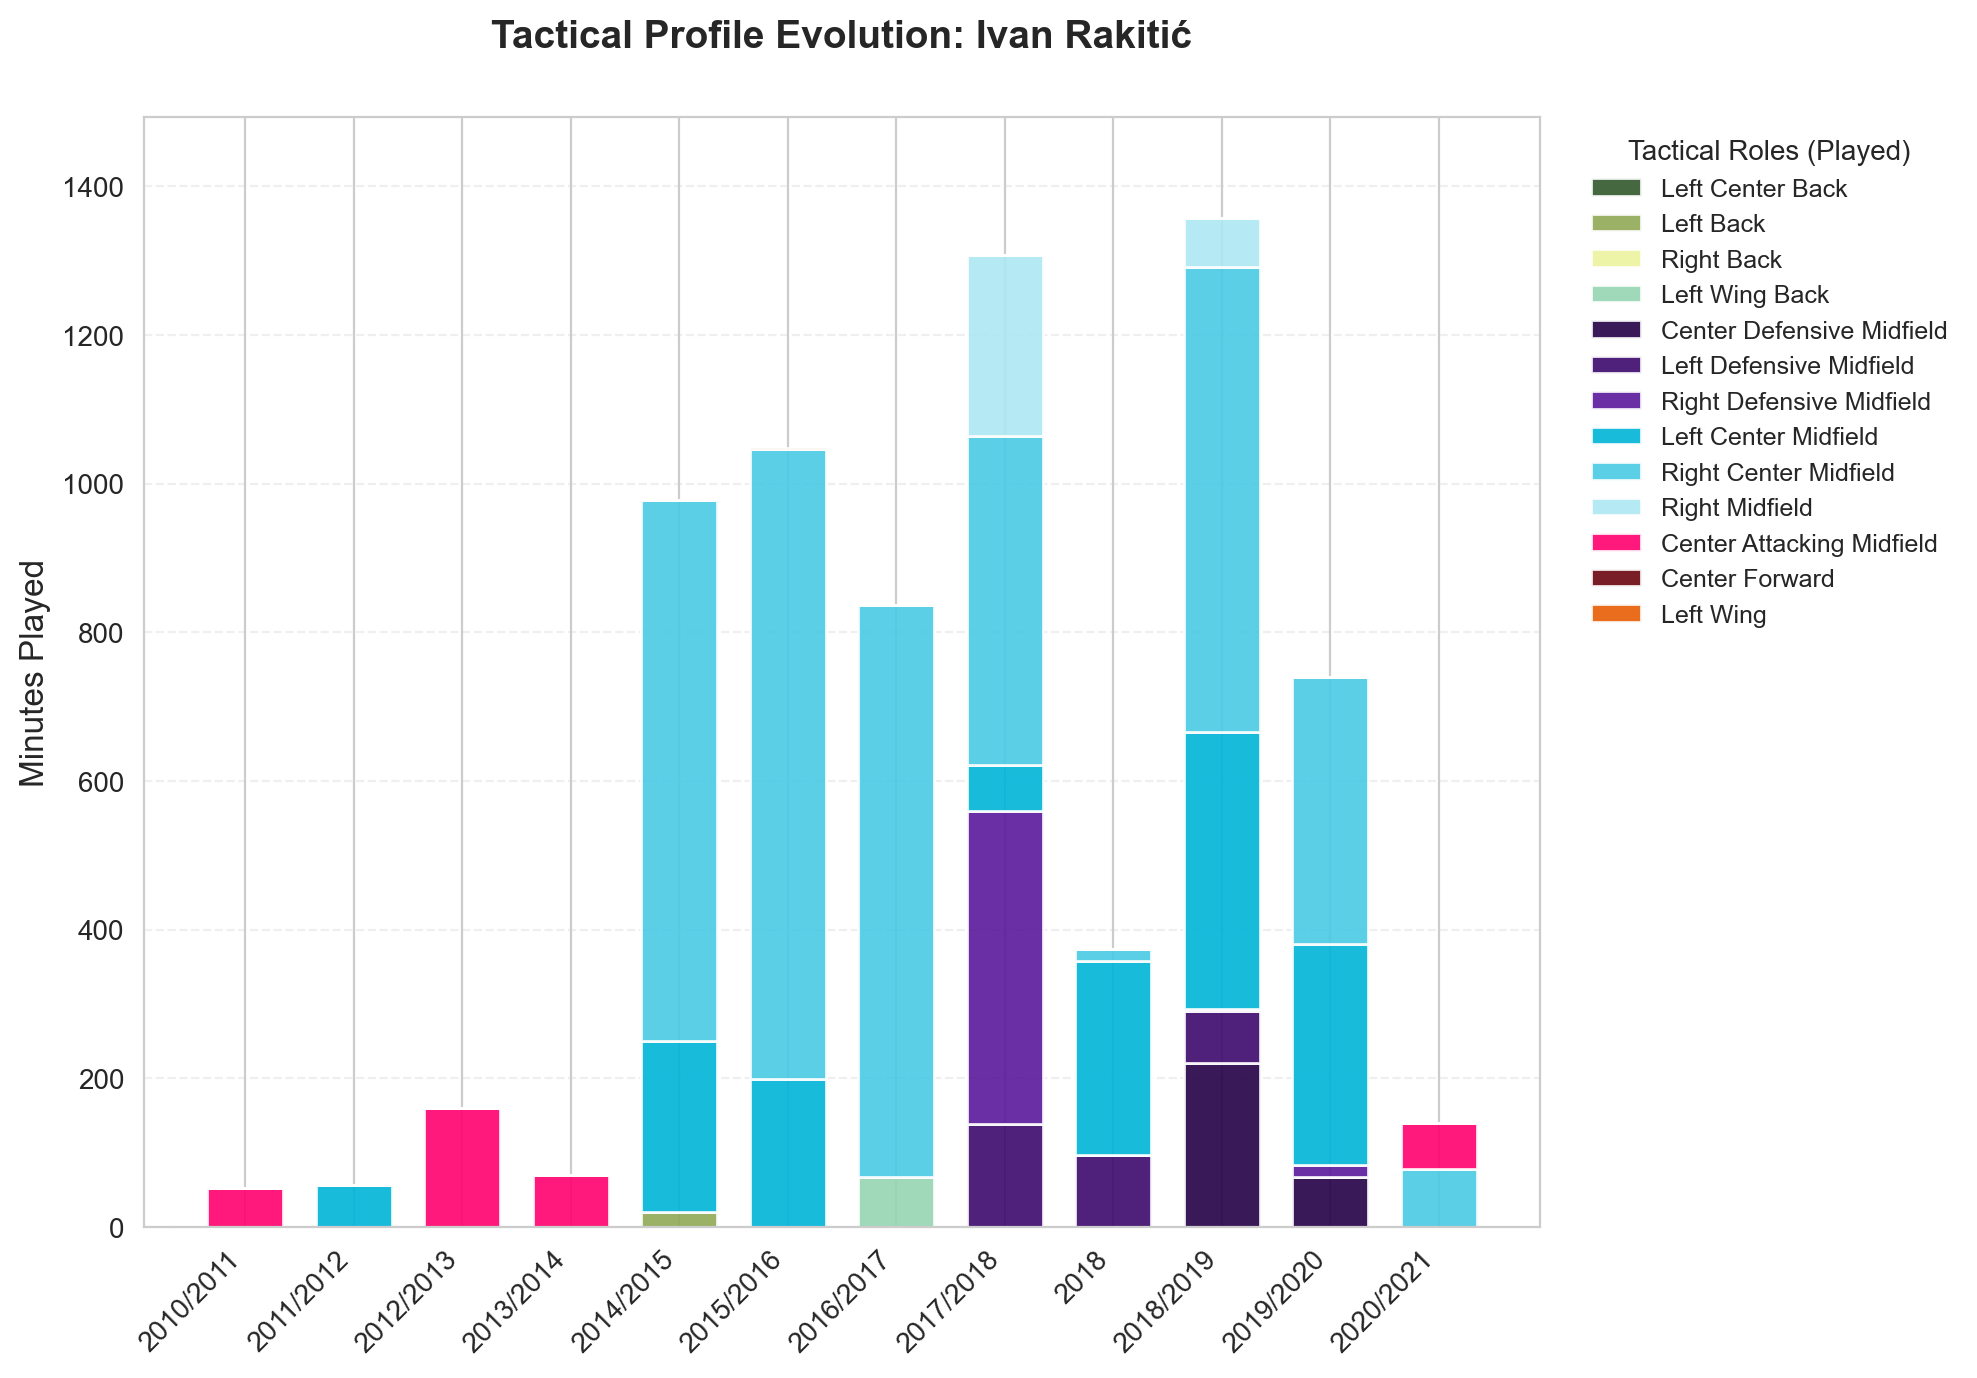

In [ ]:
plot_player_versatility_gradient(STATSBOMB_DIR, "Ivan Rakitić")

#### Case Study: Ivan Rakitić & The "Flow Operator" Model
Ivan Rakitić serves as the definitive archetype for Structural Displacement. His career data provides a high-resolution map of Tactical Plasticity, specifically his ability to oscillate between the Center Midfield (CM) and Center Defensive Midfield (CDM) tiers without a drop in technical efficiency.

**1. From Creative Fulcrum to "Structural Insurance"**

In his transition from Sevilla to Barcelona, Rakitić’s data reveals a calculated shift in Functional Weighting. While his technical baseline remained elite, his heatmap and event density migrated into deeper pockets to facilitate Rest-Defense.
- **The "Oxygen" Role:** By dropping into CDM tiers, he acted as a structural insurance policy, stabilizing the defensive block while high-risk creative assets pushed into the final third.
- **Equilibrium Management:** His "world-class" status is a byproduct of this hybridity—the ability to maintain elite Pass Completion Under Pressure while shifting between two distinct tactical worlds.

**2. The 2018 World Cup: Masterclass in "Downshifting"**

The 2018 World Cup semi-final against England remains the gold standard for In-Game Re-Tasking. Despite significant physical duress (playing with a fever), Rakitić performed a tactical "Downshift":
- **Phase 1 (The Trigger):** He began as a press-triggering CM, disrupting England’s initial build-up.
- **Phase 2 (The Anchor):** As the match progressed, he pivoted into a CDM role, nullifying central access and dictating the tempo to manage his own Metabolic Preservation.

**3. Implications for the 2026 Blueprint: The "Flow Operator"**

For a 2026 manager facing an expanded 48-team schedule and unprecedented travel fatigue, the "Rakitić Profile" is the primary target for recruitment.
- **Bridging Tactical Families:** Success in a condensed tournament requires "Flow Operators" — players who can bridge multiple tactical families and sustain the team’s shape when the "physical tank" is depleted.
- **Versatility over Specialization:** In our Readiness Score, high marks are awarded to this specific plasticity. The most valuable assets for 2026 are not specialists, but those who can adapt their functional role to preserve the team’s collective equilibrium.

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 1.5 360° Frame Data: From Event-Streams to Spatial Intelligence

#### Dataset at a Glance
- **15,584,040 frames**
- **Coverage:** Only 9.3% of matches (323/3,464)
- **Competitions:** Tournament-focused. UEFA Euro 100%, Women's Euro 95%, but only 10% Bundesliga. No La Liga/PL/Serie A coverage.
- **Temporal:** All 2020-2025, zero overlap with dense 2015-2016 period.
- **Frames:** 50% teammate, 6.6% actor, 2.3% keeper. All have location + visible area polygons.

While standard event data tells us what happened to the ball, StatsBomb 360° provides the essential "camera-frame" context of every player involved in the sequence. With 15.5 million spatial records, this dataset allows us to quantify the "hidden" game: defensive compactness, passing lanes, and line-breaking geometry that traditional logs fail to capture.


  STATSBOMB: THREE SIXTY
Records: 15,584,040 | Events: 1,027,908 | Matches: 323

--- Spatial Distribution ---
X coords:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 1.558404e7 │
│ null_count ┆ 0.0        │
│ mean       ┆ 64.148598  │
│ std        ┆ 27.882666  │
│ min        ┆ -8.284931  │
│ 25%        ┆ 43.537132  │
│ 50%        ┆ 65.792419  │
│ 75%        ┆ 86.308243  │
│ max        ┆ 129.422791 │
└────────────┴────────────┘

Y coords:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 1.558404e7 │
│ null_count ┆ 0.0        │
│ mean       ┆ 40.017899  │
│ std        ┆ 18.380463  │
│ min        ┆ -36.000988 │
│ 25%        ┆ 26.842133  │
│ 50%        ┆ 40.025101  │
│ 75%        ┆ 53.186447  │
│ max        ┆ 117.531555 │
└────────────┴────────────┘


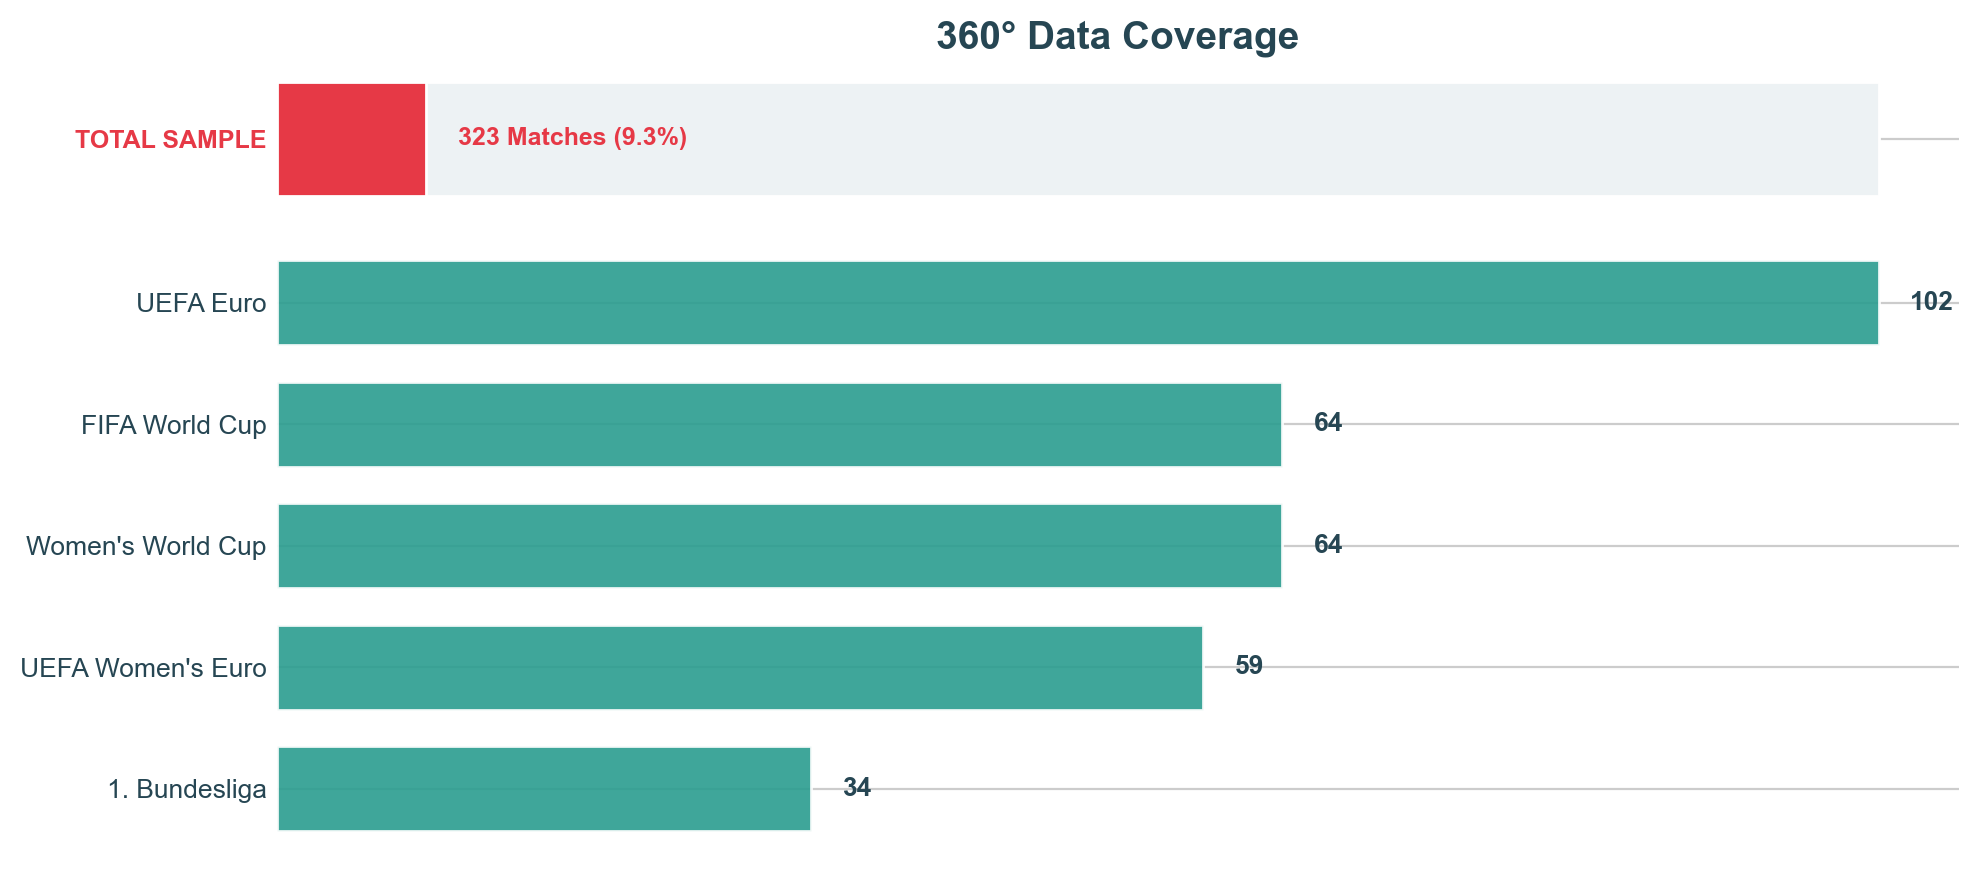

In [ ]:
threesixty_results = safe_run(analyze_sb_360, "three_sixty")
plot_360_coverage_analysis(STATSBOMB_DIR)

#### Strategic Constraints: The Quality vs. Quantity Trade-off
We explicitly recognize the **9.3% match coverage** (323/3,464 matches) as a structural boundary of the study. Because 360° data is exclusively tournament-focused and absent from the historical 2015-2016 "Legacy Spike," we do not attempt to interpolate or infer spatial patterns across the broader dataset. Instead, we treat 360° data as a Standalone Validation Set.
- **Modern Gold Standard:** This data serves as the "Tactical North Star" for 2026. It provides a high-fidelity look at the Modern Meta, specifically how elite international teams (Euro 2024, World Cup 2022) manage space creation and defensive recovery shadows.
- **Zero-Overlap Integrity:** By keeping the 360° analysis separate from the longitudinal event data, we avoid "polluting" our 2026 projections with spatial assumptions from the 2015 "tiki-taka" era.
- **Line-Break Calibration:** We use this sub-sample to define the mathematical threshold for what constitutes a "Line-Breaking Pass" in the modern game. This allows us to categorize modern player performance with a level of Spatial Accuracy that event data alone cannot provide.

In short, the 360° data isn't used to "fill gaps" — it’s used to define the standard. It tells us exactly what the highest level of football looks like today, providing a focused, high-resolution lens for our 2026 "Readiness" evaluations.

Visualizing match ID: 3795108
Tracking points: 80,650
Saved: figures/360_heatmap.png
Saved: figures/360_heatmap.png


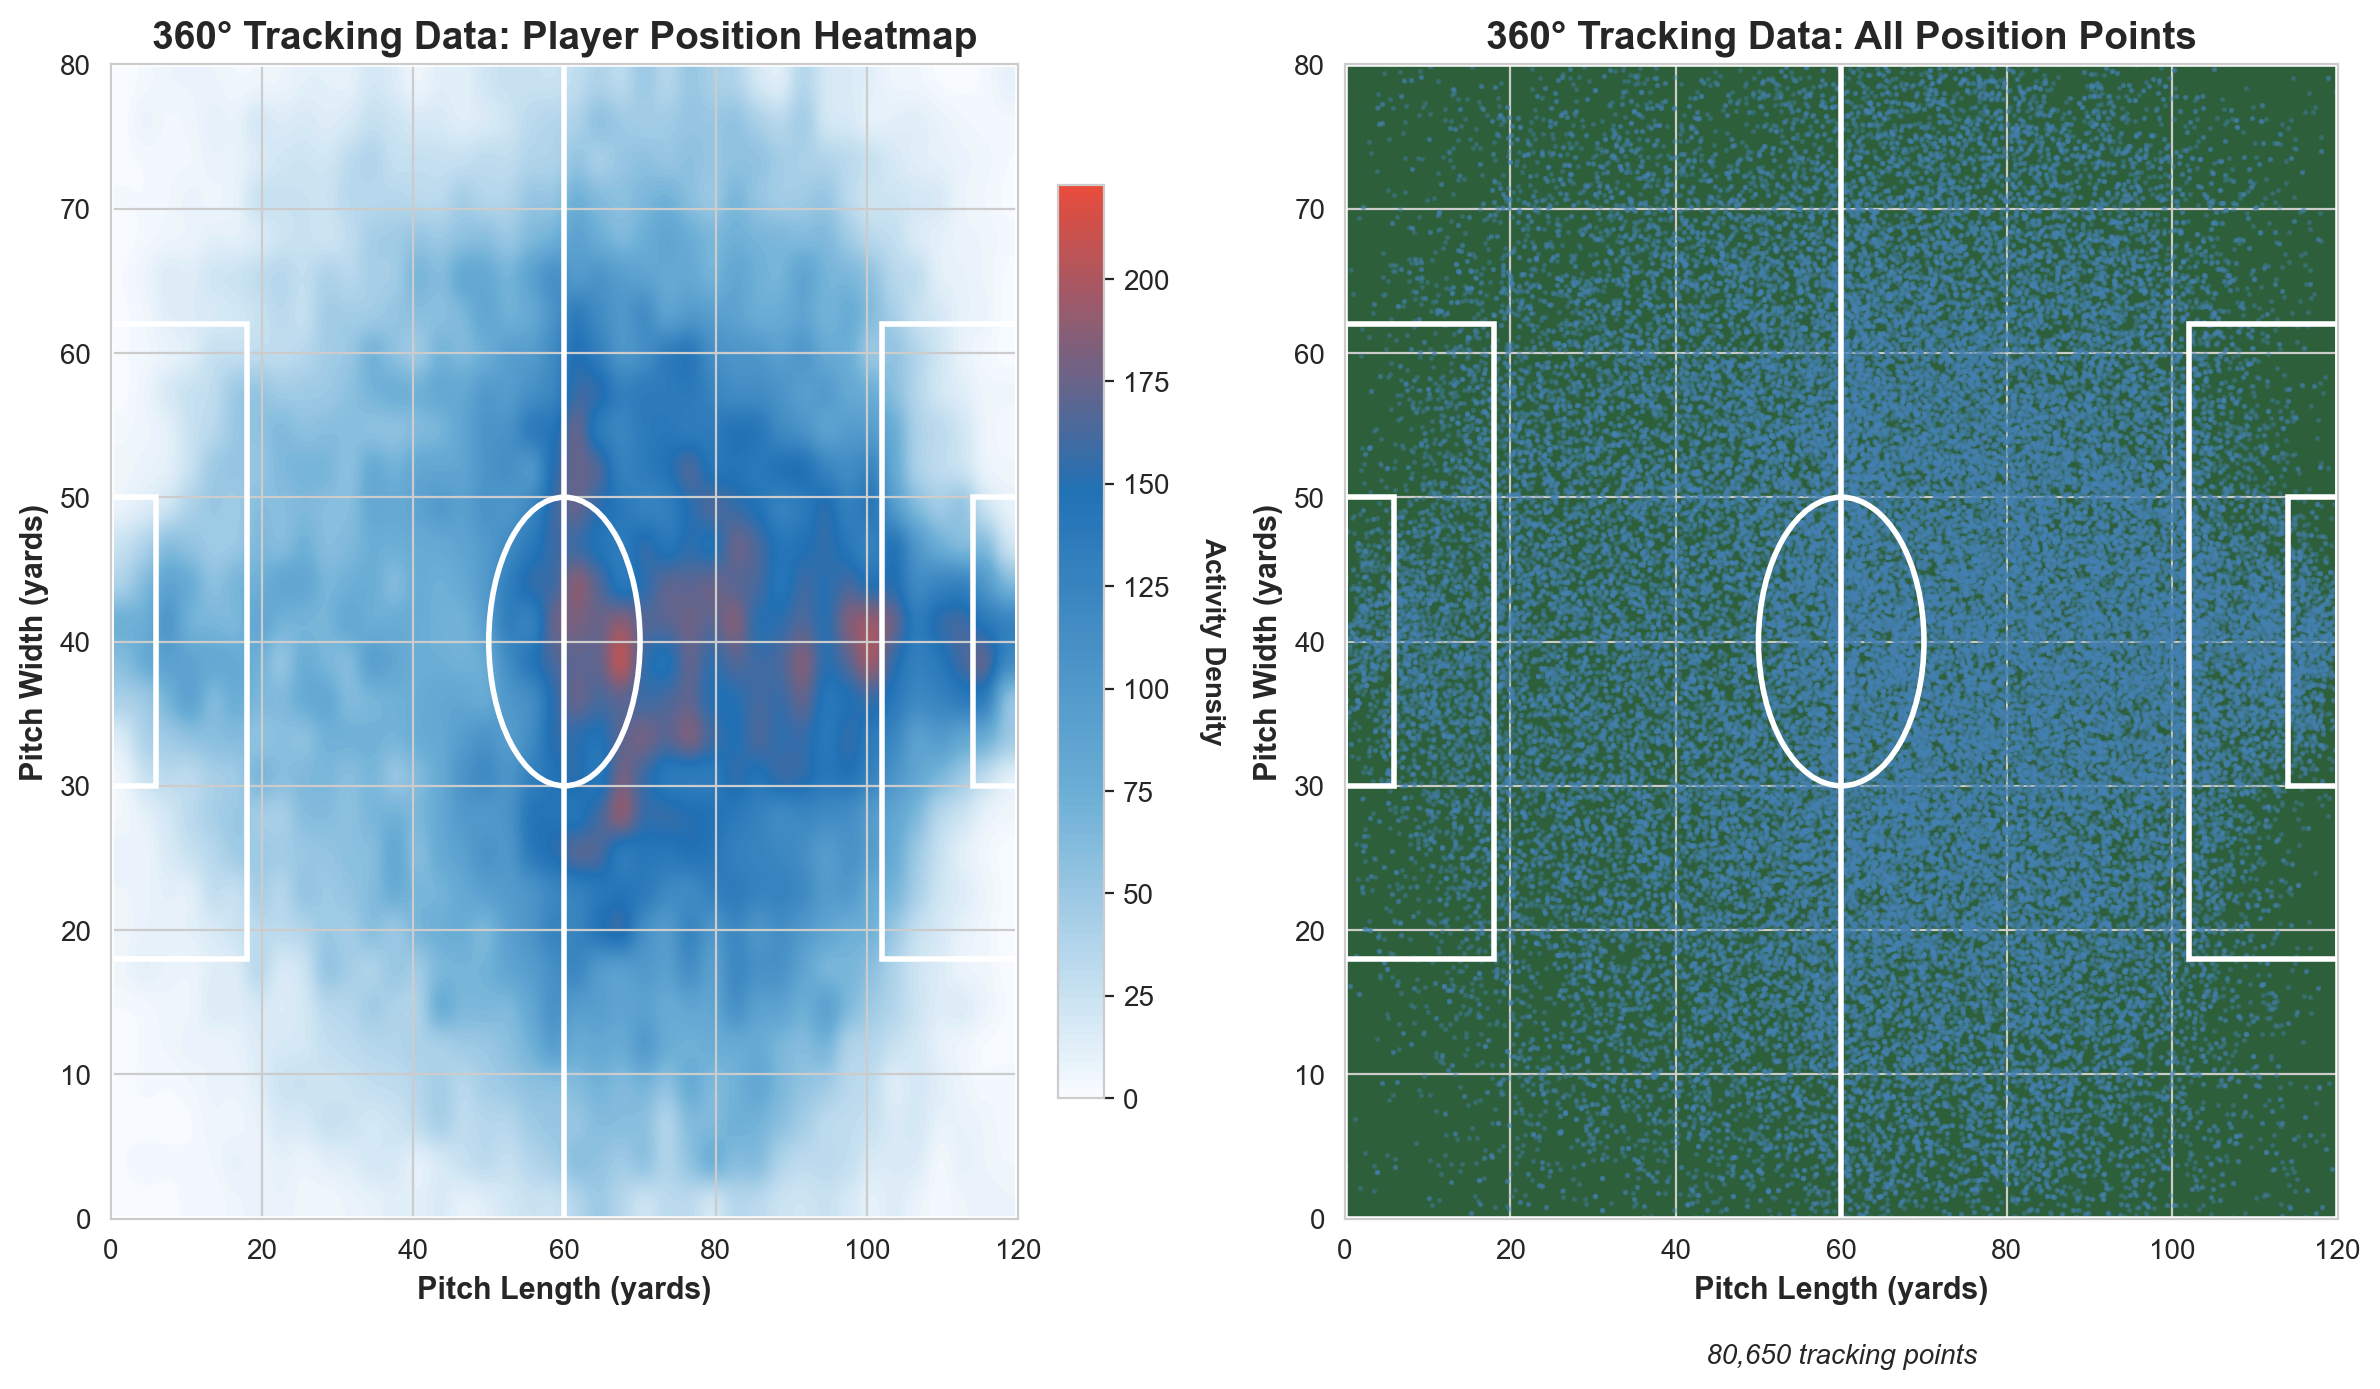

In [ ]:
plot_360_player_heatmap(STATSBOMB_DIR)

#### What the 360° Data Shows
While traditional event logs provide a linear narrative of a match, StatsBomb 360° data offers a volumetric map of the tactical landscape. To define our "Modern Gold Standard," we isolated the Euro 2020 clash between Switzerland and Spain — a match representing the peak of positional play and defensive organization within our dataset.

**1. The Spatial Power of a Single Match**

The impact of 360° data is best understood through sheer density. A single 120-minute match generates 80,650 individual tracking points.
- **Contextual Superiority:** This volume provides more spatial context than several seasons of basic event data.
- **The "Hidden" Game:** By capturing the positions of all players in the frame during an event, we move beyond "on-ball" metrics to visualize the entire defensive and offensive structure simultaneously.

**2. Visualizing the "Central Corridor" Dominance**

The Player Position Heatmap confirms a fundamental truth of the modern meta: the tactical contest is won or lost in the **central midfield corridor.**
- **Zone Concentration:** Activity density is highest between the two penalty areas, with significantly lower concentrations inside either box.
- **Offensive Asymmetry:** In this specific match, the data reveals a heavy concentration toward the right attacking channel. Standard event data might suggest this via pass volume, but 360° data confirms it spatially, revealing the specific supporting runs and defensive overloads that created this bias.

**3. Analyzing the "Negative Space"**
Perhaps more valuable than where players were is where they weren't. The scatter plot of **all position points** highlights the consistently empty defensive channels.

- **Defensive Compactness:** The lack of data points in wide defensive areas indicates a highly disciplined, narrow defensive shape from both sides.
- **Tactical "No-Go" Zones:** This "negative space" allows us to quantify how effectively a team can deny access to high-value zones, a metric we use to calculate the "Pressure Resistance" of our target 2026 player pool.

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 1.6 Reference
- **9,566 rows** in 6 lookup tables
- **Tables:** player (9,043), team (312), country (141), event_type (35), play_pattern (9), position (26)
- All ID columns unique. Five duplicate player names, four duplicate team names (different entities, same name).
- Team table has gender info (male/female), only populated extra_info field.

In [ ]:
ref = safe_run(analyze_sb_reference_adv, "ref")


  STATSBOMB: REFERENCE

--- Entity Distribution ---
shape: (6, 2)
┌──────────────┬───────┐
│ table_name   ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ player       ┆ 9043  │
│ team         ┆ 312   │
│ country      ┆ 141   │
│ event_type   ┆ 35    │
│ position     ┆ 26    │
│ play_pattern ┆ 9     │
└──────────────┴───────┘

Total records: 9,566 | Unique IDs: 9,437
Note: 129 ID collisions occur across different categories.

--- Entity Name Collisions ---
- Players: 5 duplicate names (different entities)
- Teams: 4 duplicate names (different entities)
shape: (5, 3)
┌────────────┬───────────────────────────┬──────────┐
│ table_name ┆ name                      ┆ id_count │
│ ---        ┆ ---                       ┆ ---      │
│ str        ┆ str                       ┆ u32      │
╞════════════╪═══════════════════════════╪══════════╡
│ team       ┆ Juventus                  ┆ 2        │
│ team       ┆ Wales                     ┆ 2        │
│ player  

#### Identity Integrity and Metadata Grain

The reference data serves as a straightforward lookup for categorical entities, and a quick sanity check confirms the data is clean and ready for use.

There are a few minor quirks to take note of. Exploration reveals that while identity integrity is maintained via unique IDs, the **id column** functions as a **category-level namespace** rather than a global primary key, as evidenced by 129 ID collisions across different entity types. There are five players and four teams sharing the same name. Nonetheless, these aren't major issues; they just mean we have to join data using both the ID and the category name to keep things tidy.

-----

## II. From Raw Events to Football Intelligence: Metric Engineering
The foundational exploration of the Matches, Events, Lineups, and 360 data confirms that the structural building blocks for a sophisticated narrative are present. However, raw data is merely potential; to convert these disparate tables into a cohesive "football story," we must move beyond simple counts. By aligning our processing pipeline with industry-standard performance practices, we transform granular event logs into advanced metrics that capture the true nuance of the game. Our goal is to extract maximum intelligence by applying these professional frameworks to our refined dataset.

#### The Processing Architecture
This section documents the metric engineering layer bridging raw event logs and high-level tactical modeling. To handle the scale of the data, we utilize **DuckDB,** an in-process analytical database that enables SQL-based aggregation directly over Parquet files. This approach bypasses the memory overhead of loading the full 12.2M row event dataset, ensuring high analytical throughput.

The pipeline is orchestrated via a centralized entry point, `run_metrics.py.` This script executes all computations in sequence, outputting results to a structured /processed directory. By isolating each scope (folder) and metric (file), we ensure the pipeline remains **efficient, reproducible, and auditable** for downstream consumption by the player quality engine and tactical clustering system.

#### Temporal Scope and Predictive Intent

To maintain high predictive fidelity for the 2026 World Cup, we have constrained our temporal scope to prioritize recency and tactical evolution.
- **Team-Level Tactical Metrics (2022-2024):** Tactical clustering is performed exclusively on major tournament data from 2022 onwards. This ensures identified archetypes reflect the current "meta" of international football — characterized by high-intensity pressing and sophisticated rest - defense structures rather than outdated tactical eras. We aggregate eight dimensions at the match and tournament level to capture collective behavior across all phases of play.
- **Player-Level Quality Metrics (2021-2025):** The player quality engine utilizes a rolling five-season window. This provides a sufficiently large sample size to determine consistency while ensuring the intelligence is based on the current peak performance of players likely to feature in 2026. Twelve dimensions are aggregated per player to capture individual contributions across attacking, defensive, and build-up phases.

What follows is the full mathematical specification of each metric, with football rationale for every design decision.

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.1 Team-Level Tactical Metrics Definition

#### Defensive Identity & Pressure

| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
|**PPDA**<br>*(Pressing Intensity)* | Opponent passes allowed per defensive action in the opponent's attacking 60% (x > 48) | • **6–10:** Aggressive, suffocating press<br>• **15–20+:** Low block, passive defence | Directly quantifies how aggressively a team hunts the ball in advanced areas. By including fouls and duels, it captures the **intent to disrupt** build-up. |
|**Defensive Line Height**<br>*(Defensive Positioning)* | Weighted average of defensive action locations across three pitch thirds: 1 for defensive, 2 for middle, 3 for attacking | • **1.0–1.5:** Deep block, defends in own box<br>• **2.0–3.0:** High line, presses high up the pitch<br>| Establishes where the team contests the ball. Categorizes the side's defensive shape into **functional styles** (e.g., Mid-Block) based on zone distribution.|

This pairing defines a team's **Defensive Geometry** by simultaneously measuring the location and the intensity of their out-of-possession work. While **Defensive Line Height** establishes the territory (the vertical positioning of the block), PPDA quantifies the aggression (the frequency with which they contest the opponent’s build-up). By analyzing these metrics in tandem, we can distinguish between a proactive high press and a passive deep block. 
- **High Press:** Triggered when over 30% of defensive work occurs in the Attacking Third.
- **Mid-Block:** Triggered when the Middle Third accounts for over 50% of total actions.
- **Low Block:** Triggered when over 50% of the workload is concentrated in the Defensive Third.

**Calculation Reference**

```
PPDA = opponent_passes (x > 48) / defensive_actions (x > 48)
# defensive_actions: 'Interception', 'Tackle', 'Foul Committed', 'Duel'

Defensive Line Height = (def_third×1 + mid_third×2 + att_third×3) / total_actions
# actions: 'Defensive Third', 'Middle Third', 'Attacking Third'
```
#### Territory & Control

| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
|**Field Tilt** <br>*(Territorial Dominance)* | Percentage of all actions (passes, carries, shots, dribbles) occurring in the opponent's final third | • **35%+:** High territorial dominance <br> • **< 25%:** Territorial concession, typical of deep-block or counter-attacking systems<br>| Separates territorial control from raw ball retention. Identifies whether a team's possession is functionally aggressive or merely defensive, providing a more accurate measure of dominance than pass completion rates alone.<br>*Note: High possession with low tilt indicates "sterile" circulation in one's own half.*|
|**Possession %** <br>*(Ball Control)* | Team passes as a share of total match passes (standard proxy) | • **55%+:** Possession-dominant • **< 45%:** Counter-attacking | Establishes the team's baseline approach to controlling the tempo and game flow. |
|**Progressive Carry %** <br>*(Progression Style)* | Share of carries that meet zone-specific distance thresholds (5m-10m) or enter the penalty area from open play. | • **High%:** Individualistic/Direct<br>• **Low%:** Collective/Pass-heavy | Identifies the primary method of ball progression. Distinguishes between teams that gain territory through individual ball-carrying and those that rely on structured passing. |

The interplay between **Possession %** and **Field Tilt** reveals the difference between ball retention and true territorial dominance. While possession establishes who is controlling the tempo, Field Tilt indicates where that control is being exerted, allowing us to identify **"sterile possession"** — where a team keeps the ball in non-threatening areas without penetrating the final third.

**Calculation Reference**
```
Field Tilt = (final_third_actions / total_actions) * 100 
# actions: 'Pass', 'Carry', 'Shot', 'Dribble'

Possession % = (team_passes / total_match_passes) * 100
# Possession uses passes as a proxy for control

is_progressive = (into_box) OR (in_final_40 AND gain >= 5m) OR (mid_pitch AND gain >= 10m)
# Progressive Carries use a dynamic distance-gain threshold
# Includes only: 'Regular Play', 'From Counter'
```

#### Attacking Efficiency & Threat

| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
|**EPR** <br>*(Possession Efficiency)* | Possession % divided by npxG | • **< 20:** Clinical/direct: creates xG with minimal possession<br> • **> 40:** Patient build-up: needs lots of possession per chance <br> | Measures the "Return on Investment" for ball control. Distinguishes purposeful dominance from sterile circulation. |
|**npxG** <br>*(Attacking Threat)* | Sum of shot xG **excluding penalties;** isolates open-play and set-piece attacking quality | • **1.8+:** Elite attack <br>• **< 1.2:** Struggles to create<br>| Focuses on the repeatable quality of a team's tactical process. Removing penalties prevents data skewing from isolated refereeing decisions. |
|**xG per Buildup** <br>*(Build-up Quality)* | Average xG per possession where the player contributed but was **neither the shooter nor the assister** | • **0.15+:** Multi-player build-up creates high-quality chances<br>• **< 0.10:** Relying on individual moments or transition play | Captures the effectiveness of collective passing patterns. By filtering out terminal actions, it reveals the team's underlying tactical "machine." |

These metrics bridge the gap between offensive output and tactical process by quantifying both the volume and the source of a team's threat. By prioritizing **npxG** (Non-Penalty Expected Goals), the model isolates repeatable tactical performance from the high-variance nature of penalty awards.

**Calculation Reference**
```
EPR = possession_pct / NULLIF(total_xg, 0)

npxG = SUM(shot_statsbomb_xg) FILTER (WHERE shot_type != 'Penalty')

# xG Buildup: Isolate structural involvement
# Credits xG to players involved in a possession, provided they are:
# 1. NOT the shooter (e.player != shooter)
# 2. NOT the assister (shot_key_pass_id lookup)
# 3. Performing a 'Pass', 'Carry', or 'Dribble'
```

In [ ]:
# Load the eight team-level tactical dimensions from 2022 and 2024 tournaments 
metrics = load_tournament_data_8d('men_tourn_2022_24', verbose=False)

### 2.1.1 Distribution of Core Metrics

Saved: figures/team_metric_violins.png


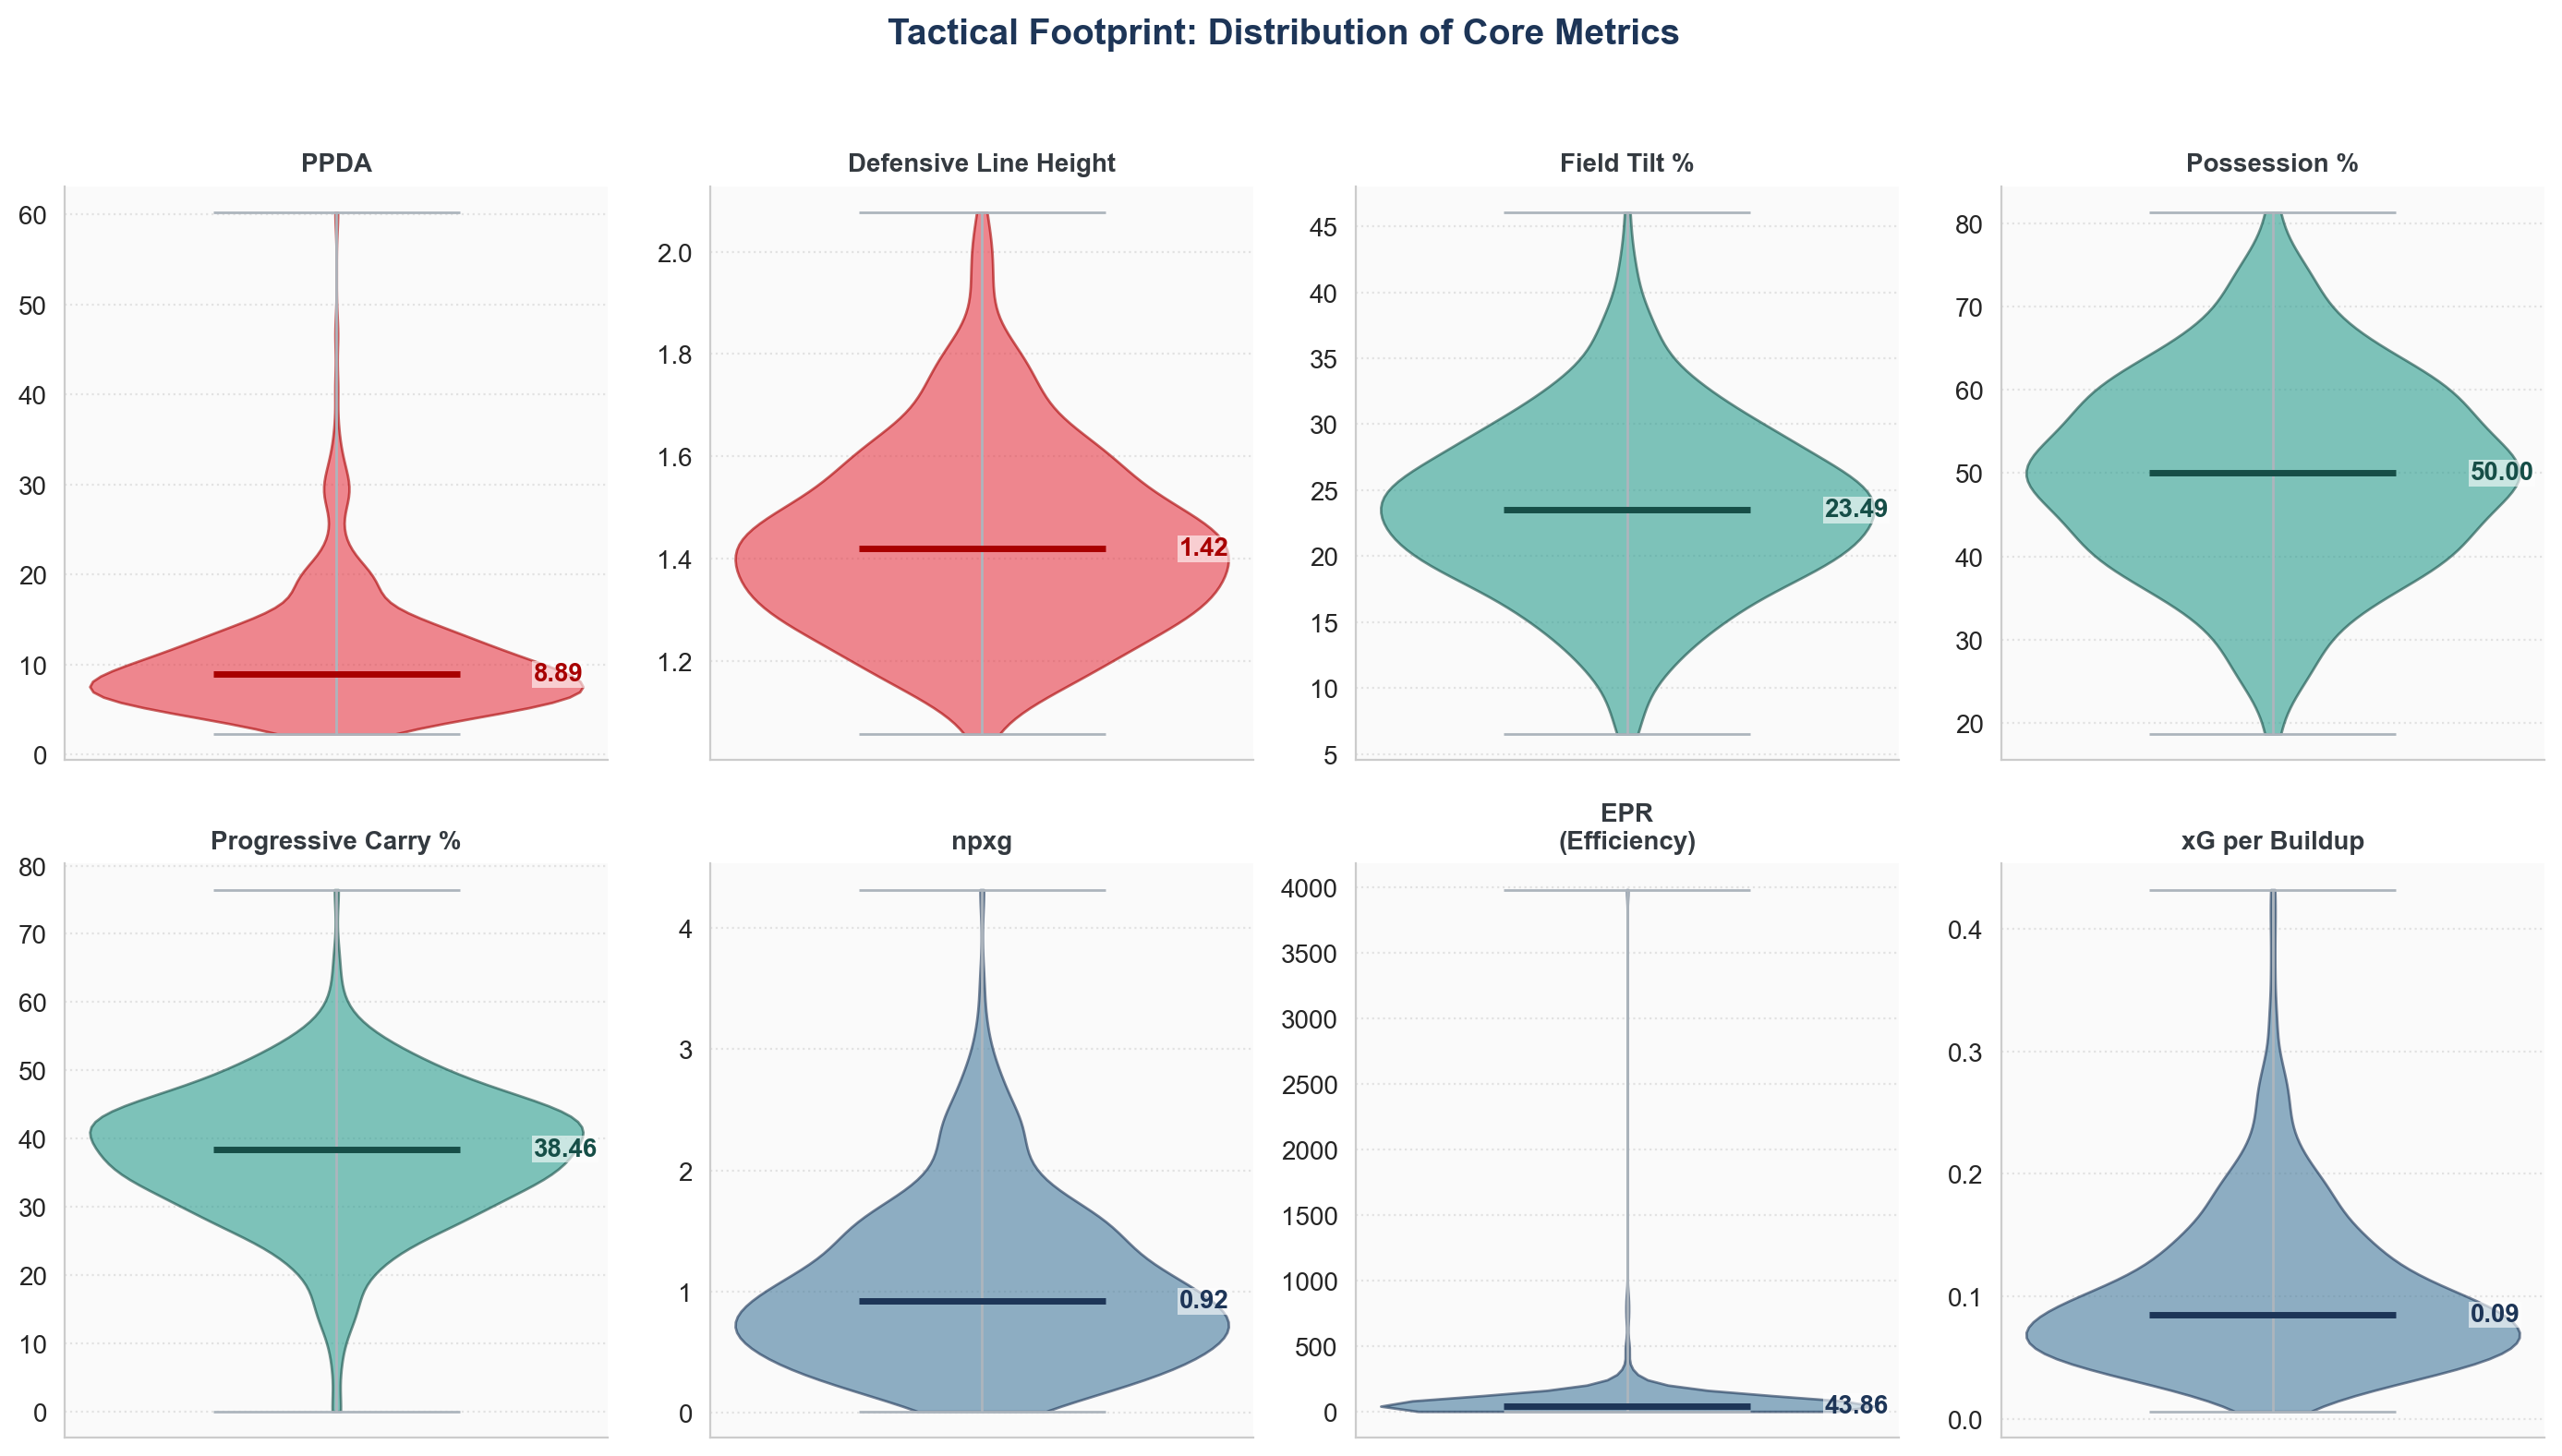

In [ ]:
plot_metric_distributions(metrics)

#### Tactical Insights from Distributions
- **Intensity Bipolarity (PPDA):** The median 8.89 reflects the high-intensity pressing dominant in the 2022–2024 cycle. However, the extreme right tail stretching toward 60 confirms that the traditional mid-block is being abandoned; teams increasingly choose to either squeeze the pitch aggressively or "park the bus" in ultra-passive structures to survive knockout rounds.
- **The Possession Trap (EPR):** While Possession % is beautifully symmetric around a 50.00 median, EPR (Efficiency) shows extreme "sterile" outliers reaching toward 43.86 as a clustered median with tails near 4000. This captures the modern struggle where high-possession teams fail to convert control into threat, resulting in a "high volume, zero ROI" profile.
- **Structural Realism (xG per Buildup):** This distribution is heavily right-skewed and tightly clustered near a median of 0.09. This is a realistic reflection of the current meta: scoring through complex, multi-player passing sequences is statistically rare. Only an elite "tactical tier" escapes this cluster, making this metric the ultimate filter for identifying genuine 2026 title contenders.
- **Style vs. Volume (Progressive Carry %):** The 38.46 median and the unique shape of the Carry % violin do not mirror the Possession violin. This confirms that vertical, line-breaking carries  are a deliberate tactical choice rather than just a byproduct of having the ball.
- **Defensive Realism (Line Height):** The median Defensive Line Height of 1.42 reveals that despite the "high press" narrative, the average team defends roughly 30 yards from their own goal. This highlights a move toward deep-mid blocks to minimize space behind for elite sprinters, a trend likely to define the 2026 defensive landscape.
- **The Rise of the "Transition Monster":** The relationship between aggressive pressing (PPDA 8.89) and low territorial dominance (Field Tilt 23.49%) suggests a "Transition Meta". Teams are hunting the ball aggressively not for possession, but to strike immediately into open space, often conceding territory as a tactical bait.

#### Implications for Clustering & Machine Learning
The shape of these metrics dictates the following pipeline configurations for the tactical clustering phase:

| Action | Technical Justification | Tactical Outcome |
|--------|-----|----------------|
Outlier Capping | Capping EPR at 99th percentile before scaling. | Prevents "sterile" outliers from mathematically drowning out the variation in meaningful attacking metrics.|
Weighting Gravity|Prioritizing Line Height (1.42 median) and Possession.|These act as the model's "gravity," creating the primary split between proactive and reactive archetypes.|
Orthogonal Splits|Leveraging the independence of EPR and Carry %.|Allows the model to separate "tactical twins" (teams with identical possession) into distinct styles based on efficiency.|

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.1.2 Inter-Metric Correlation & Tactical Independence

Saved: figures/team_metrics_corr.png


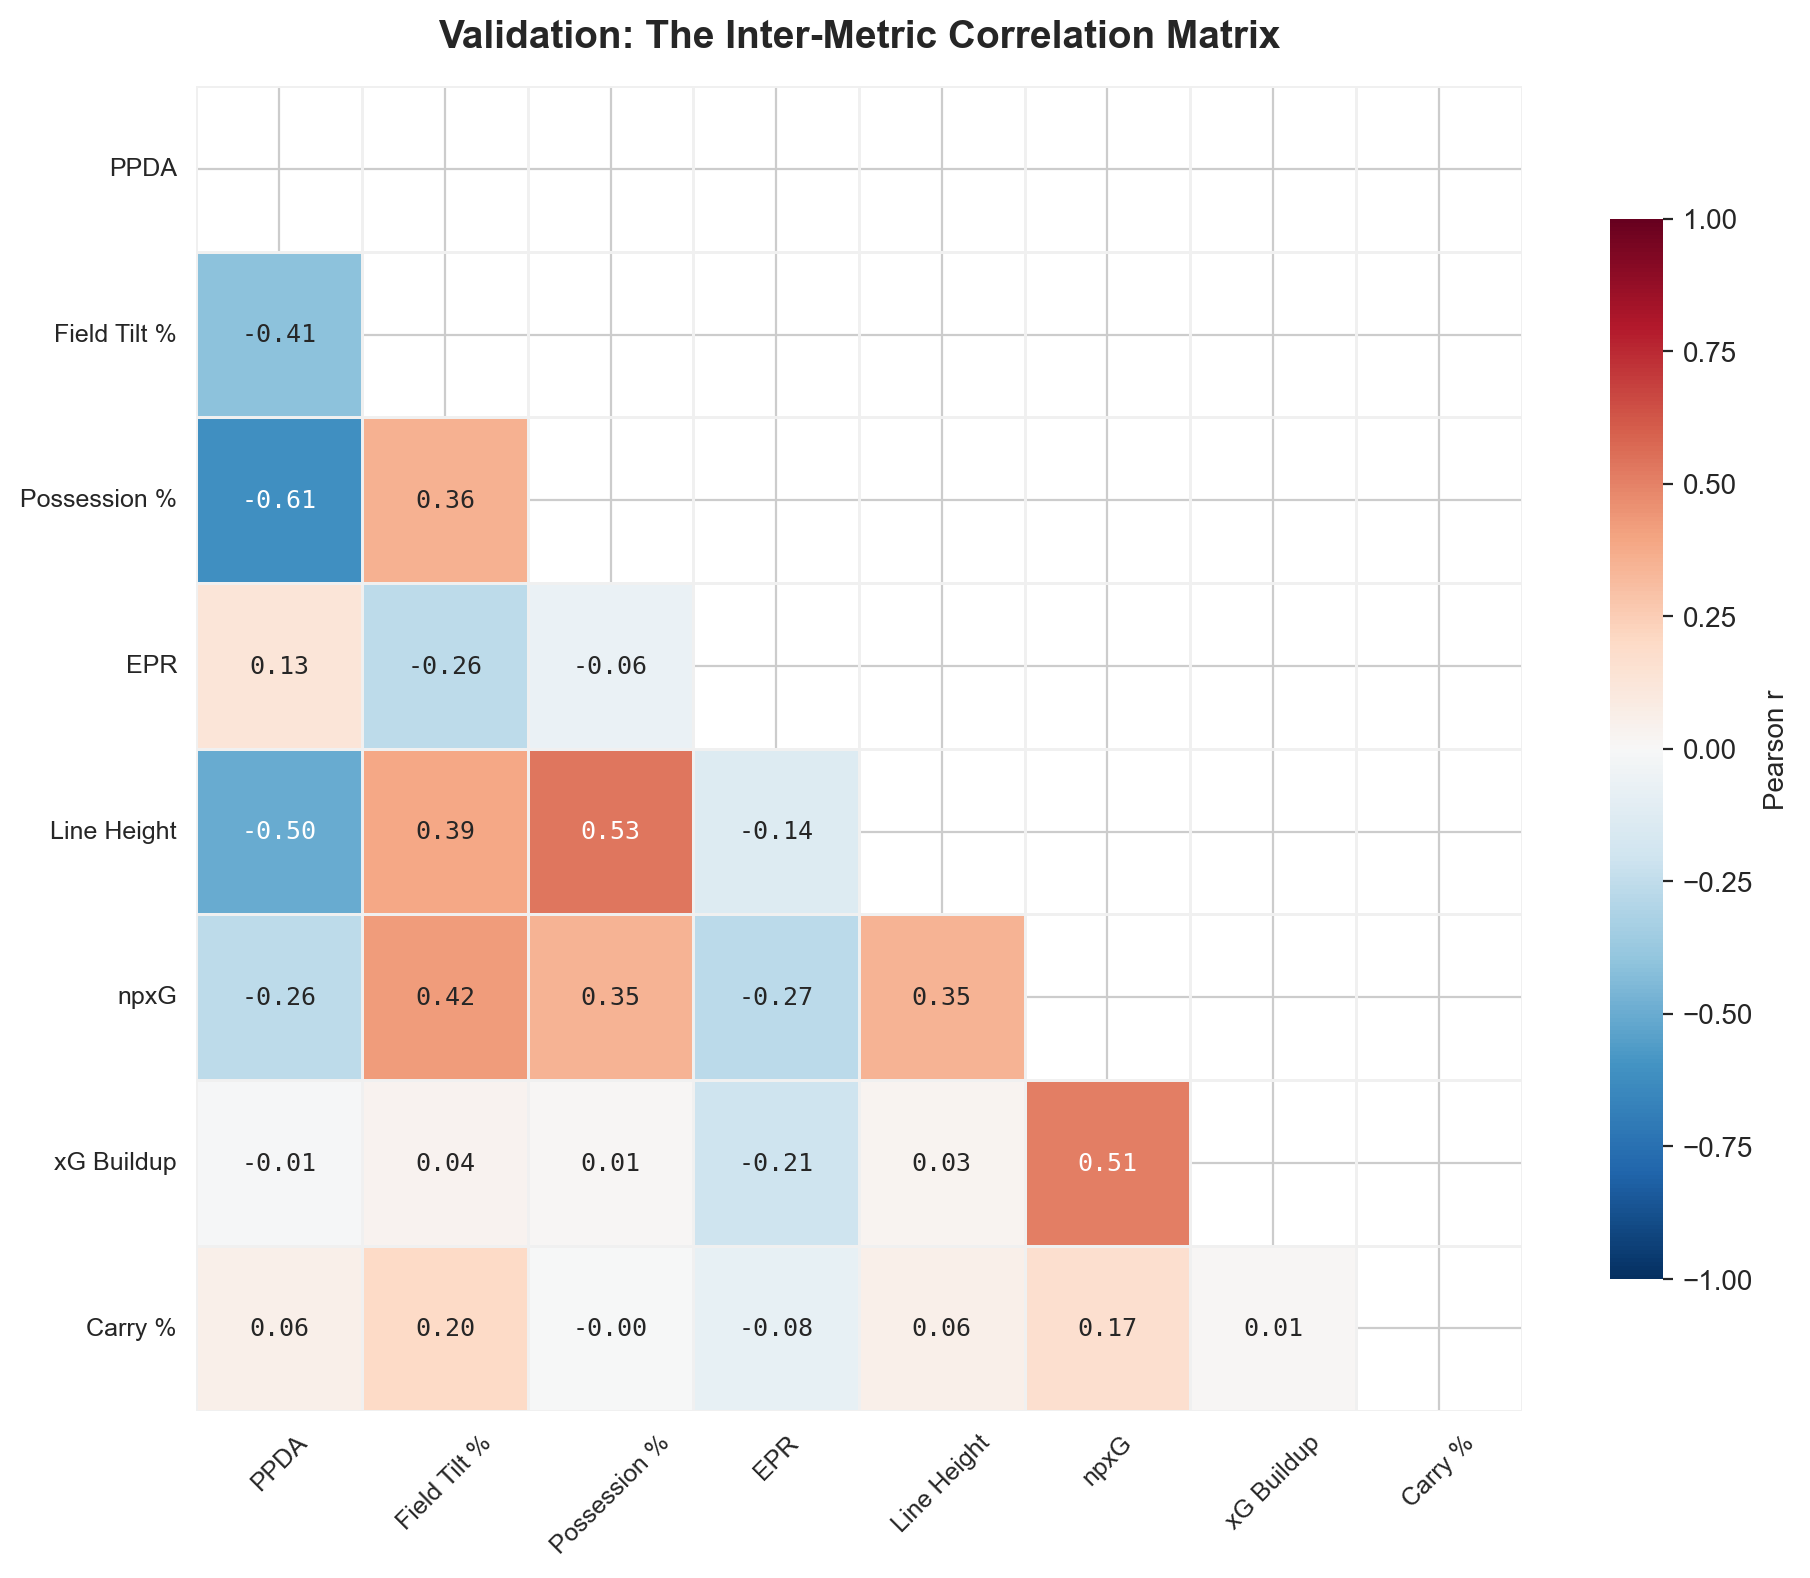

In [ ]:
plot_correlation_matrix(metrics)

#### What Does the Correlation Matrix Reveal?
The correlation matrix serves as the "logical audit" of our 8-metric framework, confirming 
that our features provide non-redundant, diverse information about team behavior.

- **The Press-to-Possess Axis:** The strongest relationship in the dataset is the negative correlation between PPDA and Possession % (r = -0.61). Since lower PPDA signals more aggressive pressing, this confirms that at international tournament level, high-press teams 
also tend to dominate the ball — consistent with the profile of technically superior sides 
like Spain or Germany, where pressing and retention are complementary rather than opposing 
strategies. That said, with only ~37% of shared variance, the relationship is far from 
deterministic: it remains entirely possible to be an aggressive presser that prioritizes 
immediate transitions over ball retention.

- **The Proactive Geometry:** Line Height shows positive correlations with both Possession 
(0.53) and Field Tilt (0.39). This is consistent with the "Defensive Realism" theory: teams 
that commit to a high line tend to also pin opponents in their own half and control tempo, 
suggesting these three metrics form a coherent "proactive" tactical cluster.

- **The Independence of Efficiency (EPR):** EPR is virtually uncorrelated with all other 
metrics, with its strongest relationship being a negligible 0.13 with PPDA. This is a 
critical finding — Possession Efficiency is a distinct skill set entirely independent of how 
much ball a team has. A team can dominate possession and remain completely ineffective at 
generating threat, producing the "sterile dominance" profile identified in the distribution 
analysis.

- **Stylistic Progression (Carry %):** Carry % shows a −0.00 correlation with Possession %, 
making it the most orthogonal metric in the framework. This confirms that how a team 
progresses the ball — through individual carries or collective passing — is a deliberate 
stylistic choice, not a byproduct of how much ball they have.

- **The xG Engine:** npxG shows its strongest links with xG Buildup (0.51) and Field Tilt 
(0.42). This confirms that the most repeatable route to high-quality chance creation runs 
through sustained territorial dominance and structured buildup play, rather than through 
isolated or set-piece-driven opportunities.

#### Implications for Clustering & Machine Learning
The Pearson r values from the correlation matrix serve as the blueprint for our unsupervised 
learning architecture. By understanding which metrics move together, we can configure the 
model to prioritize meaningful tactical splits.

| Action | Technical Justification | Tactical Outcome |
|--------|-----|----------------|
PC1 Axis Weighting|High correlation between PPDA, Possession, and Line Height (up to r = -0.61).|Automatically establishes the primary divide between "Proactive" (High Press / High Line) and "Reactive" (Deep Block / Passive) teams.|
Z-Axis Differentiation|EPR and Carry % show near-zero correlation with Possession (r = 0.13 and -0.00).|Allows the model to split "Tactical Twins" — teams with identical possession profiles but different efficiency (Sterile vs. Clinical) or progression styles (Carrier vs. Passer).|
Feature Retention|The highest correlation is only 0.61, well below the collinearity threshold (0.80+).|Ensures every feature brings independent information to the model, justifying the 8-metric framework as a robust, non-redundant tactical signature.|
Refining "Danger" Weights|npxG correlates strongly with xG Buildup (0.51) and Field Tilt (0.42).|The model will weight structured territorial dominance over isolated shot volume when identifying the most dangerous elite teams.|

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.1.3 Tactical Identity vs. Success

The relationship between tactical proactive-ness (PPDA/Possession) and tournament outcome confirms that "winning football" follows a distinct statistical pattern, though outliers remain.

Saved: figures/tactical_scatter.png


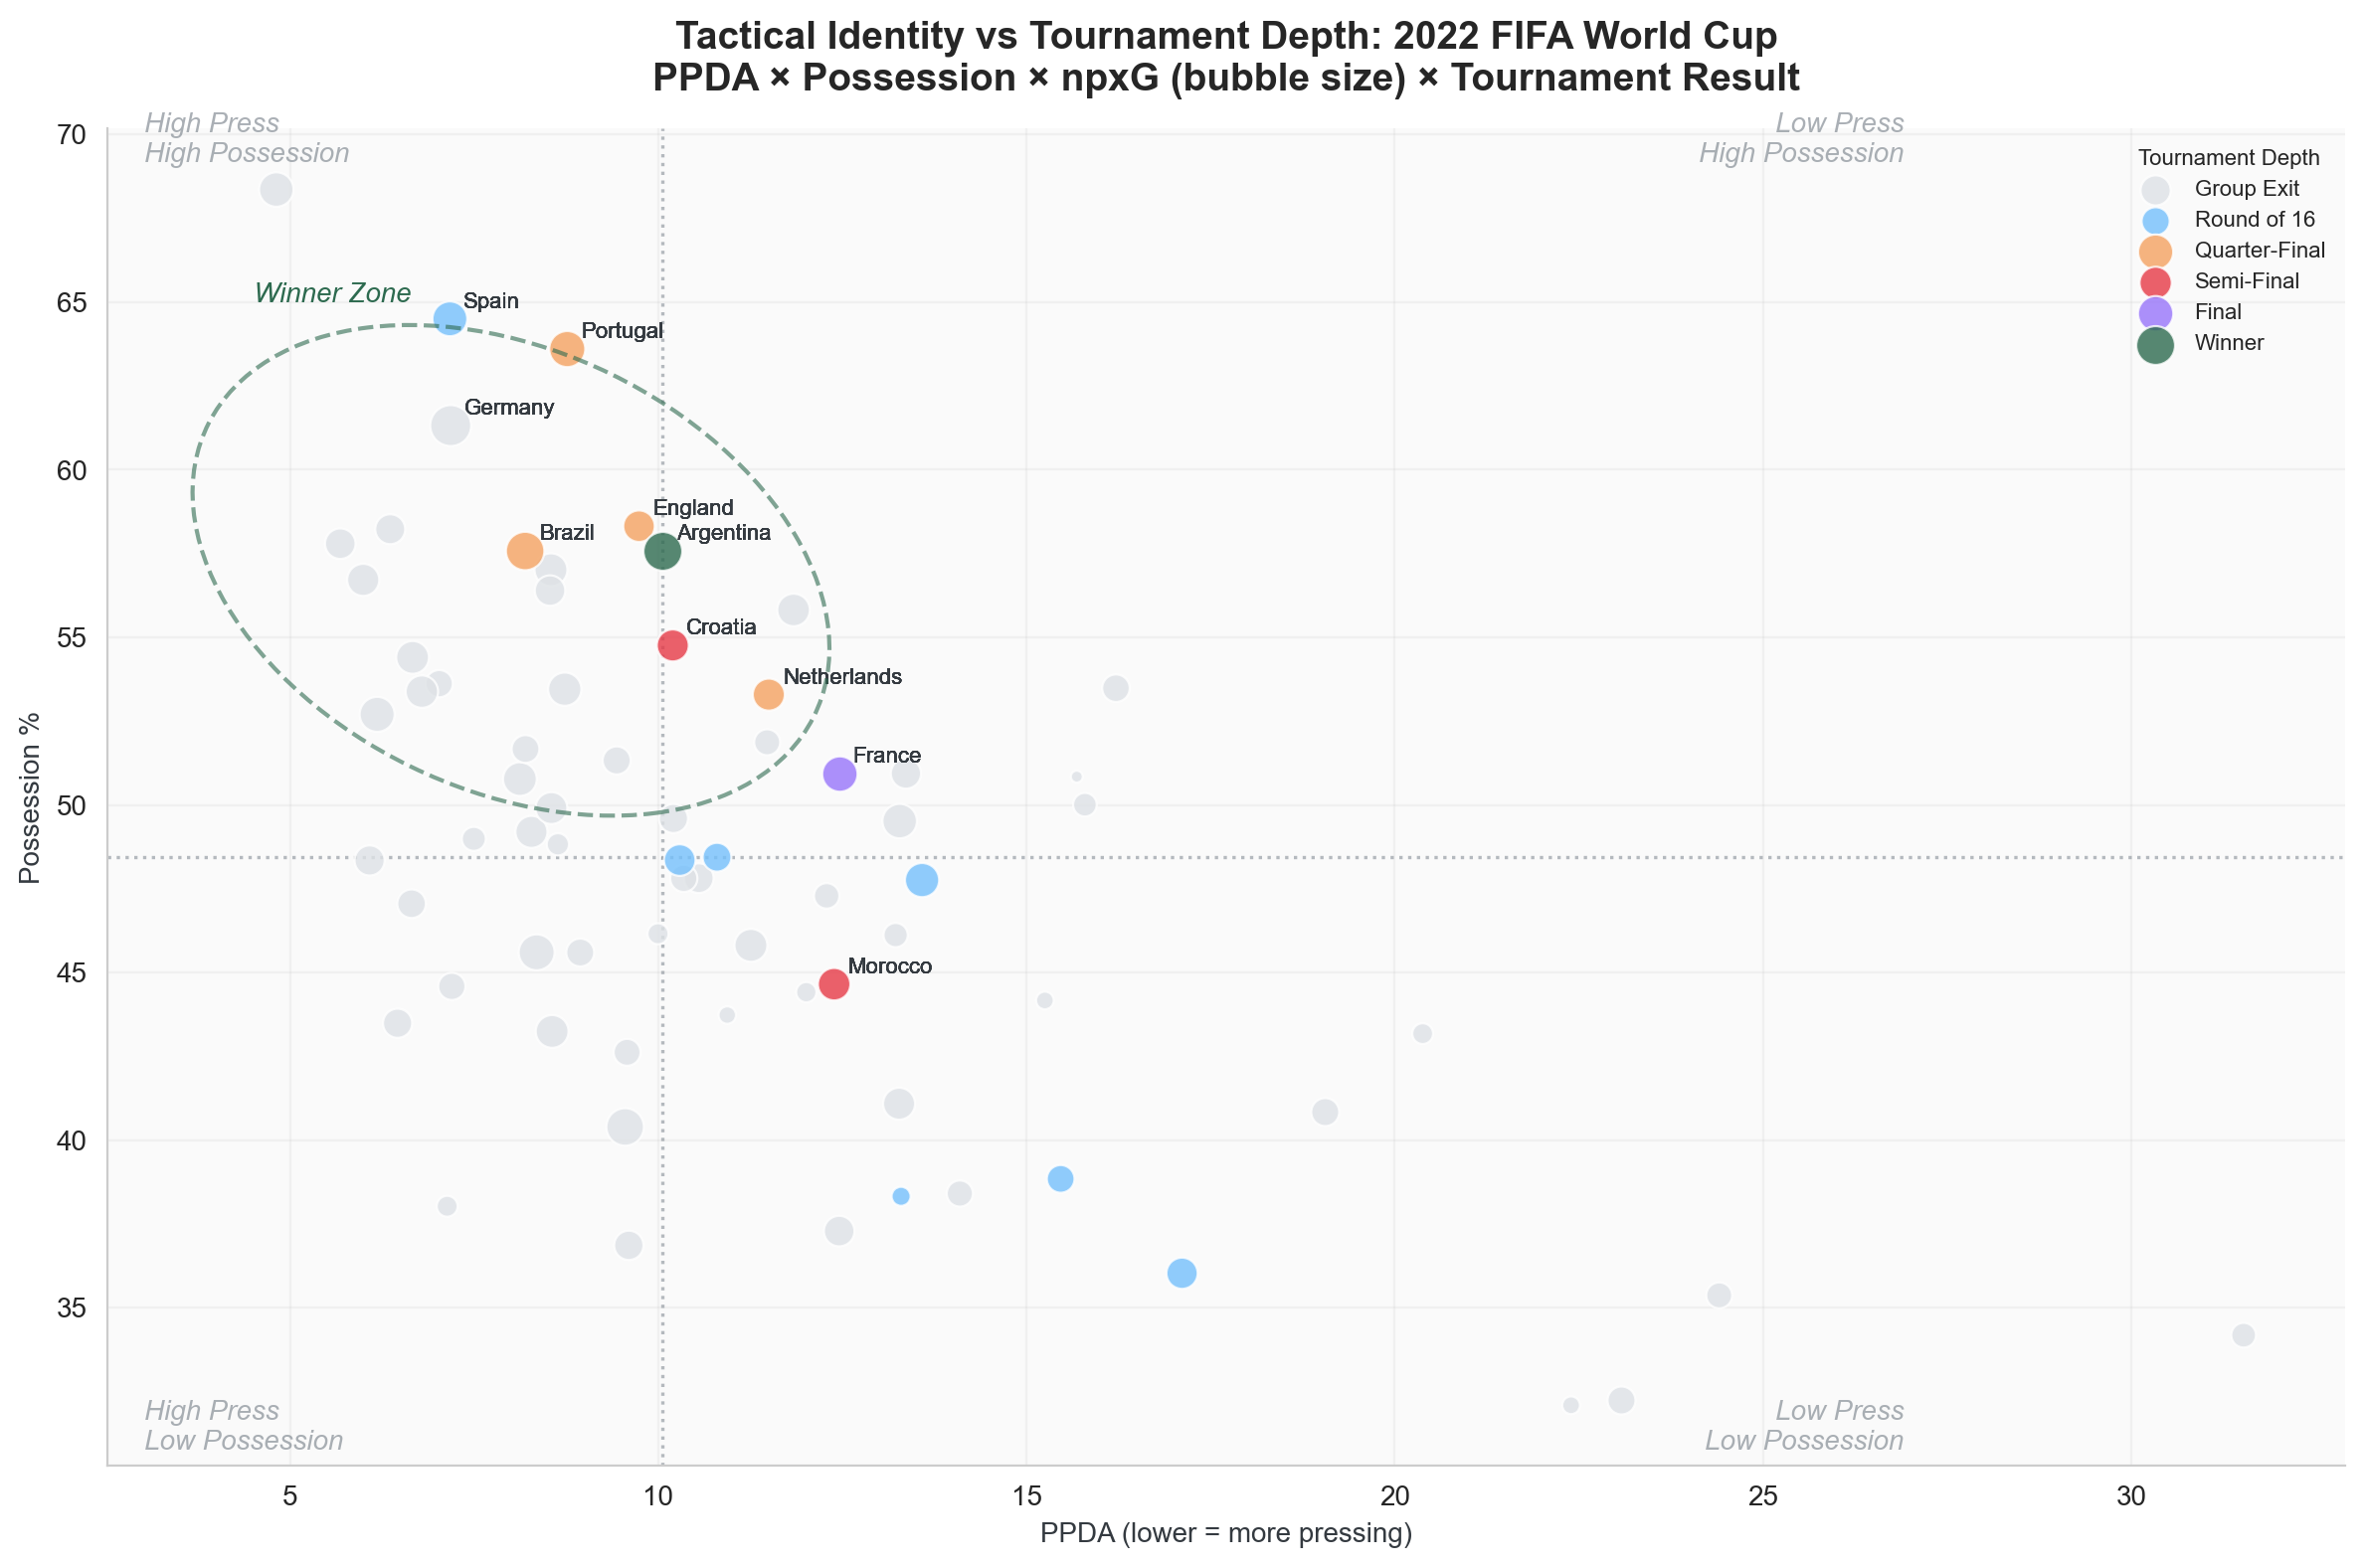

In [ ]:
plot_tactical_scatter(metrics)

#### What Do We See in the Scatter Plot?

- **The Empirical "Winner Zone":** A clear density of deep tournament runs occupies the 
top-left quadrant. Argentina (Winner), England (Quarter-Final), Spain (Round of 16), and 
Germany cluster inside the high-possession (57–65%), high-press (PPDA 6–10) ellipse. This 
confirms that proactive, territorially dominant football was the most statistically reliable 
path to the later stages in 2022.

- **The Gradient of Success:** Moving toward the bottom-right quadrant — lower possession, 
higher PPDA — shows a clear concentration of Group Stage exits. The grey bubble density 
thins rapidly as you move toward the top-left, reinforcing that passive, low-intensity 
systems provide a lower statistical floor for tournament survival.

- **The Elite Pragmatists (France & Morocco):** Both teams share a similar PPDA (~13), 
sitting just outside the Winner Zone's pressing threshold, yet both reached the Final and 
Semi-Final respectively. What separates them is possession and individual quality: France 
(~51% possession) carries a significantly larger npxG bubble, indicating elite chance 
creation driven by individual execution rather than collective dominance. Morocco (~45% 
possession) produced a smaller bubble, achieving their result through defensive discipline 
and structural compactness rather than attacking volume. Together they form a distinct 
"Elite Pragmatist" tier — proving that a non-pressing identity can still deliver elite 
outcomes, but through very different mechanisms.

- **The Croatia Anomaly:** Croatia (Semi-Final, red) sits at ~54% possession and PPDA ~11, 
placing them on the edge of the Winner Zone. Their modest bubble size relative to their 
tournament depth suggests they overperformed their xG profile — consistent with their 
historically resilient knockout performances driven by experience and set-piece efficiency 
rather than attacking dominance.

#### Implications for Clustering & Machine Learning
The spatial distribution of teams confirms the final configuration parameters for our 
unsupervised learning model.

| Action | Technical Justification | Tactical Outcome |
|--------|-----|----------------|
Primary Axis Definition|The diagonal gradient from top-left to bottom-right confirms PPDA and Possession as the dominant structural split.|Establishes the PC1 engine for K-means separation, distinguishing "Proactive Dominant" from "Reactive" teams along a single coherent axis.|
Multi-Cluster Expansion (k=4)|France and Morocco occupy a distinct spatial tier from both the Argentina/Spain cluster and lower-performing passive teams, despite sharing similar PPDA.|Ensures the model separates "Elite Pragmatists" as their own archetype, preventing them from being collapsed into generic defensive clusters.|
npxG as Quality Filter|Bubble size varies significantly within tactical clusters — France and Argentina are large; Morocco and Croatia are modest.|The model will use npxG as an intra-cluster differentiator, identifying teams that share a tactical identity but differ in actual threat generation.|

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.1.4 Does Tactical Identity Predict Outcomes?
To move from tactical theory to competitive reality, we must test if these quadrants actually translate to winning. By splitting the recent tournament dataset based on median tactical values, we can calculate the win, draw, and loss rates for each identity. This provides a reality check on which tactical profiles actually translate into match-day results. While the scatter plot predicts tournament depth, the quadrant analysis validates tactical identity at the individual match level.

Saved: figures/team_outcome_by_quadrant.png


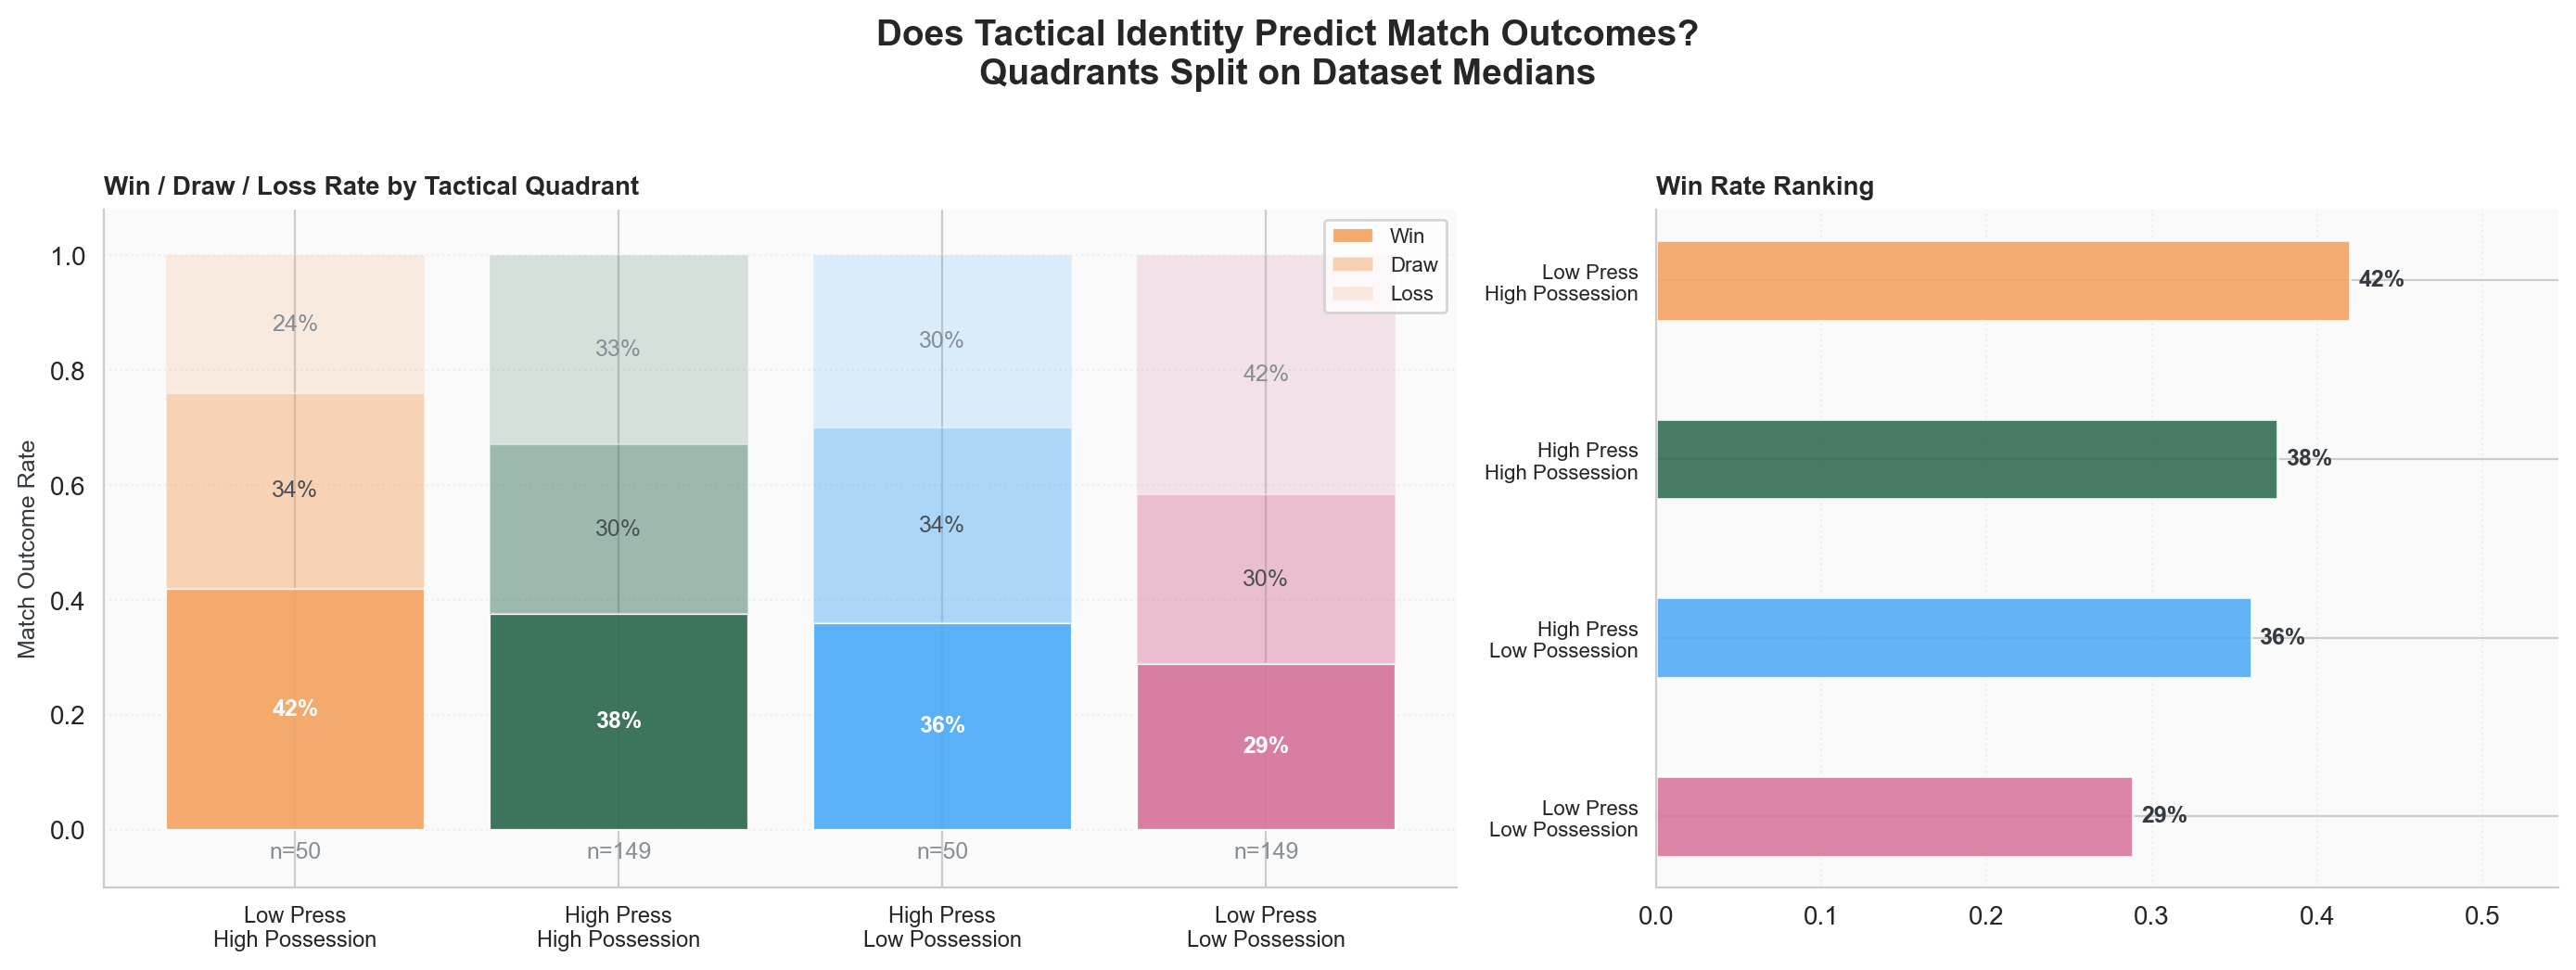

In [ ]:
plot_outcome_by_quadrant(metrics, STATSBOMB_DIR)

#### What Does the Quadrant Chart Reveal?
- **The Rare Efficiency of "Patient Control" (Low Press / High Possession):** The headline finding is counterintuitive: this quadrant wins 42% of matches, the highest of any group. However, the n=50 sample size is key; this isn't a "magic formula," but a selective sample of technically superior teams playing patient football. They don't need to "hunt" for the ball with an aggressive press (lower PPDA) because they maintain high possession levels.
- **The "Mainstream Meta" (High Press / High Possession):** With the largest sample size (n=149), this quadrant represents the modern elite standard. Its 38% win rate is robust but slightly lower than the "Patient Controllers," likely because it includes high-intensity "heavyweight" matchups where dominant teams face each other.
- **The Futility of the "Passive Bus" (Low Press / Low Possession):** At a 29% win rate, this is the least viable strategy. Passive defending combined with ceding the ball results in the highest loss rate (42%) in the dataset. It validates the framework: "parking the bus" without a transition threat is statistically the fastest way to a tournament exit.
- **The "Chaos" Tax (High Press / Low Possession):** High pressing without the quality to sustain possession results in a 36% win rate and a 30% loss rate. While physically imposing, this "Vertical Disruptor" profile often lacks the technical composure to consistently convert high turnovers into goals over 90 minutes.

#### Match Outcome vs. Tournament Depth

While these match-level win rates validate the tactical framework, they come with a crucial caveat: winning individual matches is not the same as winning tournaments. A team can win a high percentage of matches and still exit if they lose a single high-stakes knockout game. The **scatter plot (tournament depth)** remains the more valid predictor of long-term success, while the **quadrant chart (match outcomes)** validates tactical identity at the individual match level.

#### Implications for Clustering & Machine Learning

| Action | Technical Justification | Tactical Outcome |
|--------|-----|----------------|
|Multi-Metric Cluster Validation|Win rates vary significantly by quadrant (29%–42%).|Evaluation requires K-Means inertia, Silhouette scores, and GMM cross-checks.	Ensures clusters aren't just "neat boxes," but represent distinct tactical tiers with **statistically different** probabilities of success.|
Identifying "Tactical Efficiency"|The highest win rate (42%) comes from the quadrant with the smallest sample size (n=50).|The model should flag "Low Press / High Possession" as a high-efficiency archetype, helping sponsors identify teams that win through control rather than physical exertion.|
Weighted Success Metrics|High Pressing (PPDA) shows a higher win rate only when paired with high possession (38% vs 36%).|During K-Means, we should ensure the model treats these as **interactive features,** recognizing that "intensity" without "control" is a statistically riskier profile.|

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.1.5 The Tactical Fingerprint: Global Convergence vs. Regional Alpha
Standard normalization often masks the true competitive differences between tournaments. To satisfy a more rigorous tactical inquiry, the **Z-Score Radar** centers on the **Global Population Mean** (0.5) and scales axes by **Standard Deviation** (σ) to expose the "Tactical Tilt" of each tournament.

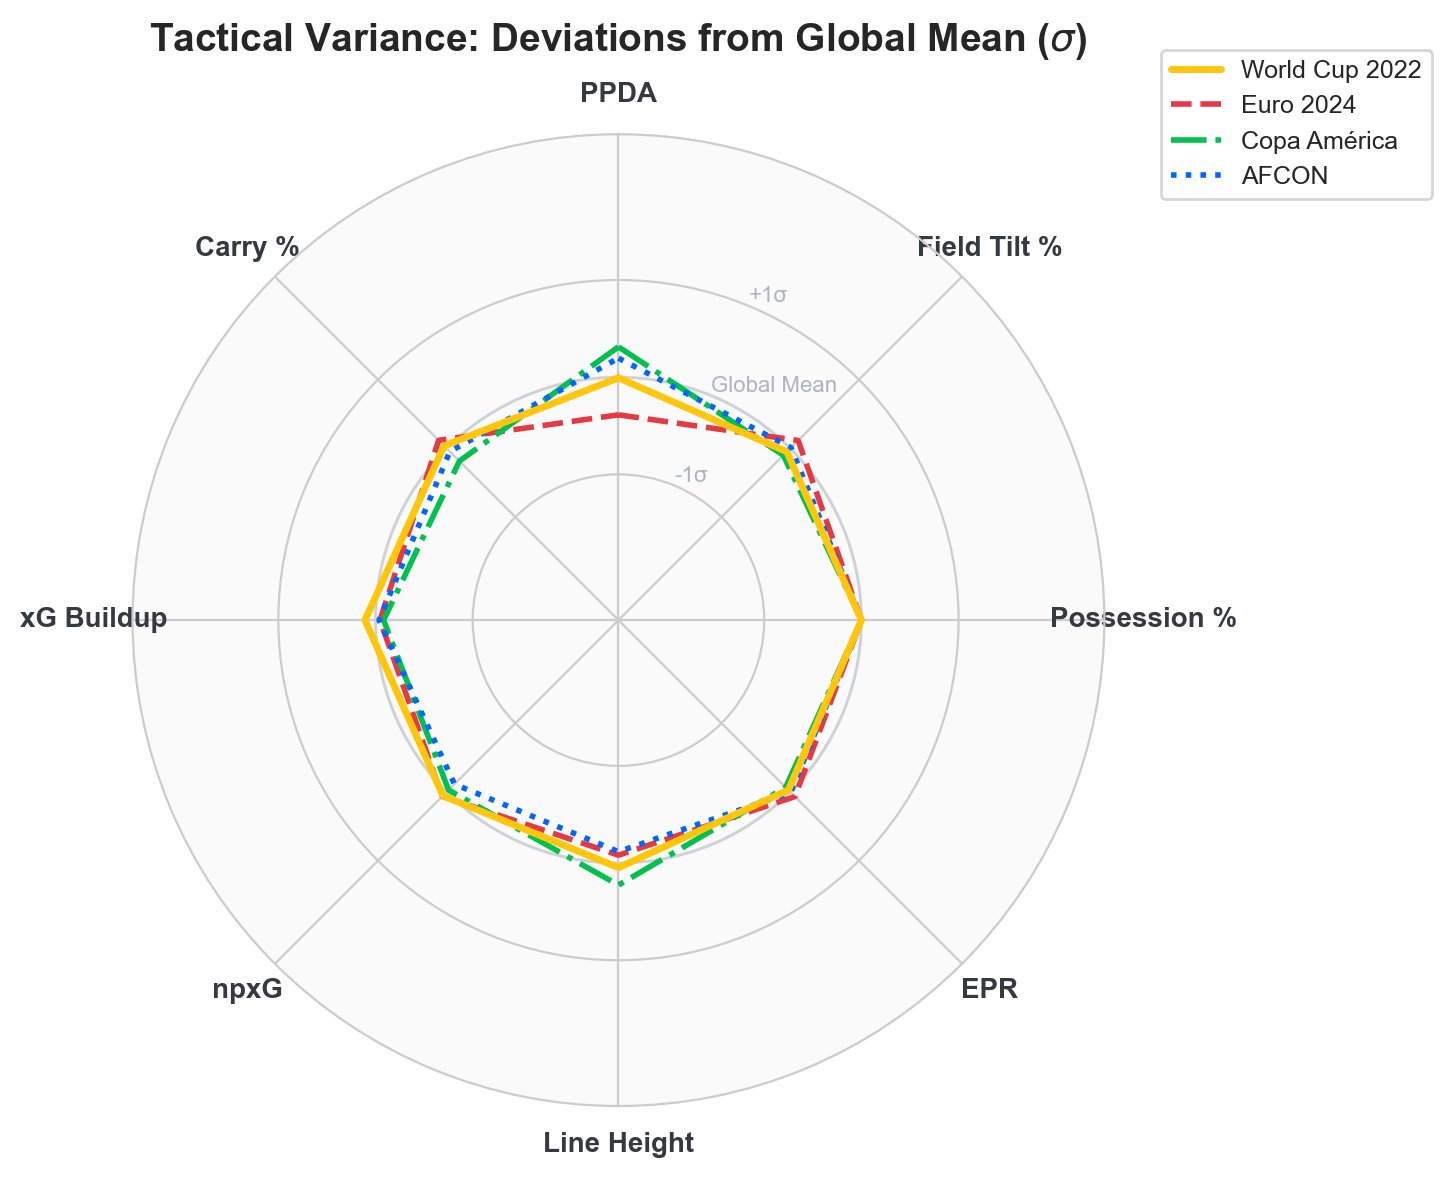

In [ ]:
plot_competition_radar(metrics, STATSBOMB_DIR)

#### What Does the Radar Chart Reveal?
The overlapping profiles in this final chart provide the "License to Pool" for the model. It demonstrates that WC 2022, Euro 2024, Copa América, and AFCON are tactically comparable environments, making their combination for clustering statistically defensible rather than just a convenience.

- **PPDA is the biggest divergence:** Copa América (green) pushes furthest outward on the PPDA 
axis, indicating a higher average PPDA value and therefore *lower* pressing intensity 
relative to the global mean. This suggests CONMEBOL tournament football is on average more 
positional and patient in its defensive structure compared to Euro 2024 and AFCON, which 
cluster closer to the global mean.
- **Possession % is the tightest convergence:** All four tournament lines converge almost 
perfectly at the Possession % axis, sitting near the global mean. Ball control volume has 
effectively become a universal baseline at elite international level, regardless of 
confederation.
- **Stability in Efficiency:** EPR shows the second tightest convergence, with all four lines tracking very near the global mean. The "cost" of creating threat appears to be a consistent constant across all four competitions.
- **Regional Specialties:** Copa América exhibits the highest deviation in Line Height, pushing beyond +1σ, while AFCON shows a distinct lean toward higher npxG and xG Buildup compared to the global average.

#### Implications for Clustering & Machine Learning
These findings dictate how the model should treat tournament-specific data during the final clustering phase.

| Action | Technical Justification | Tactical Outcome |
|--------|-----|----------------|
|Unified Feature Scaling|Near-identical Possession % and EPR means across all four tournaments.|Validates the use of a single global scaler; the model can treat teams from AFCON and Euro 2024 as part of the same tactical universe without confederation bias distorting the output.|
|PPDA Variance Sensitivity|Copa América shows a higher average PPDA (less pressing) than the global mean, creating a modest confederation-level signal.|The model will calibrate pressing labels relative to the global population rather than within-tournament norms, ensuring a Copa América "high presser" is genuinely comparable to a Euro 2024 equivalent.|
|Eliminating Regional Noise|The majority of the 8-metric framework converges within a narrow band across all four tournaments.|Subsequent clustering will be driven by within-tournament team variance rather than confederation-level effects, ensuring archetypes reflect genuine tactical identities rather than regional styles.|

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯
### 2.1.6 Tactical Consistency: Mapping Match-to-Match Volatility
While the competition radars confirm a global convergence in tactical averages, the **Tactical Consistency** analysis reveals how individual nations deviate from their own identities across different matches. By plotting the **Standard Deviation of PPDA** (Pressing consistency) against the **Standard Deviation of Possession %** (Possession consistency), we can categorize the 2026 World Cup contenders into four distinct quadrants.

Saved: figures/tactical_consistency.png


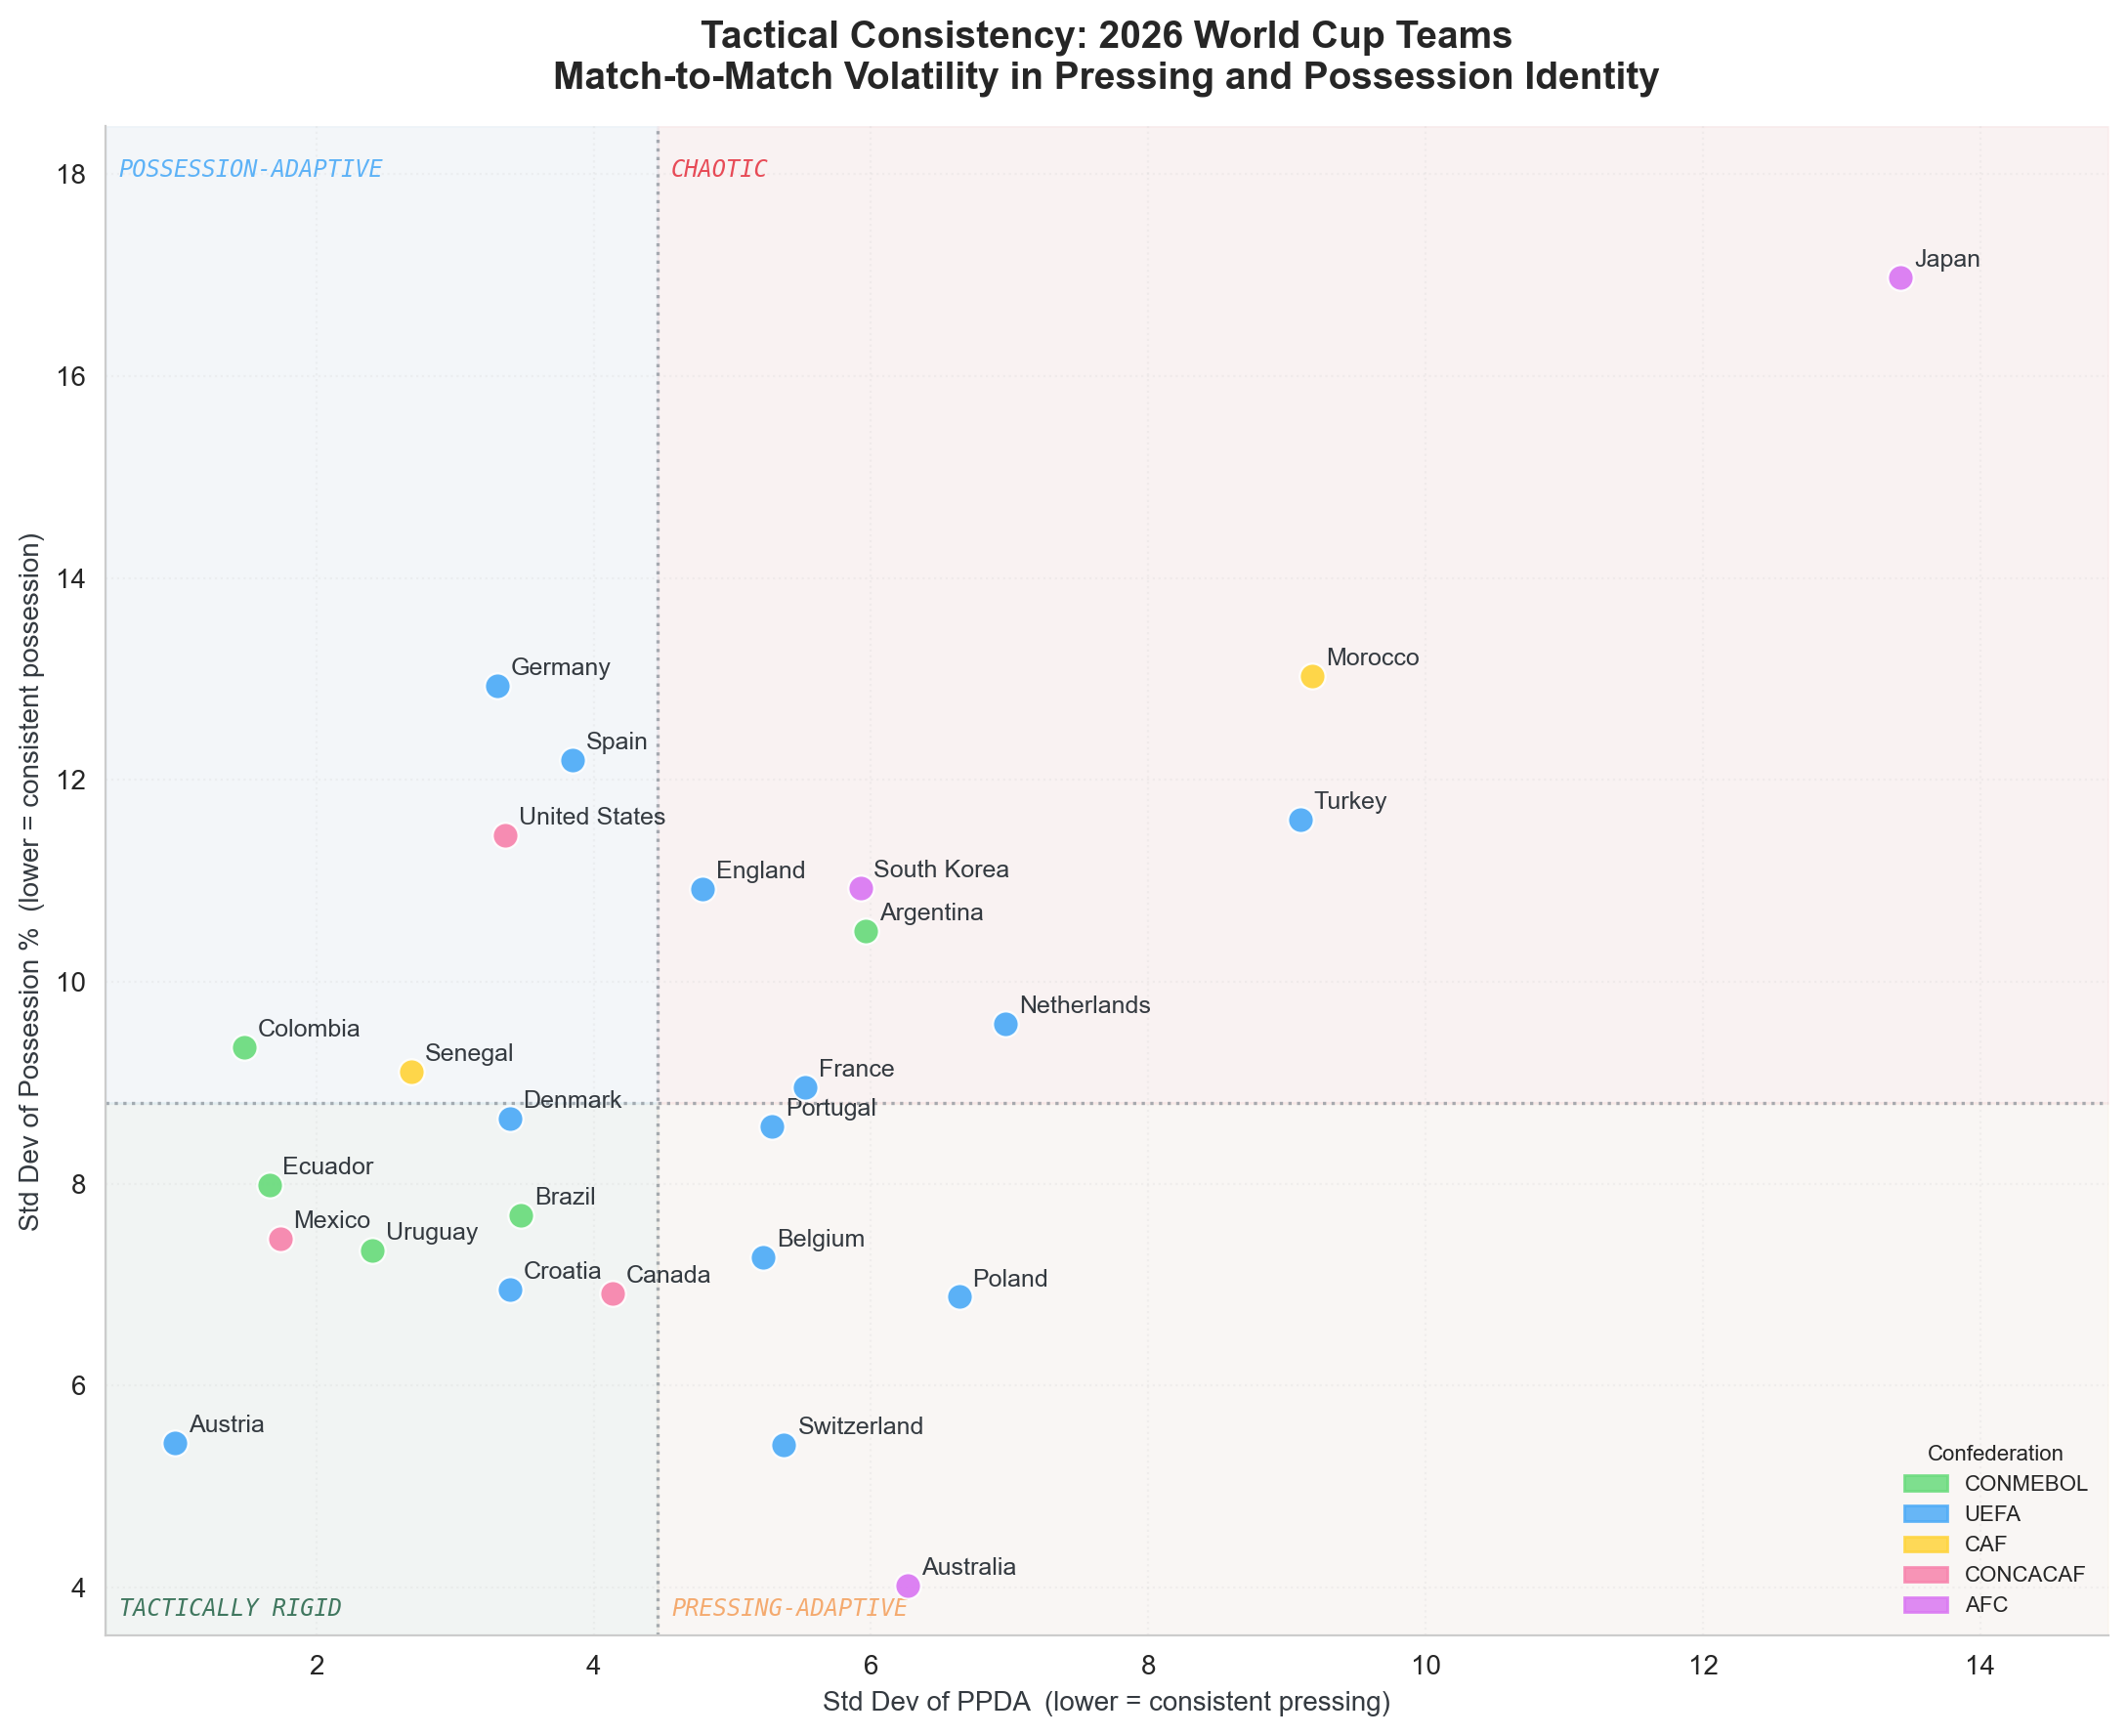

In [ ]:
plot_tactical_consistency_scatter(metrics, min_matches=3)

#### The CONMEBOL Cluster: A Standout Finding
The most striking geographic pattern is the clustering of Colombia, Ecuador, Uruguay, and 
Brazil in the bottom-left "Tactically Rigid" quadrant, joined by Mexico from CONCACAF.

- **The Professionalization of Structural Discipline:** These teams exhibit the lowest 
volatility in both pressing and possession across the entire dataset. This rigid profile 
reflects highly automated systems where tactical consistency has been prioritized over 
match-to-match adaptability — a deliberate identity rather than a limitation.

- **The Qualification Pressure Cooker:** CONMEBOL's 18-round qualification process,  
played across extreme altitude, heat, and travel variance, rewards sides that can execute 
a reliable "Base Identity" regardless of environment. The data suggests this has produced 
a cohort of structurally disciplined sides entering 2026.

- **The Mexico Connection:** Mexico's presence in this cluster alongside CONMEBOL sides 
confirms a tactical alignment with South American structural norms — a settled defensive 
block and consistent possession patterns suited to the demands of the 2026 host 
environment.

#### Argentina: Chaotic by Design
Despite being reigning World Champions, Argentina sits just inside the "Chaotic" quadrant, 
showing above-median variance in both pressing (~6.5) and possession (~10.5).

- **The Scaloni Chameleon:** Argentina's position reflects a deliberate adaptability; 
capable of dominating possession against mid-tier opposition while deploying a compact 
defensive block against elite opponents. Unlike Japan or Morocco, whose chaos reflects 
reactivity, Argentina's variance appears purposeful and outcome-driven.

- **Elite Chaos vs. Reactive Chaos:** Argentina's modest position in the Chaotic quadrant 
distinguishes them from the extreme outliers. Their variance is controlled rather than 
radical, making them the bridge between the "Possession-Adaptive" heavyweights and the 
high-variance reactive sides.

#### The Possession-Adaptive Heavyweights: Germany, Spain, and the United States
Germany and Spain anchor the top-left "Possession-Adaptive" quadrant, showing high 
possession variance alongside consistent pressing intensity. The United States sits just 
inside this quadrant as a notable inclusion.

- **Germany's Hybrid Identity:** Under Nagelsmann, Germany oscillates between 
high-possession buildup and aggressive counter-pressing, producing one of the highest 
possession standard deviations (~13) in the dataset. Their pressing remains comparatively 
consistent, suggesting the variation is tactical rather than structural.

- **Spain's Vertical Evolution:** The reigning European champions have moved beyond 
tiki-taka. High possession variance reflects a team now comfortable dropping volume to 
exploit vertical transitions, while maintaining a stable pressing framework.

- **The United States as a Tactical Outlier:** The USMNT's presence in the 
Possession-Adaptive quadrant is the most surprising finding for a CONCACAF side. Their 
possession variance (~11.5) rivals Spain's, suggesting a rapidly evolving tactical 
identity driven by their MLS and European-based squad profile.

#### The "Chaotic" Quadrant: Japan, Morocco, and Turkey
The top-right quadrant contains the dataset's most volatile sides — teams whose 
match-to-match identity shifts radically in both dimensions.

- **Japan (The Extreme Outlier):** Japan sits at the furthest point in the dataset (~13.5 
PPDA variance, ~17 possession variance), reflecting a team that switches between 
high-pressing dominance and ultra-passive low-blocks more radically than any other side. 
This is reactive volatility at its most extreme.

- **Morocco (Contextual Mastery):** Morocco's high variance (~10, ~13) reflects a 
deliberate two-mode system — disciplined defensive compactness against elite opposition, 
dominant control against peers. Their chaos is strategic rather than structural.

- **Turkey:** Turkey's presence in the Chaotic quadrant (~10, ~11.5) is worth monitoring 
heading into 2026 — high variance in both dimensions suggests an unsettled tactical 
identity that could cut either way in a tournament environment.

#### The Systematic Benchmarks: Austria, Switzerland, and Australia
- **Austria (The Rigid Benchmark):** The extreme bottom-left position confirms Austria as 
the most tactically automated side in the dataset. Under Rangnick, their Gegenpressing 
system runs regardless of opponent, producing the lowest possession variance in Europe.

- **Switzerland and Australia (Pressing-Adaptive):** Both sit in the bottom-right 
"Pressing-Adaptive" quadrant, with Australia representing the extreme case (~5.5 PPDA 
variance, ~4 possession variance). These sides adjust their pressing intensity to match 
context while maintaining a highly consistent possession identity; a pragmatic, 
opponent-led approach.

#### The Pragmatic Medians: France and Portugal
France and Portugal sit near the center of both axes, representing a shared philosophy of 
prioritizing game state over fixed tactical identity. Their central positions validate a 
commitment to contextual efficiency — neither rigidly consistent nor chaotically volatile, 
but deliberately adaptive within controlled parameters.

#### Implications for Clustering & Machine Learning

| Action | Technical Justification | Tactical Outcome |
|--------|-----|----------------|
|Standard Deviation as a Feature|Elite teams (Germany, Spain) show high possession variance but controlled pressing variance; reactive teams (Japan, Morocco) show high variance in both.|Including standard deviation as a feature allows the model to distinguish "High-Variance Elites" from "High-Variance Reactives" — two groups that would otherwise cluster together on mean values alone.|
|The "Chameleon" Score|Argentina sits in the Chaotic quadrant despite being World Champions, with variance that is purposeful rather than reactive.|The model should weight variance asymmetrically — high possession variance paired with controlled pressing variance signals elite adaptability, not instability.|
|Universal Scaler Validation|The quadrant distribution spans all five confederations without obvious geographic clustering except CONMEBOL.|Confirms the global scaler approach: confederation identity explains some variance (CONMEBOL rigidity) but does not dominate, meaning cross-confederation clustering remains statistically defensible.|

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.1.7 Synthesis: Key Insights & Modeling Implications
The exploratory analysis across six visualizations — distributions, correlations, scatter 
plots, quadrant outcomes, radar profiles, and volatility mapping — converges on a coherent 
tactical picture of modern international football and provides a statistically grounded 
blueprint for the clustering phase ahead.

#### The Counterintuitive Findings
Three findings stand out as genuinely surprising: 
1. The highest match win rate (42%) 
belongs to **"Low Press / High Possession"** sides — not the high-pressing mainstream meta 
that dominates tactical discourse. This reframes the 2026 conversation: raw pressing 
intensity is not the universal success formula it is often portrayed as. 
2. **Possession Efficiency (EPR)** is entirely uncorrelated with every other metric in the framework, 
confirming that how much ball a team has tells us nothing about how dangerously they use 
it — sterile dominance is a real and measurable phenomenon. 
3. Copa América sides show 
lower average pressing intensity than the global mean while simultaneously defending with 
a higher line; a structural combination that challenges conventional pressing theory and 
suggests a **distinctly CONMEBOL tactical logic** entering 2026.

#### The Tactical Story Heading into 2026 World Cup
The data points toward a bifurcating meta. On one side, a **"Proactive Elite"** tier — 
Argentina, Germany, Spain — who combine territorial dominance with deliberate 
match-to-match adaptability, using possession variance as a weapon rather than a weakness. 
On the other, an **"Elite Pragmatist"** tier — Morocco, Japan, France — who achieve deep 
tournament runs through contextual mastery and individual quality rather than systemic 
control. 
The critical 2026 question the clustering phase must answer is whether these two 
paths are **genuinely separable archetypes,** or whether tournament success ultimately 
collapses into a single "quality" dimension that tactical identity merely decorates.

#### The ML Pipeline Implications
Five decisions flow directly from the analysis:
1. The 8-metric framework is confirmed as 
**non-redundant,** with a maximum inter-feature correlation of 0.61, well below the 
collinearity threshold which justifies full feature retention. 
2. EPR must be capped at the 99th 
percentile before scaling to **prevent degenerate outliers** from distorting cluster geometry. 
3. **Standard deviation** of PPDA and Possession must be included as features, not just means, 
to distinguish "High-Variance Elites" (Argentina, Germany) from "High-Variance Reactives" 
(Japan, Turkey). 
4. A **global scaler** is statistically defensible given the cross-tournament 
convergence in Possession % and EPR. 
5. **k=4** is the working hypothesis for cluster 
count, anchored by the four empirically distinct profiles visible in the volatility and 
scatter plots: Proactive Dominant, Possession-Adaptive, Elite Pragmatist, and Tactically 
Rigid.

-----


### 2.2 Player Quality Metrics

#### The Offensive Engine - Direct Output & Threat
| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
| **Goals − xG**<br>*(Finishing Quality)* | How much a player over- or under-performs their expected goals. A proxy for clinical finishing quality | • **High+3+:** Converts low-probability chances <br>• **±1:** Neutral <br>• **−3+:** Wasteful relative to chances created<br>| Raw goal counts are often deceptive as they don't account for the difficulty of the chance; this residual isolates pure finishing skill from the quality of the service provided. It allows the model to identify "game-breakers" who can produce a result out of nothing during tight knockout fixtures. |
| **Progressive Passes p90** | Completed open-play passes that move the ball ≥10 yards forward or into the box. Filters for middle/attacking thirds. | • **8+:** Elite playmaker<br>• **< 4:** Limited passing threat| Football is a game of territory. This metric separates ambitious playmakers from those who simply recycle possession. It identifies players with the technical bravery to dismantle defensive blocks through verticality. |
| **Team Involvement %** | Player's share of their team's total attacking threat. Identifies talismanic dependency | • **25%+:** Talismanic<br>• **15–25%:** Key attacking player<br>• **8–15%:** Regular contributor<br>• **< 8%:** Peripheral | This uses xG Chain logic to capture a player's influence on the entire buildup, not just the final shot. It exposes Tactical Risk; if a team is over-reliant on one "High Involvement" player, they are more vulnerable to be |

These metrics act as a **check-and-balance** system: Team Involvement % identifies the players the team deliberately seeks out, while Goals − xG validates if that reliance is rewarded with clinical efficiency. When a player pair shows high Progressive Passing alongside high Team Involvement, it identifies a "Hub-and-Spoke" attack where a single player dictates both the territorial gain and the match outcome.

**Calculation Reference**
```
Goals − xG = actual_goals − Σ(shot_xG)

Progressive Passes = (total_progressive_passes / minutes) × 90

Team Involvement % = (player_xg_chain / team_total_xg_chain) × 100
```

#### The Architects - Build-up & Progression
| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
| **Progressive Carries p90** | Ball carries advancing meaningfully forward. Uses dynamic distance thresholds based on pitch zone. | • **6+:** Elite dribbler <br>• **< 3:** Rarely dribbles forward| Identifies players who break stalemates through individual athleticism. It distinguishes between a static playmaker and a mobile threat who "moves the opposition." |
| **Avg Spatial Density (Packing)** | Average opponents bypassed by the pass trajectory (via 360° freeze-frames) | • **4+:** Elite line-breaker <br>• **3–4:** Strong penetration<br>• **2–3:** Average<br>| Progressive counts show intent, but Packing shows *difficulty.* It identifies players who navigate congested structures rather than just passing into open space. |
| **xG Chain p90** | Total attacking involvement. Credits every player in a possession chain that ends in a shot. | • **0.8+:** Heavily involved <br>• **< 0.4:** Limited involvement| Traditional stats ignore those who do the "heavy lifting" early in a move. This ensures deep-lying playmakers are valued for their total contribution to offensive flow. |

The Architects group identifies how a team navigates the pitch. By comparing Progressive Carries against Packing, we distinguish between "Physical" progression (running through lines) and "Technical" progression (passing through lines). A player scoring highly in both is a **Tactical Irreplaceable** — capable of solving defensive problems through both vision and athleticism..

**Calculation Reference**
```
Progressive Carries = (total_progressive_carries / minutes) × 90

Avg Packing = mean(opponents_bypassed) across all progressive passes
[requires 360° freeze-frame coordinates]

xG Chain p90 = (Σ xG_chain / minutes) × 90
```

#### The Structural Hubs - Build-up & Control
| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
| **xG Buildup p90** | Attacking involvement that excludes the shooter and assister. Credits players for the xG of possessions they helped build. | • **0.5+:** Elite deep playmaker <br>• **0.2-0.5:** Regular build-up contributor<br>• **< 0.2:** Minimal build-up role| Isolates the contribution of "unsung heroes" from finishers. It rewards players who do the difficult work of progressing play under pressure, valuing structural stability over box-score stats.|
| **Network Involvement %** | The player's share of the team's total passing network (Passes Made + Passes Received). | • **18%+:** Hub/orchestrator <br>• **12-18%:** Key connector<br>• **8–12%:** Regular involvement<br>• **< 8%:** Peripheral | High-level football is a series of connections. This identifies players who are structurally irreplaceable. If a "Hub" is neutralized, the entire build-up often collapses, making this a critical variable for pressure-resistance.|

The Structural Hubs define the **"spine"** of the team. Pairing Network Involvement % with xG Buildup reveals who isn't just touching the ball frequently, but who is doing something **meaningful** with those touches early in the sequence. These players are the team's "Safety Valves" — the context that allows Architects and Engineers to succeed further up the pitch.

**Calculation Reference**
```
xG Buildup p90 = (Σ xG_buildup / minutes) × 90

Network Involvement = ((passes_made + passes_received) / team_total_passes) × 100
```

#### The Defensive Identity (Pressing & Protection)
| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
| **High Turnover %** | Share of defensive actions in the attacking third. Measures pressing aggression and high-line positioning | • **40%+:** Hunts in final third <br>• **25-40%:** Moderate high pressing<br>• **< 25%:** Defends deeper| Distinguishes between aggressive forwards who hunt the ball and traditional defenders who sit deep. It provides the geographic intent of the player. |
| **Pressure Success %** | Proportion of pressures resulting in the team winning the ball within 5 events | • **35%+:** Effective, wins ball consistently<br>• **25-35%:** Average<br>• **< 25%:** Chaotic — high volume, low return| Quantity is not quality. This identifies players who press with discipline and impact, filtering out those who simply "chase shadows" without winning the ball. |
| **Pressures p90** | Volume of pressing events normalised to 90 minutes. | • **18+:** Intense presser <br>• **12–18:** Active<br>• **8-12:** Moderate<br>• **< 8:** Passive/selective | Measures the physical engine of the player. Pairing this with Success % reveals if a player can sustain high-intensity tactics for a full tournament.|
| **Total Defensive Actions** | Cumulative volume of tackles, interceptions, pressures, and blocks won per match. | • **18+:** Elite <br>• **12-18:** Strong contributor<br>• **6-12:** Moderate<br>• **< 6:** Limited| Serves as the baseline for defensive output. It allows the model to see the total volume of "work" a player does before analyzing where that work happens.|

The **"Destroyer"** profile: By combining Total Actions with High Turnover %, the model creates a "Heat Map" of a player's influence. An "Aggressive Presser" wins the ball high and often, while a "Protector" has high actions but a low High-Turnover %, indicating they are the last line of defense in a deep structure.


**Calculation Reference**
```
High Turnover % = (regains_in_attacking_3rd / (tackles + interceptions + pressures + blocks)) × 100

Pressure Success % = (regains_within_5_events/ total_pressures) × 100

Pressures p90 = (total_pressures / minutes) × 90

Total Def. Actions = tackles + interceptions + pressures + blocks 
# Excludes recovery, clearance, and duel to prevent "passive" actions from diluting the "active" defending metrics 
```

### 2.2.1 Data Distribution & Coverage Analysis

Saved: figures/player_metrics_row_counts.png


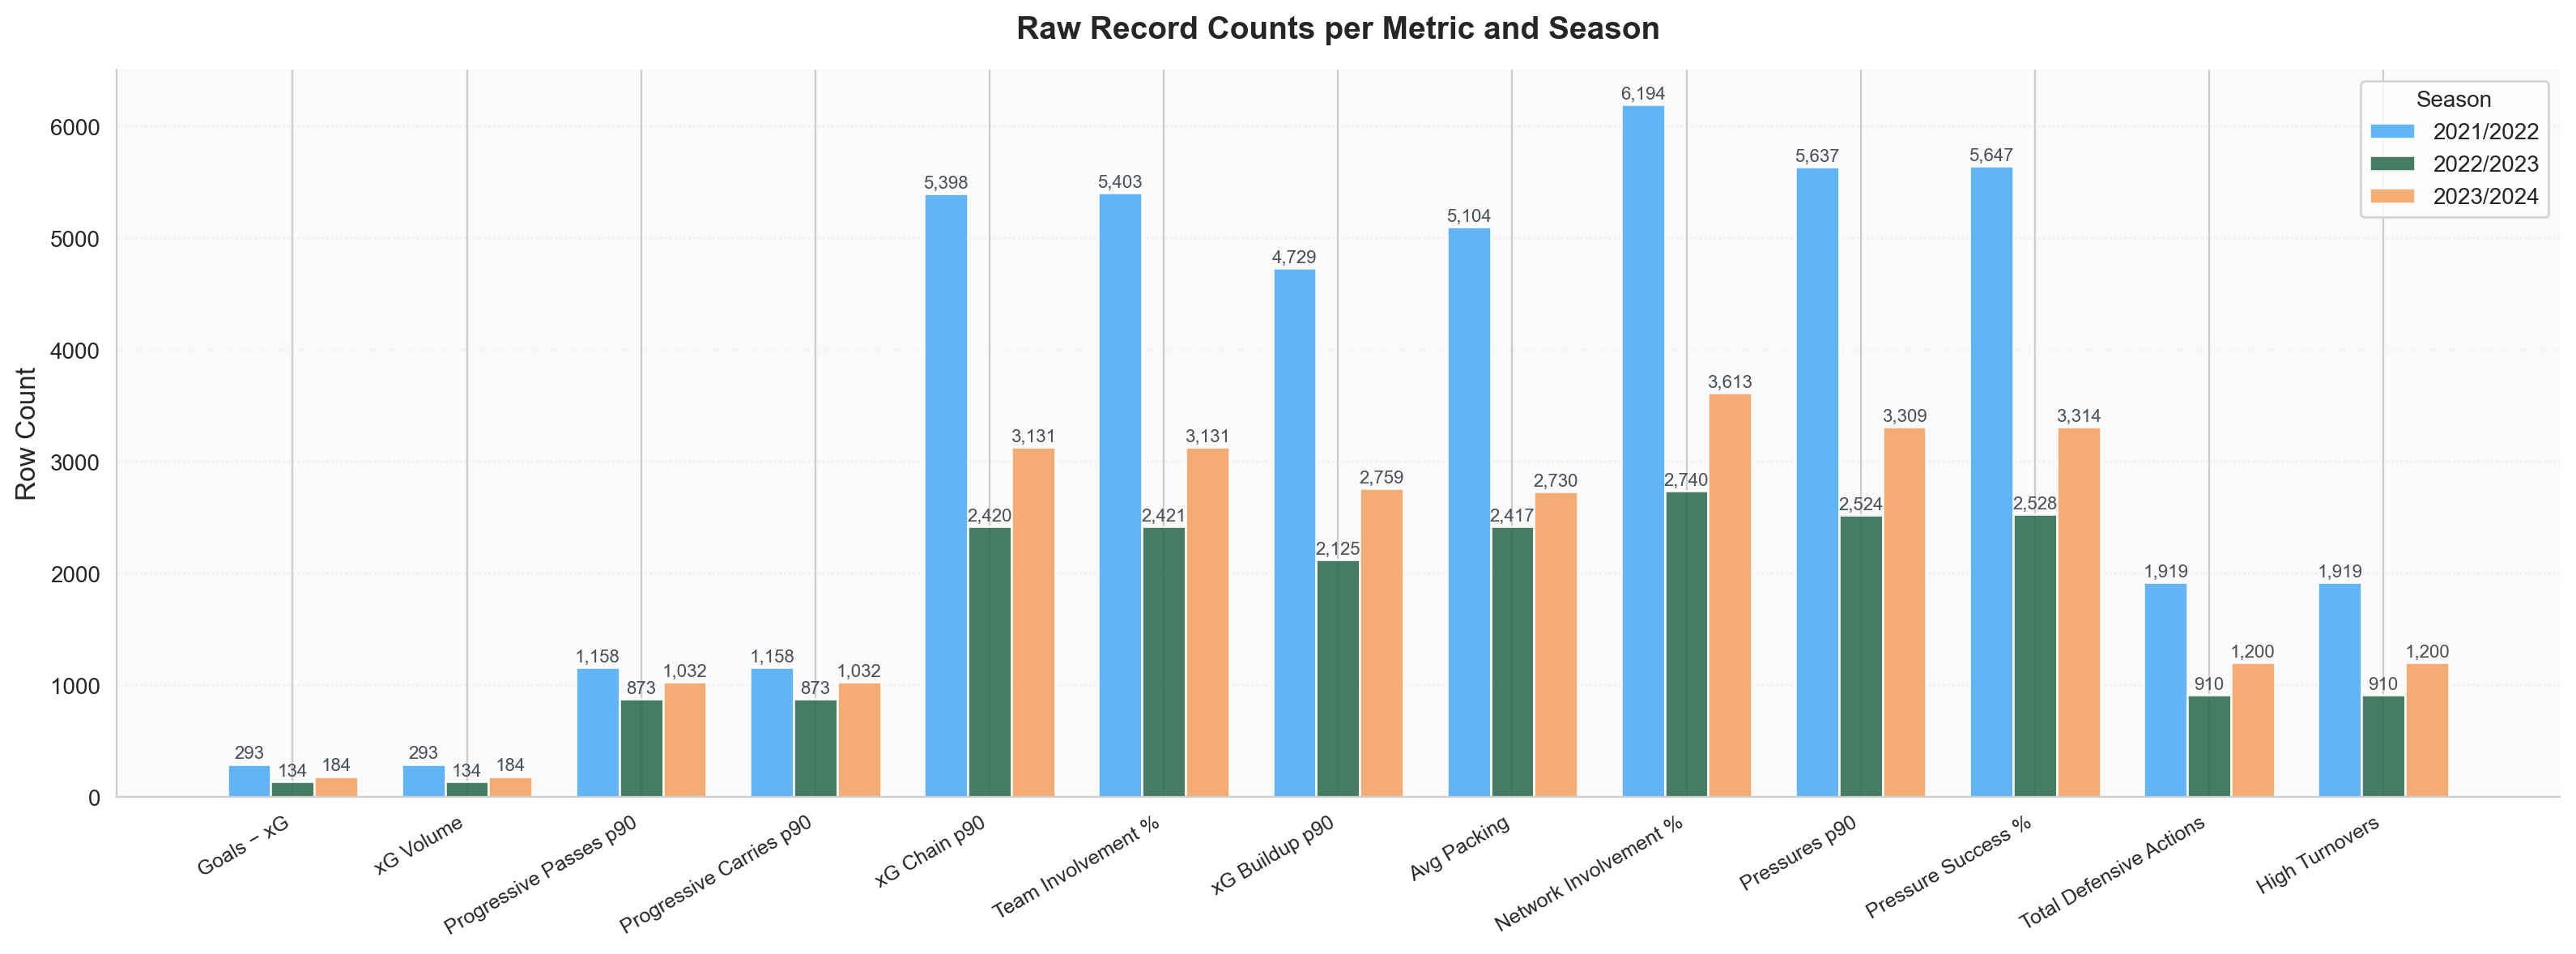

In [ ]:
player_raw_data = load_all_players() 
plot_row_counts(player_raw_data)

#### What Does the Record Count Distribution Chart Reveal?
The record count distribution across the three-season window confirms the structural 
health of the 12-metric player quality engine while surfacing key architectural 
considerations for the scoring pipeline.

The 2021/2022 season dominates record counts across every metric, peaking at 6,194 for 
Network Involvement % and 5,647 for Pressures p90. Without correction, this historical 
volume would numerically bias the model toward older performance patterns; precisely the 
risk the time decay architecture addresses. By downweighting 2021/2022 as the oldest 
season and prioritising 2023/2024, the pipeline ensures a player's most recent peak drives 
their 2026 quality score rather than their historical volume.

Three structural observations emerge from the coverage profile:

- **The Finishing Gap:** Goals − xG and xG Volume share the thinnest coverage in the 
pipeline, only 611 combined records each across all three seasons (293 / 134 / 184), 
reflecting that both metrics are sourced from the same file and capture only players who 
registered shots. This is expected: finishing metrics are inherently position-restricted. 
Both should be treated as high-signal, low-volume features requiring independent weighting 
and minimum appearance thresholds in the aggregation layer.

- **The High-Volume Core:** Network Involvement % (12,547 combined), Pressures p90 
(11,470) and Pressure Success % (11,489) provide the densest population coverage in the 
framework. xG Chain p90 (10,949) and Team Involvement % (10,955) follow closely. These 
five metrics form the statistical backbone of the pipeline; robust enough to anchor 
player scores even when finishing or defensive profile data is sparse.

- **The Mid-Tier Dimensions:** Progressive Passes p90, Progressive Carries p90 
(3,063 combined each), xG Buildup p90 (9,613), Avg Packing (10,251), Total Defensive 
Actions and High Turnovers (4,029 combined each) sit between the two extremes. The 
progression metrics are the thinnest non-finishing dimensions, likely reflecting stricter 
minimum minute thresholds filtering out squad-level players.

#### Implications for the Player Quality Scoring Pipeline

| Action | Technical Justification | Pipeline Outcome |
|--------|------------------------|-----------------|
|Time Decay Weighting|2021/2022 dominates raw volume across all 12 metrics but is the oldest season in the window.|Apply decay weights prioritising 2023/2024 > 2022/2023 > 2021/2022, ensuring recent peak performance drives 2026 quality scores.|
|Finishing Metrics as Independent Features|Goals − xG and xG Volume share only 611 combined records, a fraction of high-volume dimensions.|Weight both finishing metrics independently with minimum appearance thresholds; do not average directly with high-volume metrics.|
|Confidence Scaling|Coverage varies from 611 (finishing) to 12,547 (Network Involvement %) — a 20x range within the same pipeline.|Apply a per-dimension confidence scalar: scores derived from fewer records are shrunk toward positional means to prevent sparse-sample inflation.|
|Same-File Metric Pairs|Goals − xG / xG Volume, Pressures p90 / Pressure Success %, Total Defensive Actions / High Turnovers, and Progressive Passes / Carries share identical row counts, confirming shared file sourcing.|Treat same-file metric pairs as correlated features; check inter-metric correlation before assigning independent weights to prevent double-counting within the same tactical dimension.|

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.2.2 Inter-Metric Correlation & License to Retain

Saved: figures/player_metrics_corr.png


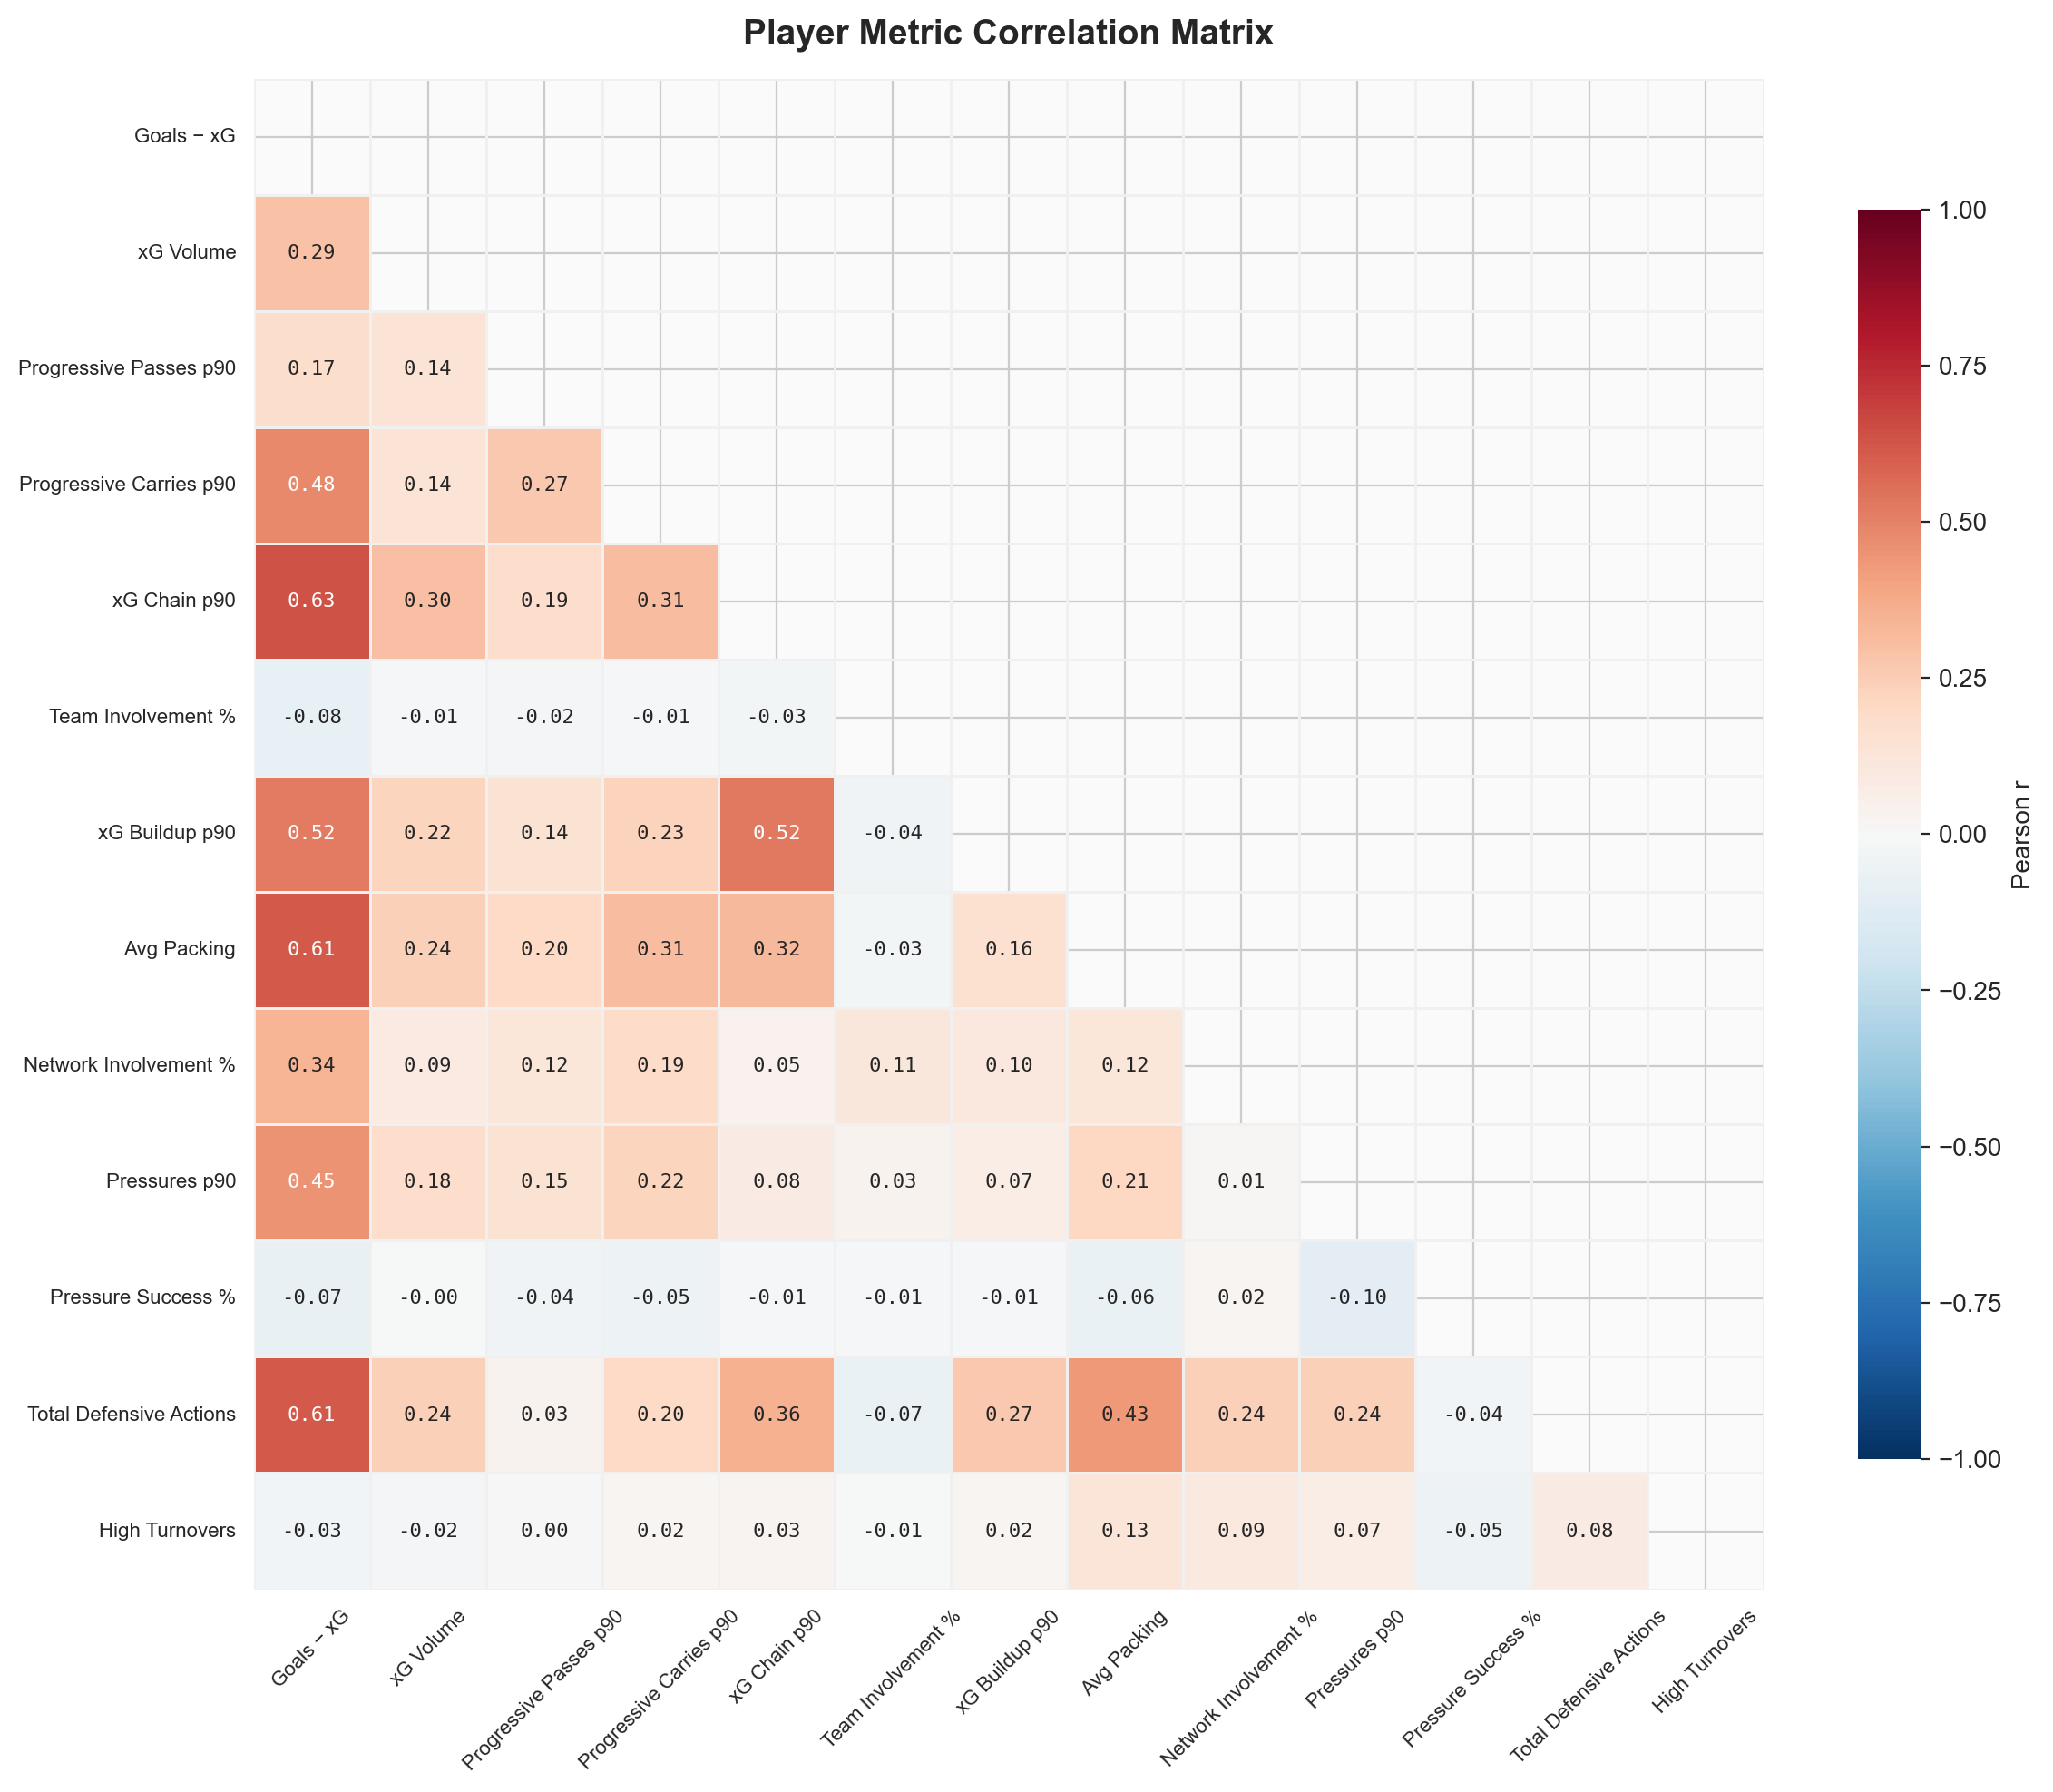

In [ ]:
plot_player_metric_correlations(player_raw_data)

#### What Does the Player Metric Correlation Matrix Reveal?
The correlation matrix serves as the "License to Retain" all 12 dimensions. With no pair 
exceeding r = 0.63, the framework clears the collinearity threshold comfortably, 
confirming that each metric brings genuinely independent information to the scoring model.

- **The Finishing Axis (Goals − xG):** The strongest relationships in the matrix radiate 
from Goals − xG: xG Chain p90 (0.63), Avg Packing (0.61), Total Defensive Actions (0.61), 
xG Buildup p90 (0.52), and Progressive Carries p90 (0.48). This confirms that finishing 
quality is not an isolated skill — it is systematically linked to players who are deeply 
embedded in attacking sequences, progressive ball-carrying, and overall defensive 
contribution. Elite finishers in this dataset are complete players, not specialists.

- **The Independence of Team Involvement %:** Team Involvement % is virtually uncorrelated 
with every metric in the framework, with its strongest relationship being a negligible 
−0.08 with Goals − xG. This is a critical finding: how frequently a player appears in 
their team's xG chains is entirely decoupled from how dangerous those chains are or how 
much the player contributes to other dimensions. It captures a pure "presence" signal 
that no other metric replicates.

- **The Independence of High Turnovers:** High Turnovers shows near-zero correlation 
across the entire matrix, peaking at only 0.13 with Avg Packing. This confirms that 
pressing success, winning the ball high up the pitch, is a specialized skill entirely 
independent of general defensive volume (Pressures p90), attacking involvement, or 
progression. It is the most orthogonal defensive metric in the framework.

- **The Pressure Paradox:** Pressure Success % is negatively correlated with Pressures 
p90 (−0.10) and near-zero with everything else. This confirms that pressing volume and 
pressing quality are genuinely independent dimensions; high-volume pressers are 
marginally less successful per press, and vice versa. Retaining both metrics is 
justified: they capture fundamentally different aspects of defensive intensity.

- **The xG Buildup / xG Chain Link:** xG Buildup p90 and xG Chain p90 share a moderate 
correlation of 0.52 — the highest between two non-finishing metrics. This is expected 
since both measure attacking sequence involvement, but the gap from 0.52 to 1.0 confirms 
they are not redundant. xG Chain captures final-third involvement while xG Buildup 
captures deeper build-up contribution — distinct phases of the same attacking process.

#### Implications for the Player Quality Scoring Pipeline

| Action | Technical Justification | Pipeline Outcome |
|--------|------------------------|-----------------|
|Full 12-Metric Retention|Maximum inter-metric correlation is 0.63, well below the 0.80 collinearity threshold.|All 12 dimensions are retained; no features dropped. Each brings statistically independent information to the scoring model.|
|Team Involvement % as Presence Signal|Correlation of −0.08 to 0.05 across all other metrics — the most orthogonal dimension in the framework.|Used as a standalone "structural presence" feature, not combined with xG Chain in weighted averages to avoid conflating frequency with quality.|
|High Turnovers as Specialist Filter|Near-zero correlation with all metrics including Pressures p90 (0.07) confirms it captures a distinct pressing skill.|Flagged as a specialist identifier. Used to surface high-press hunters who would otherwise be invisible in general defensive volume metrics.|
|Dual Pressure Metrics Justified|Pressures p90 and Pressure Success % are negatively correlated (-0.10), confirming they measure opposing dimensions of pressing.|Both retained with independent weights; combined into a "Pressing Profile" score rather than averaged, preserving the volume vs. quality distinction.|
|xG Chain and xG Buildup as Sequential Phases|Moderate correlation (0.52) confirms overlap but not redundancy; they capture different phases of the attacking sequence.|Weighted independently within the Final Third Output trait category, with xG Chain weighted higher for forwards and xG Buildup weighted higher for midfielders.|

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.2.3 Distribution of Core Metrics

Saved: figures/metric_distributions.png


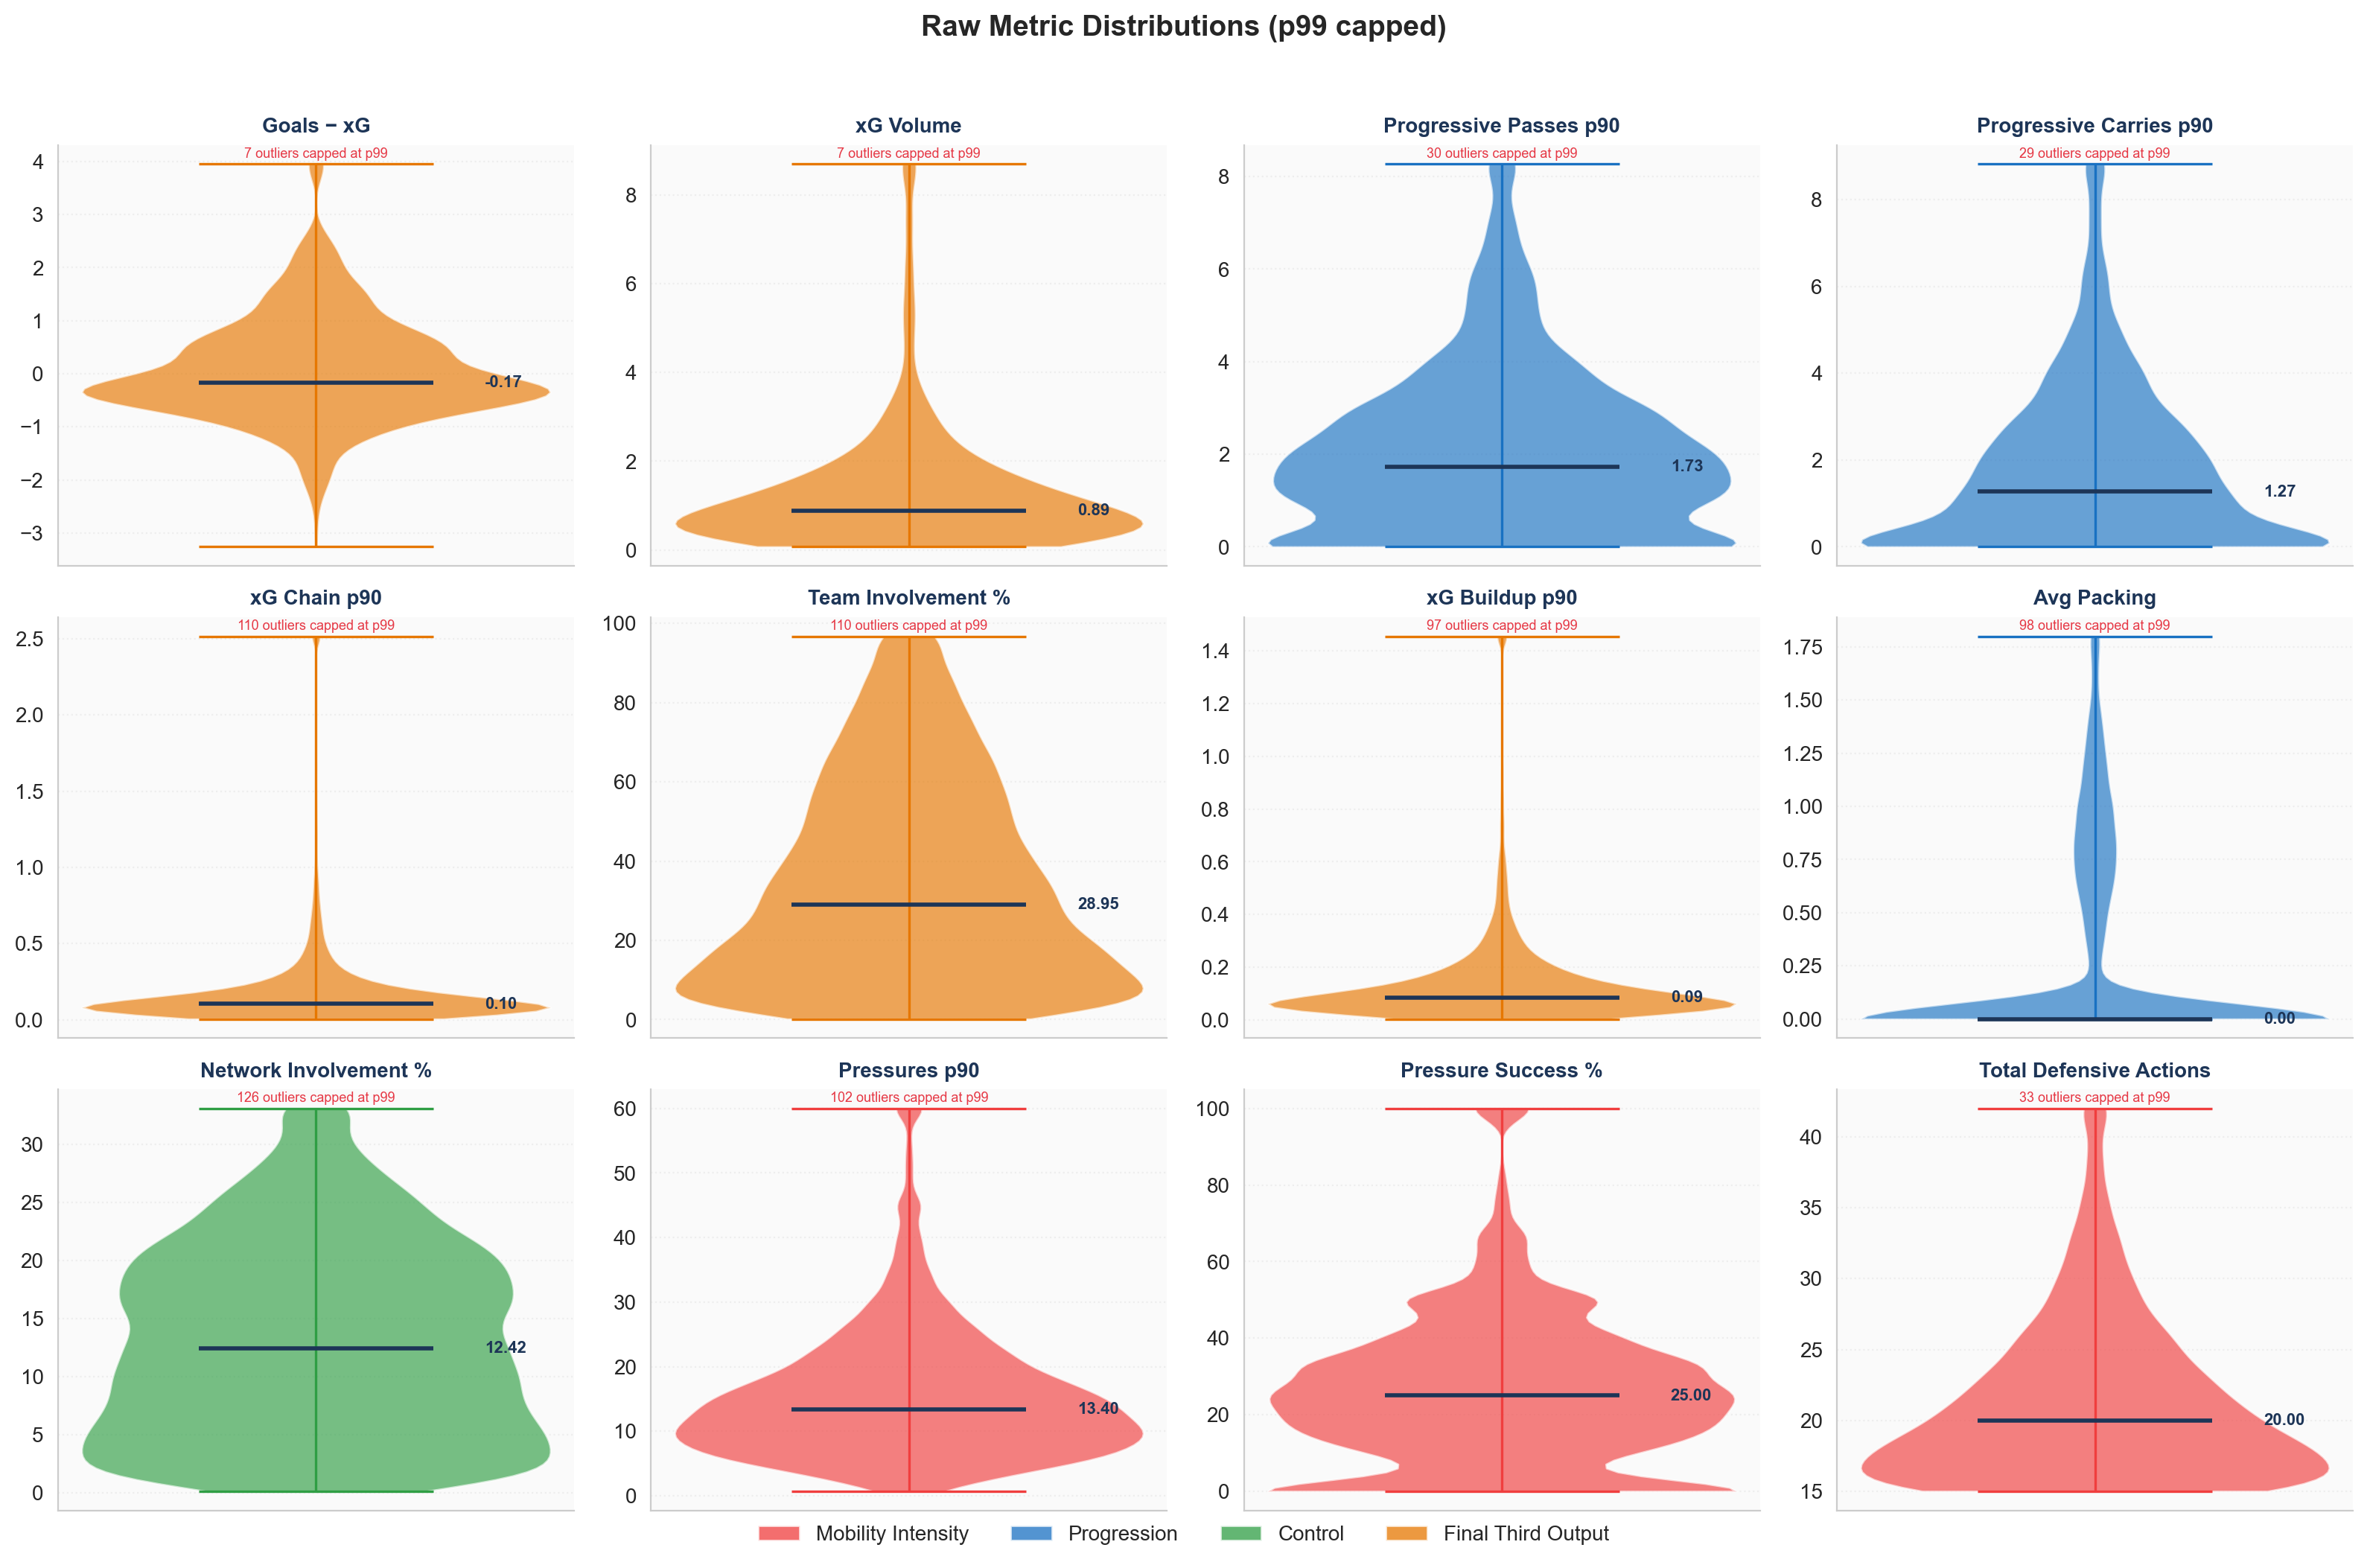

In [ ]:
plot_metric_distributions_pl(player_raw_data)

#### What Do the Distributions Reveal?

- **The Finishing Gap (Goals − xG & xG Volume):** Goals − xG shows a median of −0.17, 
confirming that the average player slightly underperforms their expected goals, the 
realistic baseline for a population that includes squad players and role players alongside 
elite finishers. xG Volume (median 0.89) is heavily right-skewed, confirming that 
high-volume shooting is a rare, tiered skill concentrated in a small elite. Both 
distributions are the thinnest in the pipeline by player count, reinforcing their 
treatment as high-signal, low-volume features requiring Bayesian shrinkage.

- **Progression as a Tiered Skill:** Progressive Passes p90 (median 1.73) and Progressive 
Carries p90 (median 1.27) both show right-skewed distributions with wide upper tails. 
Elite progression — whether through passing or carrying — is concentrated in a small 
fraction of the population, while the majority cluster near the lower end. The similar 
shape of both violins is consistent with their moderate correlation (0.27), confirming 
they capture related but distinct progression styles.

- **The Attacking Involvement Tier:** xG Chain p90 (median 0.10) and xG Buildup p90 
(median 0.09) show near-identical extreme right skews, tightly clustered near zero with 
long upper tails. This reflects the statistical reality that meaningful attacking sequence 
involvement is restricted to a small elite tier, with the majority of players making 
negligible per-90 contributions. Team Involvement % (median 28.95) presents a contrasting 
bell-shaped distribution, confirming it captures a fundamentally different signal;
presence frequency rather than attacking quality.

- **Avg Packing — The Zero-Inflation Problem:** Avg Packing shows a median of 0.00 with 
an extreme right skew. The mass of the distribution sits at zero, indicating that the 
majority of players in the dataset register no meaningful packing contribution per pass. 
This zero-inflation requires special handling in the scoring pipeline; direct averaging 
would suppress this metric's signal for the elite minority who do register meaningful 
values.

- **Network Involvement % — Structural Bimodality:** The bimodal shape of Network 
Involvement % (median 12.42) is the most distinctive distribution in the framework. The 
two peaks suggest a natural population split between peripheral squad players with low 
network centrality and structural "hub" players who anchor their team's passing 
architecture. This bimodality makes Network Involvement % the most powerful natural 
classifier in the pipeline.

- **The Pressing Duality:** Pressures p90 (median 13.40) shows a wide, relatively 
symmetric distribution, confirming it provides meaningful signal across the full player 
population regardless of position. Pressure Success % (median 25.00) shows a broader, 
flatter distribution concentrated between 0–50%, reflecting genuine variance in pressing 
quality across the dataset. Together these confirm the earlier correlation finding: volume 
and quality are independent dimensions of pressing identity.

- **Total Defensive Actions — The Narrow Elite:** Total Defensive Actions (median 20.00) 
shows a tight distribution with a compressed range (roughly 15-40 at p99), suggesting 
this metric is more uniformly distributed than the attacking dimensions. It serves as a 
reliable baseline defensive signal rather than an elite differentiator.

#### Implications for the Player Quality Scoring Pipeline

| Action | Technical Justification | Pipeline Outcome |
|--------|------------------------|-----------------|
|Bayesian Shrinkage on Finishing Metrics|Goals − xG and xG Volume are right-skewed with thin population coverage; high variance, low sample size.|Sparse finishing profiles shrunk toward positional means; prevents low-volume players from generating unreliable outlier scores.|
|Zero-Inflation Handling for Avg Packing|Median of 0.00 with extreme right skew. Direct averaging suppresses elite signal.|Apply a non-zero filter or log transformation before scoring; treat zero-packing players as "not applicable" rather than "low quality".|
|Network Involvement % as Natural Classifier|Bimodal distribution creates a natural population split without requiring external thresholds.|Use as a primary segmentation feature to separate structural hub players from peripheral options before applying other scoring dimensions.|
|Dual Pressing Metrics with Independent Weights|Pressures p90 is wide and symmetric (population-level signal); Pressure Success % is flatter and quality-driven.|Weight independently: Pressures p90 as a baseline defensive contribution score, Pressure Success % as an efficiency multiplier for high-volume pressers.|
|Right-Skew Normalisation for Attacking Metrics|xG Chain, xG Buildup, xG Volume, and both progression metrics all show extreme right skews.|Apply log or rank transformation before aggregation to prevent elite outliers from compressing the scoring range for the majority of the population.|

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.2.4 The 400-Minute Line: Minutes Played Distribution

Saved: figures/player_mins_dis.png


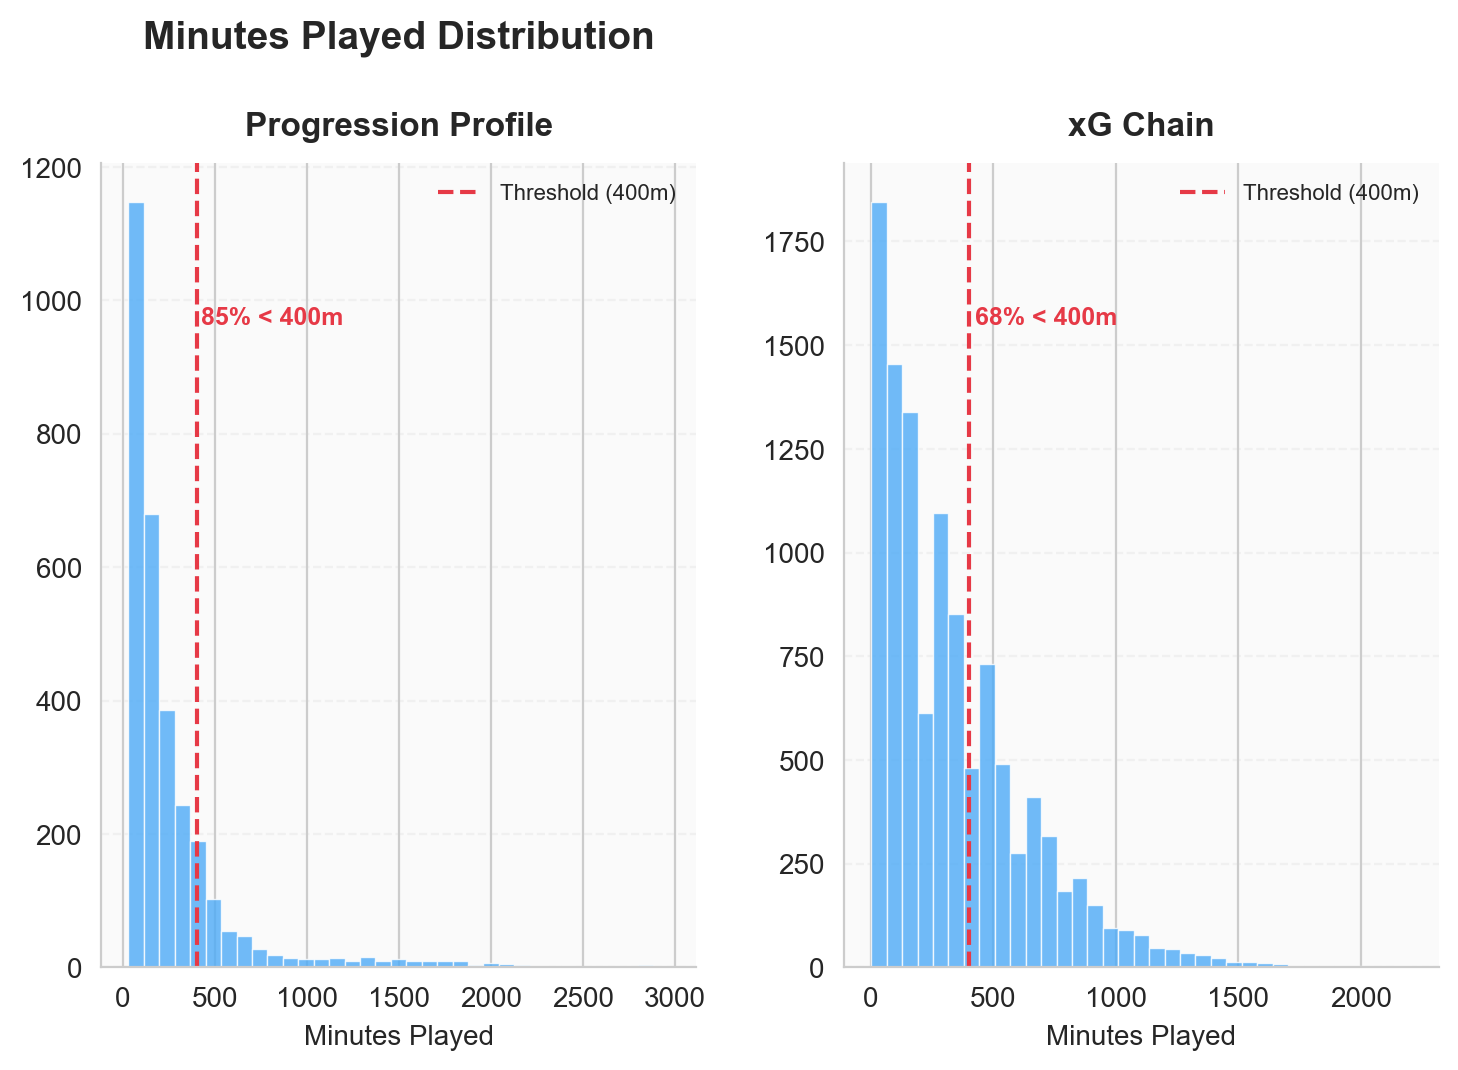

In [ ]:
plot_minutes_distribution(player_raw_data)

#### What Does the Minutes Played Distribution Reveal?

The minutes played distributions confirm a structural reality of club football datasets: 
the vast majority of registered players are squad-depth or rotational options who 
accumulate minimal playing time, creating a severe left-side concentration that directly 
shapes the minimum threshold decision.

- **The 400-Minute Threshold Rationale:** The 400-minute cutoff (roughly 4-5 full 
matches) filters out the most extreme low-minute tail while preserving a meaningful 
sample of consistent contributors. Critically, the threshold behaves differently across 
files: it eliminates 85% of the Progression Profile population but only 68% of the xG 
Chain population. This confirms that progression metrics skew toward specialist starters 
while attacking chain involvement captures a broader range of squad players.

- **The Long Tail of Starters:** Both distributions show a long right tail extending 
to 3,000+ minutes (Progression) and 2,000+ minutes (xG Chain), representing consistent 
first-team starters across full seasons. This elite minority is the primary population 
of interest for 2026 projection — players who have demonstrated sustained contribution 
at club level rather than sporadic appearances.

- **The Threshold Trade-off:** Setting the cutoff at 400 minutes is deliberately 
conservative. A higher threshold (e.g. 900 minutes — roughly 10 full matches) would 
produce cleaner, more reliable per-90 metrics but would further shrink an already thin 
population, particularly for finishing metrics. The 400-minute floor balances statistical 
reliability against population coverage.

#### Implications for the Player Quality Scoring Pipeline

| Action | Technical Justification | Pipeline Outcome |
|--------|------------------------|-----------------|
|400-Minute Minimum Threshold|85% of Progression and 68% of xG Chain records fall below 400 minutes; these players lack sufficient sample size for reliable per-90 metrics.|Filters out noise-dominated low-minute profiles while preserving rotational contributors who meet the minimum meaningful sample threshold.|
|File-Specific Threshold Sensitivity|The 400-minute cutoff removes a different proportion of players from each file. Progression metrics are more sensitive than chain metrics.|Monitor post-filter population sizes per file; if any dimension drops below viable sample size, consider file-specific thresholds rather than a universal cutoff.|
|Right-Tail Weighting via Time Decay|The long right tail represents multi-season starters; the highest-confidence profiles in the dataset.|Time decay amplifies the signal from these players' most recent seasons, ensuring consistent starters are scored on current form rather than historical accumulation.|

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.2.5 Player Archetype Map: Attacking vs. Playmaking 

  Latest season found: 2023_2024
Saved: figures/player_archetype_scatter.png


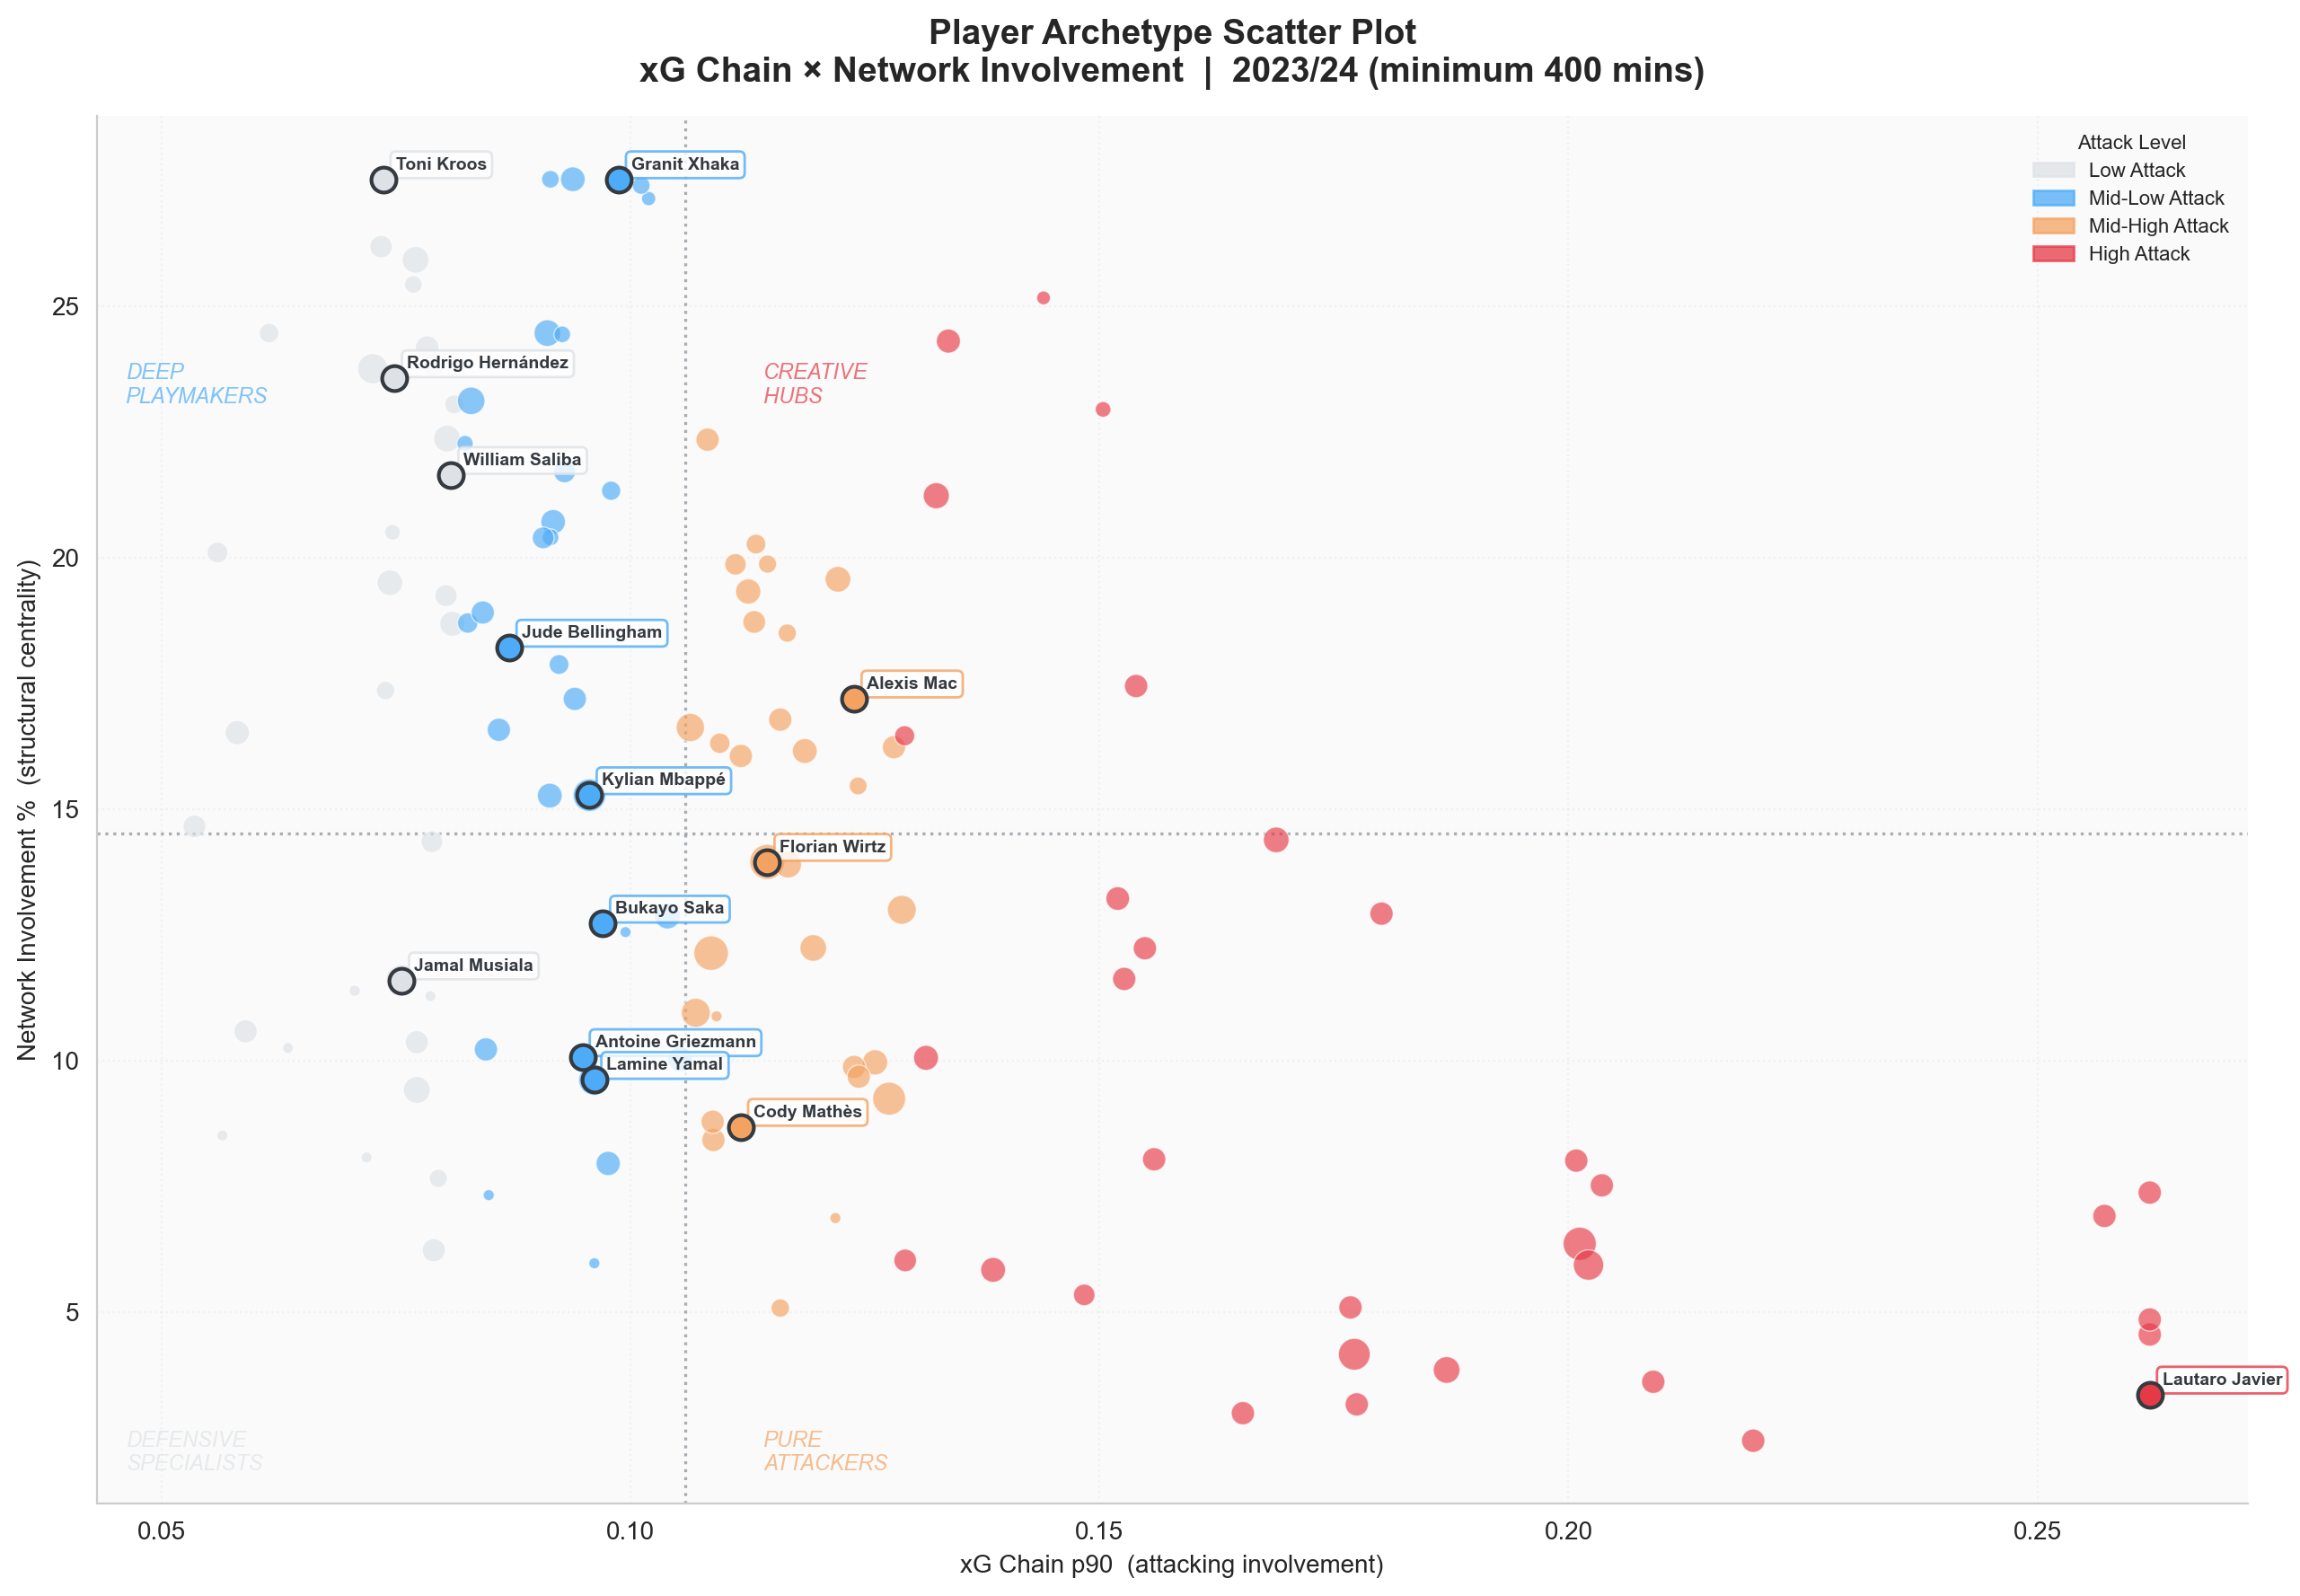

In [ ]:
player_data = {"recent_club_players": player_raw_data}
plot_player_archetype_scatter(player_data)

#### The Archetype-Specific Evaluation Model
The core methodological insight driving the player quality engine is the rejection of 
universal scoring in favour of positional economics. Traditional scouting metrics fail 
elite specialists by measuring all players against a single composite scale — a framework 
that inadvertently rewards mediocre generalists over world-class specialists. The 
structural reason is simple: players average 50–70 touches per match, making their 
"touch budget" zero-sum. Time spent anchoring a defensive midfield structure cannot be 
spent hunting shots in the penalty area. Our model treats this not as a limitation but 
as the defining logic of modern football.

#### Breaking the "Generalist Bias"
To ensure predictive accuracy for 2026, the scoring engine replaces composite averaging 
with an Archetype-Specific Weighting System. Players are evaluated strictly within their 
tactical cluster — eliminating the "Average Joe Trap" where a player who is mediocre 
across all dimensions outscores a world-class specialist in one.

The framework identifies four distinct archetypes, anchored by the inverse relationship 
between Network Involvement % (structural centrality) and xG Chain p90 (attacking threat):

- **Pure Attackers ("The Predators"):** High xG Chain (0.20+), low Network % (5–10%). 
Players like Lautaro Martínez operate at the top of the pitch to maximise shot volume, 
deliberately sacrificing possession recycling. Essential for teams with elite creators 
supplying the final pass.

- **Deep Playmakers ("The Metronomes"):** Elite Network % (18–28%), lower direct shot 
involvement. Players like Rodri and Granit Xhaka sacrifice individual statistical glory 
for structural stability, the invisible architecture that possession-based systems are 
built around.

- **Creative Hubs ("The Unicorns"):** Statistically rare players like Florian Wirtz or 
Alexis Mac Allister who occupy the high-intensity top-right quadrant, excelling in both 
creation and finishing simultaneously. Their rarity is mathematically inevitable: 
sustaining elite performance in both dimensions simultaneously demands an extreme 
combination of technical quality and physical output.

- **Defensive Specialists & Wide Outlets:** Players who provide tactical utility through 
pressing intensity, tracking, and positional discipline, often sacrificing personal 
statistical volume entirely in service of the team's defensive identity. Invisible in 
composite models, essential in context-aware ones.

#### Implications for the Player Quality Scoring Pipeline

The archetype framework translates directly into three pipeline decisions:

| Action | Technical Justification | Pipeline Outcome |
|--------|------------------------|-----------------|
| Intra-Archetype Percentiles | Comparing Rodri to Lautaro on a single 0–100 scale dilutes specialist excellence — Rodri's 90th-percentile network centrality is suppressed by his low shot count in a composite model. | Percentiles are calculated within each archetype group, ensuring world-class specialists are scored against their true peer group rather than a universal average. |
| Touch Budget Calibration | Modern knockout football rewards specialisation over generalism; a player who is elite in one dimension outperforms a player who is decent in two across the high-stakes, role-fixed environment of a World Cup. | "Elite in one dimension" is explicitly scored above "decent in two," reflecting the non-negotiable role requirements of tournament tactical systems. |
| 2026 Readiness Integration | A quality score divorced from team tactical identity produces theoretically accurate but practically useless rankings. Lautaro's score is only meaningful if his team is built to supply him. | Player archetypes are matched to team tactical clusters, transforming individual quality scores into system-fit scores that simulate how each player will actually function within their national team's 2026 structure. |

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.2.6 The Consistency Paradox: Quality vs. Reliability

Building on the spatial archetypes established in Section 2.5, this final analytical 
layer introduces the temporal dimension of player performance. Where Section 2.5 defined 
*where* a player operates, this section examines *how reliably* they perform over time — 
revealing a critical divide between match-to-match consistency and high-ceiling volatility 
that composite quality scores alone cannot capture.


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


  Latest season found: 2023_2024
Saved: figures/player_consistency.png


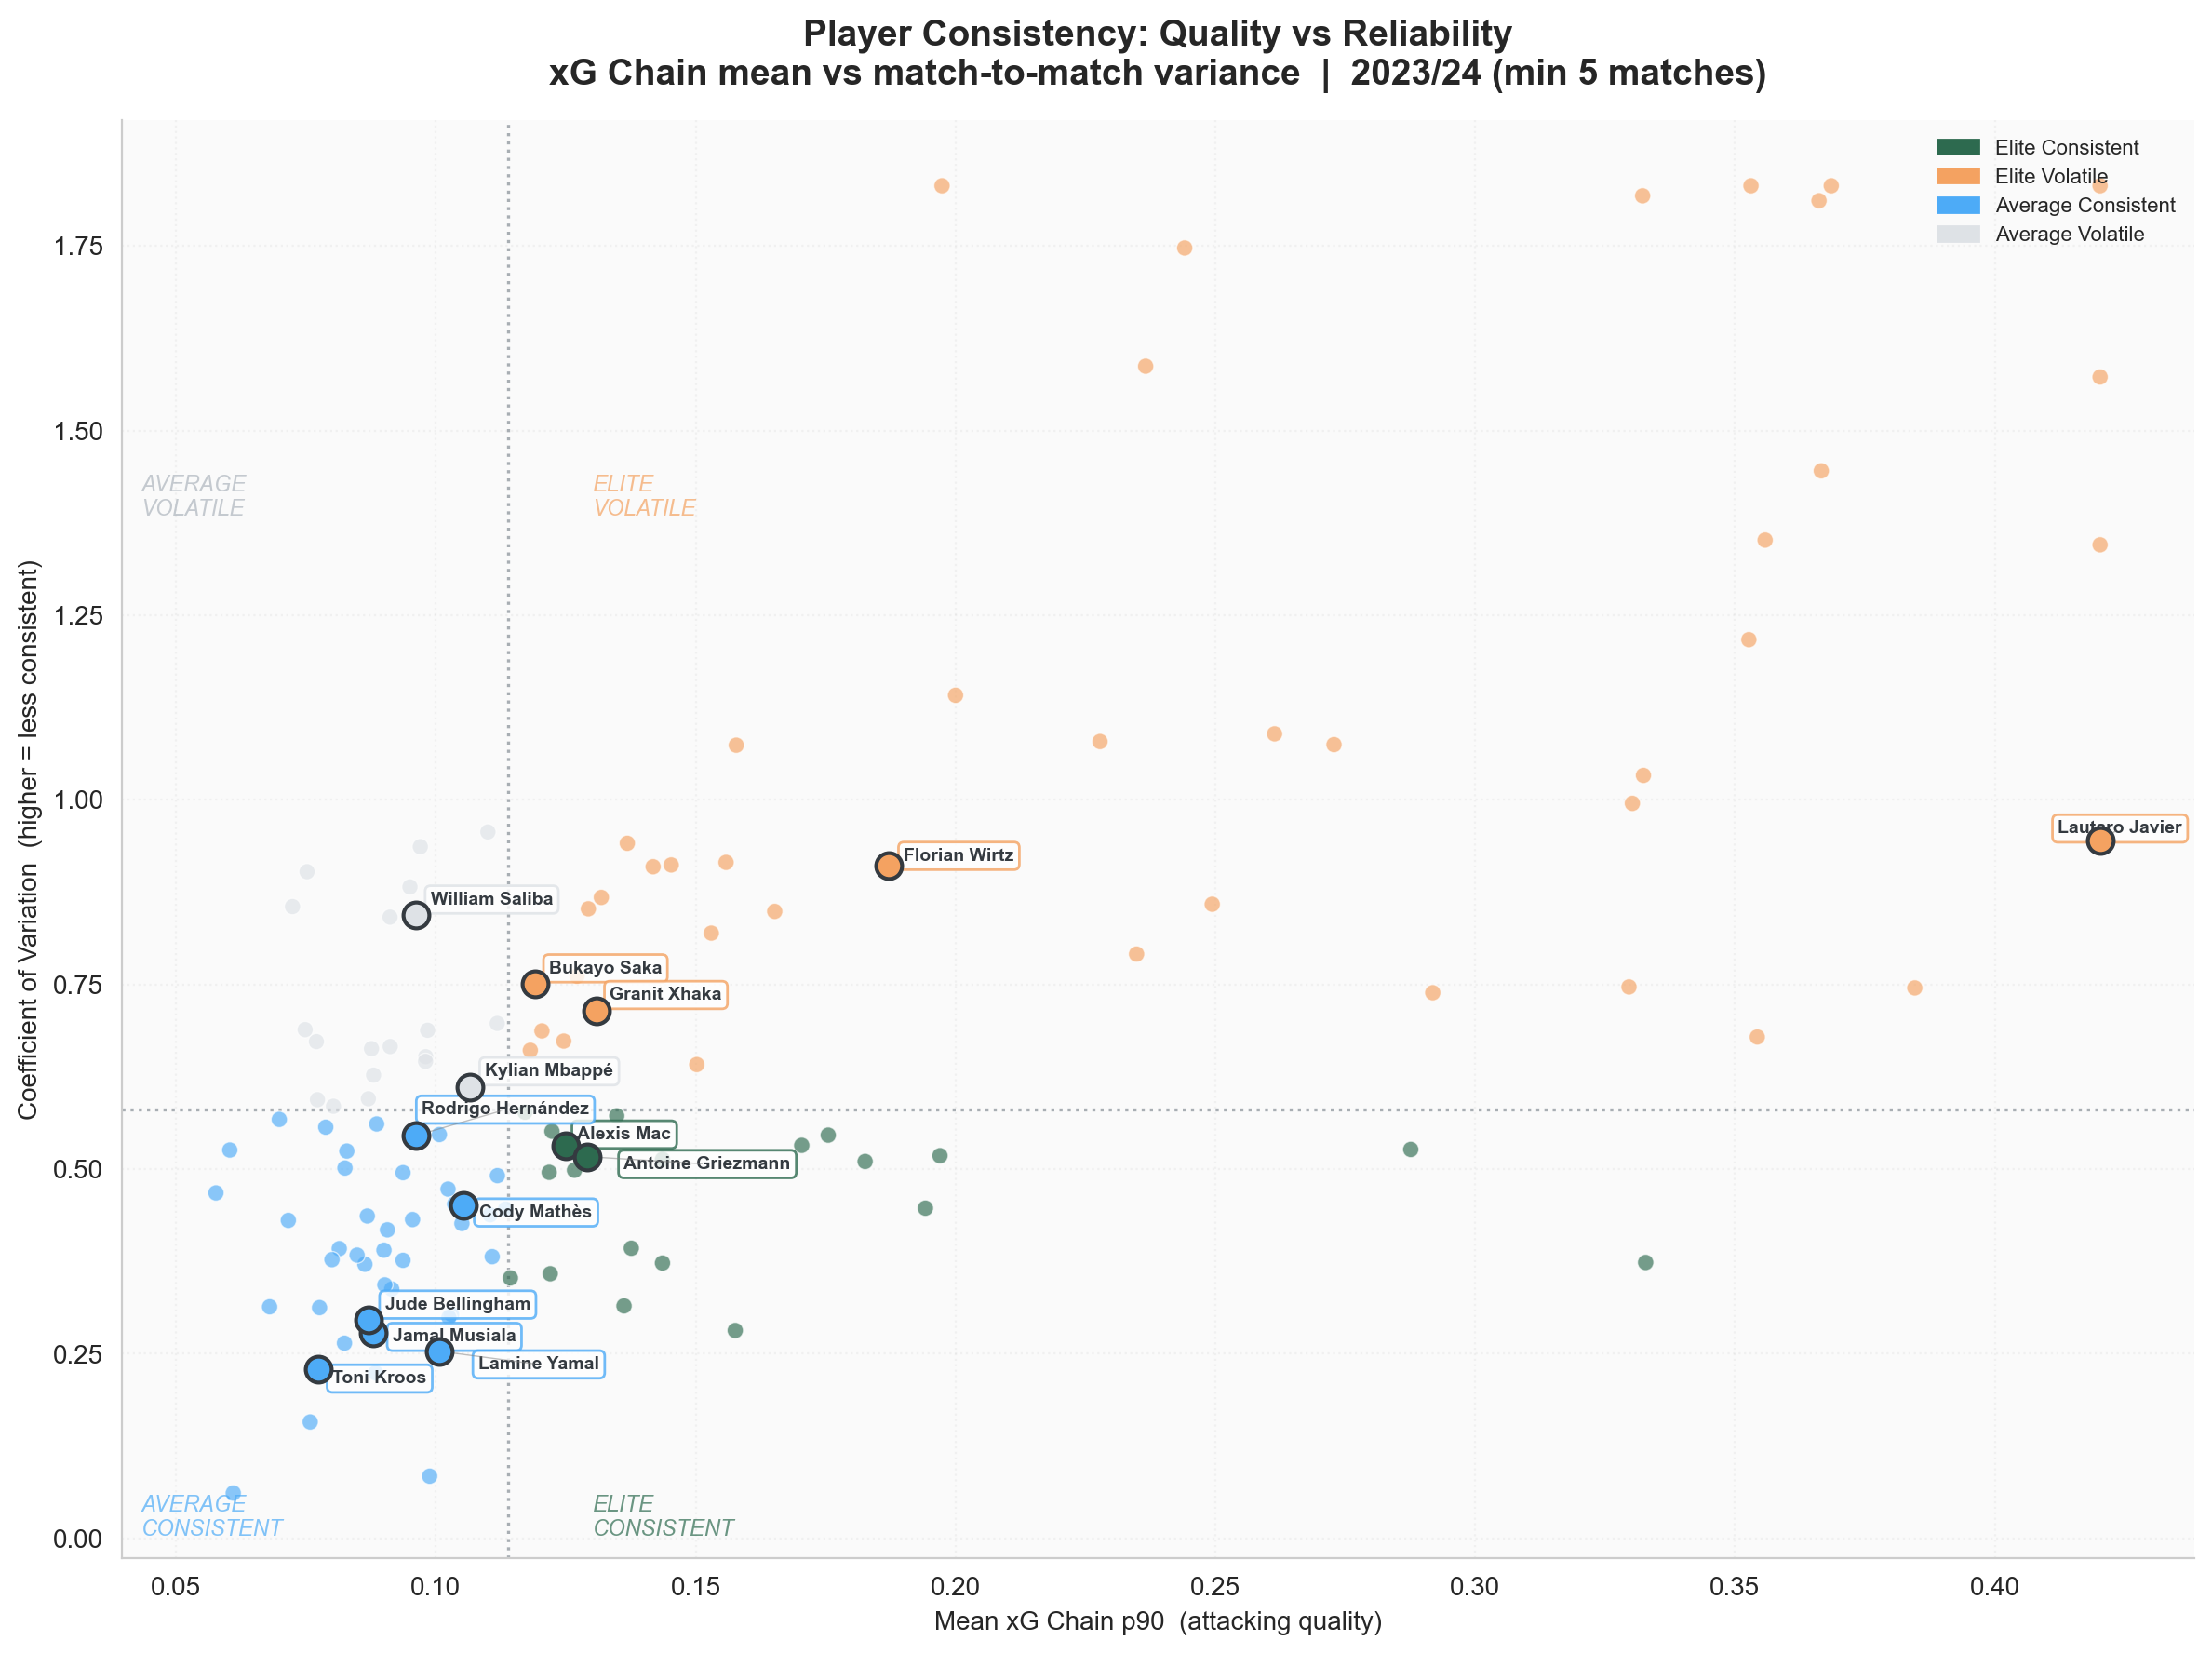

In [48]:
import analysis.player_metrics_eda
importlib.reload(analysis.player_metrics_eda)
from analysis.player_metrics_eda import *
plot_player_consistency(player_data)

#### The Two Layers of Specialisation
Elite player evaluation requires a dual-lens framework. Spatial Specialisation in the previous chart defines a player's zone of influence — Pure Attacker or Deep Playmaker. Temporal 
Specialisation in this chart defines their performance distribution — Elite Consistent 
or Elite Volatile. A player's true "Championship DNA" only becomes visible when both 
lenses are applied simultaneously.

#### The Four Performance Quadrants
Cross-referencing Coefficient of Variation (CV) against Mean xG Chain produces four 
distinct behavioural profiles:

- **Elite Consistent ("The Foundation"):** High mean performance, low match-to-match 
variance. Players like Lautaro Martínez deliver reliable output regardless of opposition 
or game state. Their value is tactical predictability; managers can build a primary 
strategy around them knowing the floor is guaranteed even at sub-peak fitness.

- **Elite Volatile ("The Match-Winners"):** High mean performance with large game-to-game 
swings. Players like Florian Wirtz attempt the high-difficulty dribbles and passes that 
break tactical stalemates; volatility is a feature of their profile, not a flaw. While 
they can disappear in structured matches, their ceiling performances are what separate 
tournament winners from semi-finalists.

- **Average Consistent ("The Metronomes"):** Moderate attacking threat with extremely low 
variance. Typical of Deep Playmakers, players like Toni Kroos or Rodri who maintain 
high network involvement naturally dampen statistical variance through sheer touch volume. 
They prevent system collapse and provide the stable platform that volatile creators 
require to operate effectively.

- **Average Volatile ("The Tactical Misfits"):** Below-average output with high 
inconsistency. Common in impact substitutes or positionally unsettled players who fail 
to build tactical automatisms within their system. Generally avoided as primary strategic 
assets — too unreliable to anchor a structure, too low-ceiling to justify the risk.

#### Strategic Application for 2026
The Consistency Paradox produces a clear squad-building implication: a roster composed 
entirely of consistent players lacks the explosive ceiling to win a World Cup, while a 
squad of purely volatile players lacks the structural stability to survive the group 
stage.

- **The Championship Formula:** A tournament-ready squad requires a Consistent Base 
(Average Consistent players providing structural reliability), a Consistent Finisher 
(Elite Consistent forward guaranteeing output), and Volatile Match-Winners (Elite 
Volatile creators deployed in knockout rounds to break tactical deadlocks).

- **Variance as a Feature, Not a Bug:** The scoring model does not penalise volatility. 
For knockout tournament formats, a high ceiling is explicitly valued. A player who 
scores 0.05 in six matches and 0.80 in two is more valuable in a single-elimination 
context than a player who scores 0.20 in every match. Variance is context-dependent, 
and the 2026 scoring engine treats it accordingly.

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.2.7 The Small Sample Illusion: Reliability vs. Noise
The final component of the evaluation engine addresses the "Super-Sub Paradox": why 
certain bench players appear statistically superior to established world-class starters. 
By plotting xG Chain per-90 against total minutes played, the model distinguishes between 
genuine elite quality and statistical noise generated by limited appearances; a 
distinction that conventional per-90 metrics systematically fail to make.

  Latest season found: 2023_2024
  Using season: 2023_2024
  xG Chain: 3131 records
  Player stats: 1087 players
Saved: figures/quality_minutes_scatter.png


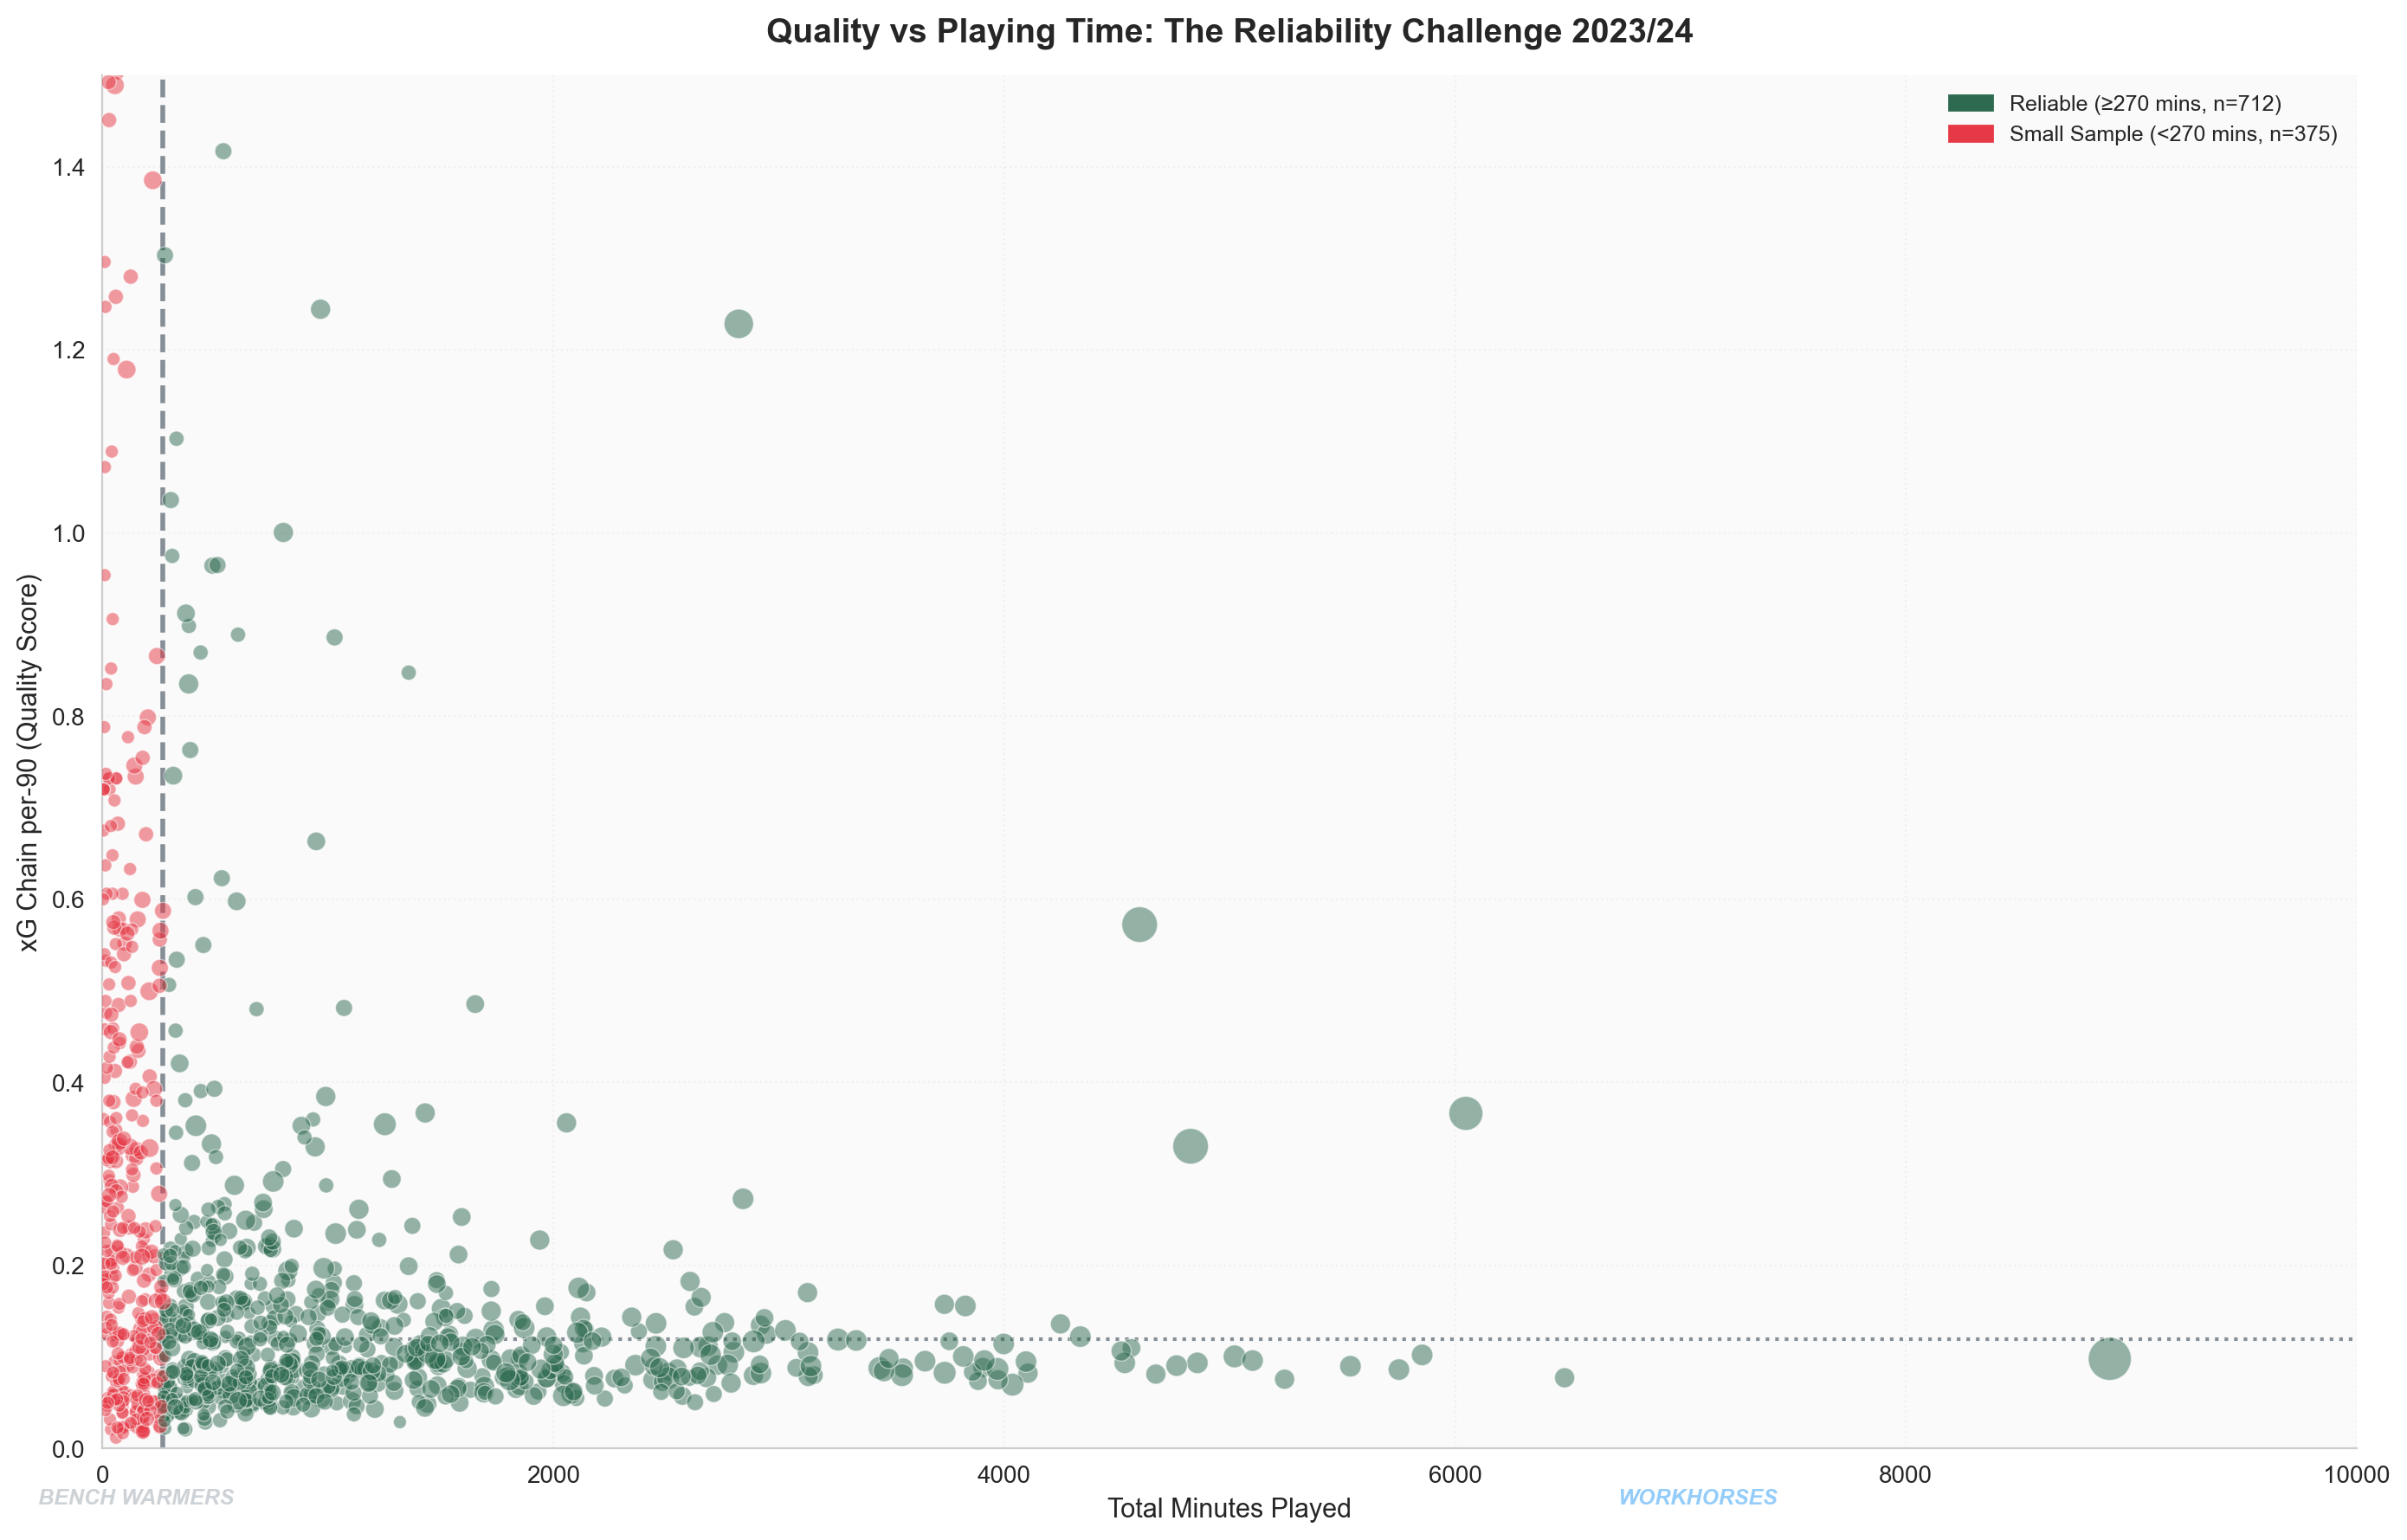

In [56]:
plot_quality_minutes_scatter(player_data)

#### The 270-Minute Threshold
The analysis identifies a critical reliability boundary at 270 minutes, approximately 
three full matches, that separates chaotic small-sample data from meaningful performance 
patterns.

- **The Red Zone (0–270 mins):** Extreme vertical scatter dominates this region, with 
xG Chain scores reaching 1.4+ per-90. These figures are almost always artifacts of 
"garbage time" contributions or fresh legs exploiting fatigued defenders — a single 
15-minute cameo mathematically extrapolated into an elite seasonal rate. High scores 
here are noise, not signal.

- **The Green Band (270+ mins):** As sample sizes grow, performance regresses toward 
sustainable levels. Order emerges: elite attacking football resolves into a tight 
horizontal band where even genuine top-tier attackers rarely sustain above 0.4–0.6 xG 
Chain across heavy minute volumes. The ceiling compresses precisely because the sample 
is large enough to absorb variance.

#### The Four Reliability Quadrants
Cross-referencing output quality against minute volume produces four distinct player 
classifications:

- **Super-Subs (High Output / Low Minutes):** Statistically impressive but structurally 
unproven. Scores are inflated by favorable contexts; late introductions against 
fatigued defences, set-piece cameos, or single decisive moments extrapolated across a 
full season. High ceiling, unknown floor.

- **Elite Starters (High Output / High Minutes):** The rarest classification in the 
dataset, fewer than 1% of players. These are the only profiles that demonstrate 
sustained high-quality output while absorbing adaptive marking, physical fatigue, and 
the full tactical complexity of a complete season. The primary target for 2026 
squad identification.

- **Workhorses (Low Output / High Minutes):** Essential system contributors with 3,000+ 
minutes but modest attacking figures. These are not poor attackers; they are defensive 
specialists and deep playmakers whose value is deliberately excluded from xG Chain. 
The model routes these profiles to defensive and network metrics rather than penalising 
them on attacking output.

- **Bench Warmers (Low Output / Low Minutes):** Limited minutes and limited impact, 
typically unproven academy prospects or deep rotation options with insufficient evidence 
to generate a reliable quality score in either direction.

#### Implications for the Player Quality Scoring Pipeline
| Action | Technical Justification | Pipeline Outcome |
|--------|------------------------|-----------------|
| Bayesian Shrinkage Below 270 Minutes | A single high-leverage cameo mathematically extrapolated into a per-90 rate carries the same raw score as a full-season elite starter, making sub-threshold scores statistically indistinguishable from genuine quality signals. | Player scores below 270 minutes are shrunk toward the positional mean, treating sub-threshold profiles as prior estimates rather than confirmed quality signals. Impact substitutes cannot outrank consistent starters on noise alone. |
| Role-Adjusted Metric Routing | High minutes paired with low xG Chain is a positional identifier, not a performance failure. Defensive specialists and deep playmakers are structurally excluded from attacking output metrics by their role, not their quality. | Workhorse profiles are automatically re-routed to defensive actions, pressing volume, and network centrality as primary scoring dimensions, preventing the model from misclassifying elite defensive contributors as poor attackers. |
| Elite Starter Prioritisation for 2026 | Tournament football compresses the margin for error; a player who produces elite output across a full club season has demonstrated the sustainability, adaptability, and resilience that a World Cup demands across 7 matches in 32 days. | The model explicitly weights Elite Starter profiles as the highest-confidence 2026 inputs, ensuring squad projections are anchored by players with proven volume-adjusted quality rather than small-sample outliers. |

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.2.8 Synthesis: Key Insights & Modeling Implications
The exploratory analysis across six visualizations — record counts, 
correlation matrix, metric distributions, positional archetypes, consistency profiling, 
and reliability thresholds — converges on a coherent picture of modern player evaluation 
and provides a statistically grounded blueprint for the quality scoring phase ahead.

#### The Counterintuitive Findings
Three findings stand out as genuinely surprising:
1. **Finishing metrics are the most concentrated yet independent dimensions** in the 
framework. Goals − xG and xG Volume share a surprisingly low correlation of 0.29,
confirming that shooting volume and finishing quality are more decoupled than conventional 
scouting assumes. A prolific shooter is not automatically an efficient finisher, and an 
elite finisher does not need to be a high-volume shooter. Both signals are restricted to 
a thin specialist subset (611 combined records), requiring explicit Bayesian shrinkage to 
prevent small-sample noise from distorting scores for low-volume forwards.
2. **Team Involvement % is the most orthogonal metric in the framework**, showing 
near-zero correlation with every other dimension including xG Chain (-0.03). A player 
can appear in virtually every attacking sequence their team creates and still generate 
negligible xG, confirming that presence and danger are entirely decoupled signals that 
must be scored independently.
3. **The Avg Packing "Golden Rule":** Unlike other right-skewed metrics where the 
primary risk is outlier inflation, Avg Packing presents the inverse problem — 
zero-inflation. With a median of 0.00, standard normalisation compresses the 
entire meaningful signal into the top percentiles, making elite line-breaking 
passers statistically indistinguishable from players who simply never attempt 
progressive passes. A log transformation or non-zero filter must be applied 
before any scaling step. Without it, "Architect" profiles will be 
systematically undervalued, and the model will fail to identify one of the 
most tactically valuable player types in the 2026 context.

#### The Player Quality Story Heading into 2026
The data points toward a fundamental tension in squad construction. On one side, 
**"Elite Consistent"** profiles (players like Lautaro Martínez who deliver reliable 
output across every match state) provide the structural guarantee that group stage 
survival requires. On the other, **"Elite Volatile"** profiles (players like Florian 
Wirtz whose upper-tail performances break tactical deadlocks) provide the ceiling that 
knockout tournaments demand. The 48-team expansion amplifies this tension: more 
single-elimination matches mean more moments where a 1.0 xG Chain performance wins a 
tournament, and more group stage matches where consistent floors prevent early exits.
The critical 2026 question the scoring phase must answer is whether national team squads 
have **both profiles represented** — or whether they are structurally dependent on one 
archetype and exposed when the format demands the other.

#### The Scoring Pipeline Implications
Six decisions flow directly from the analysis:
1. The **12-metric framework is confirmed as non-redundant**, with a maximum 
inter-metric correlation of 0.63, well below the collinearity threshold, justifying full 
feature retention across all dimensions.
2. **Bayesian shrinkage** must be applied to Goals − xG and xG Volume given their thin 
population coverage (611 combined records) and extreme right skew; sparse finishing 
profiles must be pulled toward positional means before aggregation.
3. **Avg Packing requires zero-inflation handling.** A log transformation or non-zero 
filter must be applied before scoring to prevent the zero-mass majority from suppressing 
the elite minority's signal.
4. **Intra-archetype percentiles** replace universal composite scoring. Players are 
ranked within their spatial cluster (Pure Attacker, Deep Playmaker, Creative Hub, 
Defensive Specialist) to eliminate generalist bias and reward world-class specialisation.
5. **The 270-minute reliability threshold** gates all per-90 metrics. Sub-threshold 
scores are treated as prior estimates and shrunk toward the mean, preventing small-sample 
noise from inflating impact substitute profiles above proven starters.
6. **Time decay** prioritises 2023/2024 data across all 12 dimensions, correcting for 
the 2021/2022 volume dominance that would otherwise bias scores toward historical 
patterns rather than current peak performance.

⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯

### 2.3 Closing the Engineering Loop: From Raw Events to Readiness Intelligence

TThe metric engineering layer documented in this section has transformed 12.2 million raw 
event logs — supplemented by StatsBomb 360 spatial tracking data for line-breaking 
quality measurement — into two independent evidence streams, each validated, 
non-redundant, and calibrated for the specific demands of 2026 tournament prediction.

The **team-level tactical framework** (8 metrics, 2022–2024) has confirmed four 
empirically distinct archetypes that will anchor the clustering phase: Proactive Dominant, 
Possession-Adaptive, Elite Pragmatist, and Tactically Rigid. The distribution analysis, 
correlation audit, scatter plots, quadrant outcomes, radar profiles, and volatility 
mapping collectively establish that these archetypes are genuine tactical identities — 
not statistical artifacts — and that the global scaler, k=4 cluster hypothesis, and 
standard deviation features are statistically defensible pipeline decisions rather than 
arbitrary choices.

The **player-level quality framework** (12 metrics, 2021–2025) has confirmed that elite 
player evaluation requires four simultaneous corrections that conventional scouting 
ignores: positional economics (intra-archetype percentiles), temporal reliability 
(270-minute threshold and Bayesian shrinkage), zero-inflation handling (Avg Packing log 
transformation), and volatility tolerance (Elite Volatile profiles valued for their 
ceiling, not penalised for their variance). Together, these corrections ensure the quality 
score reflects tournament-relevant performance rather than volume-biased career averages.

What this section has not yet answered is the synthesis question posed in the Overview: 
**do these two evidence streams converge on the same teams?** Do the nations that cluster 
as "Proactive Elite" tactically also carry the player quality to execute that identity 
under knockout pressure? And do the "Elite Pragmatists" — Morocco, Japan, France — 
possess the individual ceiling to repeat their 2022 performances in a 48-team field 
where the margin for a single bad match has narrowed further?

Those questions are addressed in **Section III: Tactical Clustering & Squad Readiness 
Scoring,** where the two engineering streams are synthesised into a single, auditable 
Readiness Score per national team — the structured, reality-grounded assessment of which 
48 squads are best positioned to compete, and why.

In [ ]:
# Setup
#%pip install mymodule
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

import sys
import importlib
# Add analysis folder to Python path (local folder)
sys.path.insert(0, str(Path.cwd() / 'analysis'))

# Define paths (all relative to eda folder)
DATA_DIR = Path("..") / "data" / "Statsbomb"
PROCESSED_DIR = Path("processed")
FIGURES_DIR = Path("figures")

# Import custom modules
from data_loader import load_tournament_data_8d, load_player_data_for_scoring
from profile_builder import build_team_profile_8d
from clustering_analysis import TacticalClustering
from visualization import (
    plot_clustering_validation_compact,
    save_figure,
    plot_tactical_pca,
    plot_archetype_radars,
    plot_comparison_pizzas
)
from trait_mapper import map_dimensions_to_traits, print_trait_mapping_table, print_archetype_traits_table
from success_analyzer import calculate_archetype_success, print_success_table, print_key_findings
from player_quality_scorer import PlayerQualityScorer
from rosters_2026 import rosters_2026
from club_mapping_2026 import CLUB_MAPPING_2026
from player_positions import POSITION_OVERRIDES
from system_fit_engine import run_system_fit_engine

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Create output directories
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Setup complete")

Setup complete


In [ ]:
# Load tournament metrics
from data_loader import load_tournament_data_8d, load_player_data_for_scoring
metrics = load_tournament_data_8d('men_tourn_2022_24', verbose=False)
# Build 8-D profiles
tournament_profiles = build_team_profile_8d(metrics, verbose=False)
tournament_profiles_pd = tournament_profiles.to_pandas()
tournament_profiles.write_csv('./processed/tournament_profiles_8d_2022_24.csv')
tournament_profiles.head(5)

shape: (5, 9)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ team     ┆ pressing_ ┆ territori ┆ ball_cont ┆ … ┆ defensive ┆ attacking ┆ progressi ┆ buildup_q │
│ ---      ┆ intensity ┆ al_domina ┆ rol       ┆   ┆ _position ┆ _threat   ┆ on_style  ┆ uality    │
│ str      ┆ ---       ┆ nce       ┆ ---       ┆   ┆ ing       ┆ ---       ┆ ---       ┆ ---       │
│          ┆ f64       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ f64       ┆ f64       ┆ f64       │
│          ┆           ┆ f64       ┆           ┆   ┆ f64       ┆           ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Guinea   ┆ 0.097982  ┆ 18.882    ┆ 49.598    ┆ … ┆ 1.4336    ┆ 1.0788    ┆ 1.457627  ┆ 0.1618    │
│ Mali     ┆ 0.175994  ┆ 19.636    ┆ 57.796    ┆ … ┆ 1.4368    ┆ 1.1704    ┆ 2.5       ┆ 0.0652    │
│ Uruguay  ┆ 0.123136  ┆ 26.124444 ┆ 50.774444 ┆ … ┆ 1.453111  ┆ 2.019667  ┆ 1.584507  ┆ 0.117     │
│ Cameroon ┆ 0.121994  ┆ 26.777143 ┆ 51.671429 ┆ … ┆ 1.420571  ┆ 0.837429  ┆ 1.415094  ┆ 0.077     │
│ Wales    ┆ 0.100033  ┆ 18.88     ┆ 46.16     ┆ … ┆ 1.359333  ┆ 0.739667  ┆ 1.892857  ┆ 0.051     │
└──────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

## Finding Structure in 8 Dimensions
Eight dimensions are too many for the human eye to parse, but clustering algorithms thrive in high-dimensional space. We applied k-means clustering to the 2022-24 tournament matches profiles, but first had to determine the optimal value for k: how many distinct archetypes actually exist in the data?

Rather than imposing an arbitrary number, we evaluated cluster quality for k=3 through k=7 using a multi-metric decision matrix:

- Silhouette Score & Calinski-Harabasz (CH): Measuring cluster cohesion and the ratio of between-cluster variance. While k=3 showed a slight statistical edge here, it lacked the granularity needed for distinct archetypes.

- Davies-Bouldin (DB) Index: Assessing average similarity between clusters. We observed a significant improvement as we moved from k=3 (1.42) to k=4 (1.33), indicating better-defined separation.

- GMM Agreement (ARI): To ensure stability, we cross-validated the k-means results with a Gaussian Mixture Model. The jump in agreement from k=3 (0.32) to k=4 (0.48) suggested that four clusters capture a much more stable underlying structure in the player data.

While k=3 achieved higher silhouette score (0.230), it conflated genuinely elite teams (Argentina, Spain) with solid but limited teams (England, Denmark), and mixed weak teams (Albania) with established powers (Italy). We selected k=4 (silhouette=0.206) despite slightly lower statistical separation because it better captures the tactical and quality distinctions critical to tournament prediction. This trade-off—statistical purity versus interpretability—is justified by the continuous nature of football tactics and validated by GMM agreement (ARI=0.482).

Saved: figures/cluster_optimization.png


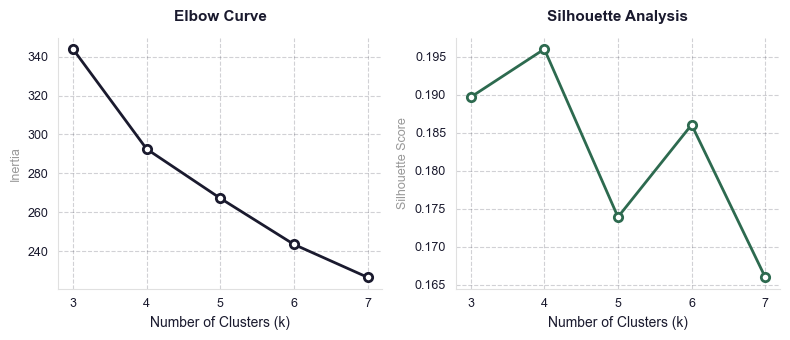


K-SELECTION: TACTICAL IDENTITY CONVERGENCE
k    Inertia    Silhouette   Calinski     DB Index     GMM ARI     
     ↓          ↑            ↑            ↓            ↑           
------------------------------------------------------------------------------------------
3    344        0.190        22.16 *      1.503        0.373       
4    293        0.196 *      21.03        1.441        0.346       
5    267        0.174        18.57        1.529        0.640 *     
6    244        0.186        17.32        1.376 *      0.304       
7    227        0.166        16.07        1.430        0.350       

Running K-means (k=4)...

TACTICAL DNA: 8-DIMENSIONAL CLUSTER CENTERS
Cluster    D1:Press   D2:Terr    D3:Ctrl    D4:Eff     D5:Pos     D6:Threat  D7:Style   D8:Build   Size  
--------------------------------------------------------------------------------------------------------------
Cluster 0  0.082      22.62      44.07      0.0196     1.349      1.186      1.648      0.1203     n=

In [ ]:
tournament_profiles_pd = tournament_profiles_pd.sort_values('team').reset_index(drop=True)

dimensions = [
    'pressing_intensity', 'territorial_dominance', 'ball_control',
    'possession_efficiency', 'defensive_positioning', 'attacking_threat',
    'progression_style', 'buildup_quality'
]
clusterer = TacticalClustering(dimensions)
scaled_data = clusterer.prepare_data(tournament_profiles_pd)

optimization_results = clusterer.optimize_k(k_range=range(3, 8))
fig, axes = plot_clustering_validation_compact(optimization_results)
save_figure(fig, 'cluster_optimization.png')
plt.show()

clustering = TacticalClustering(dimensions)
clustering.prepare_data(tournament_profiles_pd)
k_results = clustering.print_k_comparison(k_range=range(3, 8))

print("\nRunning K-means (k=4)...")
clustering_results = clusterer.run_kmeans(k=4, random_state=42)

tournament_profiles_pd['cluster'] = clustering_results['labels']
cluster_centers = clustering_results['centers']

cluster_centers['size'] = tournament_profiles_pd['cluster'].value_counts().sort_index().values

clusterer.render_tactical_dna(clustering_results)

Saved: figures/archetype_radars.png


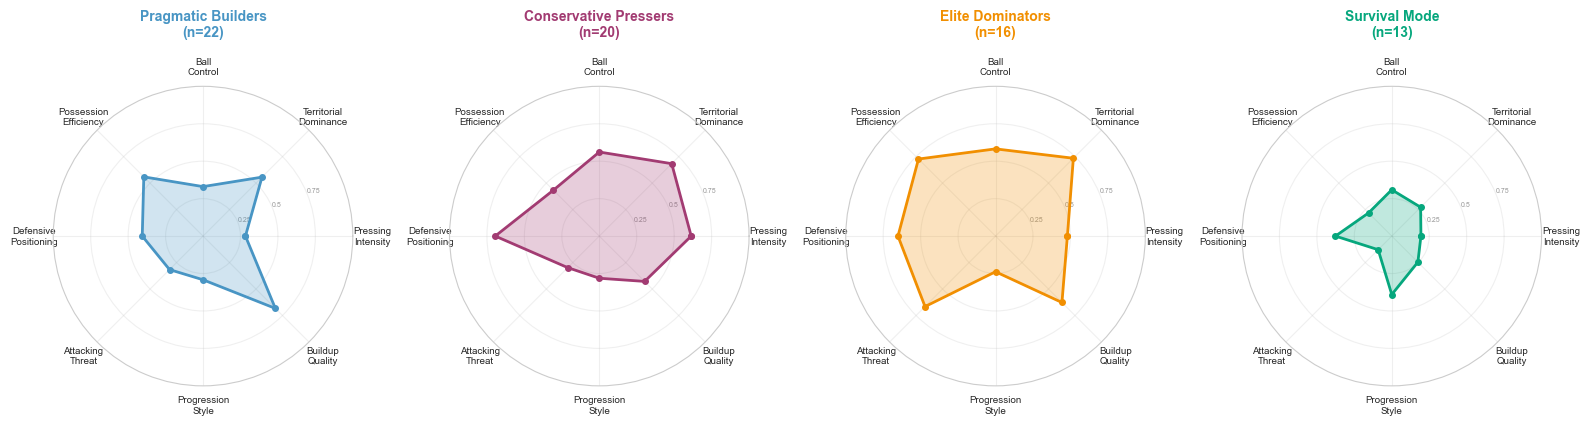

In [ ]:
# Define archetype names
archetype_names = {
    0: "Pragmatic Builders",
    1: "Conservative Pressers",
    2: "Elite Dominators",
    3: "Survival Mode"
}

characterization = clusterer.characterize_archetypes(
    tournament_profiles_pd, 
    cluster_centers, 
    clustering_results['labels'],
    archetype_names
)

clustering.print_archetype_summary(characterization)
fig_radars = plot_archetype_radars(cluster_centers, dimensions, archetype_names, tournament_profiles_pd)
save_figure(fig_radars, 'archetype_radars.png')
plt.show()

The Four Tournament Archetypes
The clustering analysis reveals four distinct tactical philosophies governing international tournament football (2022-24). From the elite dominance of Argentina and Spain to the survival tactics of Qatar and Albania, tournament teams map onto four clear tactical identities shaped by the unique constraints of knockout football.

1. Pragmatic Builders (n=11, 21.2%)
These teams are the "Smart Overperformers." Their identity is forged through efficiency rather than dominance. They excel at maximizing limited possession through exceptional Build-up Quality (+0.98σ) and Possession Efficiency (+0.75σ), creating more from less.
Tactical Core: When they have the ball, they use it brilliantly. Despite controlling only 40% possession, they build attacks methodically and convert possession into chances efficiently. Their Build-up Quality (0.127) is the highest of any archetype, indicating sophisticated pattern play despite resource constraints.
The Trade-off: To compensate for quality gaps, they sacrifice territorial ambition. Low Ball Control (-0.91σ), minimal Pressing Intensity (-0.73σ), and conservative Progression Style (-0.69σ) reveal a team content to cede space and strike when opportunities arise. They won't dominate games—but they don't need to.
Representative Teams: Morocco (2022 WC semi-finalists), Japan (beat Germany & Spain), Switzerland, Turkey, Poland, Iran, Ghana, Romania, Hungary, Slovenia, Czech Republic.
Tournament Performance: These teams punch above their weight. Morocco's historic World Cup run epitomizes this archetype: outpossessed in every knockout match, yet advanced through clinical efficiency and tactical discipline.

2. Conservative Pressers (n=21, 40.4%)
The "Workhorses." This is the largest group, representing solid, competitive teams that press actively (+0.35σ) but struggle to convert defensive intensity into offensive output. They control games through energy and organization, not quality.
Tactical Core: Medium possession (49.6%), active pressing (0.110 intensity), and reliance on Progression Style (+0.34σ) to move the ball forward quickly once recovered. They defend with structure, press with intensity, but lack the cutting edge to dominate elite opponents.
The Trade-off: Effort without end product. Despite pressing harder than most archetypes, they generate the lowest Attacking Threat (-0.40σ) and weakest Build-up Quality (-0.42σ). They create possession but can't finish—evidenced by a meager 1.01 xG per match. Possession Efficiency (-0.44σ) is their Achilles heel: they have the ball but don't threaten with it.
Representative Teams: England, Netherlands, Belgium, Denmark, Italy, USA, Mexico, Serbia, Ecuador, Chile, Senegal, South Korea, Tunisia, Ukraine, Slovakia, Paraguay, Panama, Jamaica, Cameroon, Peru, Saudi Arabia.
Tournament Performance: Consistently solid, rarely spectacular. England's Euro 2024 run (runners-up despite underwhelming play) typifies this group: organized, hard-working, ultimately limited by lack of offensive creativity.

3. Elite Dominators (n=12, 23.1%)
The "Champions." Their identity is forged through total control. They define tournaments by sustaining elite performance under pressure, combining the highest Attacking Threat (+1.38σ), Ball Control (+1.04σ), and Defensive Positioning (+0.93σ) to overwhelm opponents.
Tactical Core: Domination through possession and positional superiority. They control 56% of the ball, generate 2.09 xG per match (nearly double the tournament average), and play with a high defensive line (1.52) that enables sustained territorial pressure. Their pressing intensity (0.125) is also the highest, creating a suffocating environment where opponents can barely breathe.
The Trade-off: None. These are the best teams in the world executing complete football. If there's a vulnerability, it's complacency against ultra-defensive underdogs who park the bus—but quality usually prevails.
Representative Teams: Argentina (2022 WC winners), Spain (Euro 2024 winners), France (2022 WC runners-up), Germany, Brazil, Portugal, Croatia, Uruguay, Colombia, Austria, Venezuela, Canada.
Tournament Performance: This archetype wins tournaments. Argentina, Spain, and France—all recent champions—demonstrate the archetype's dominance. When elite quality meets tactical coherence, few can compete.

4. Survival Mode (n=8, 15.4%)
The "Overwhelmed." These teams are tactically and technically outmatched. Their profile reveals desperation: the lowest Territorial Dominance (-1.54σ), weakest Attacking Threat (-1.17σ), and most passive Possession Efficiency (-1.24σ) in the tournament ecosystem.
Tactical Core: Defensive survival. They can't get out of their own half (16.3% territorial dominance), barely threaten (0.55 xG per match), and rely on desperation defending. Defensive Positioning (-1.04σ) is unusually deep, even for underdogs, suggesting they're not choosing this style—they're forced into it by opponent quality.
The Trade-off: Everything. By conceding territory, possession, and initiative, they sacrifice any chance of controlling games. Their only hope is a set-piece goal or opponent complacency. Build-up Quality (0.066) is so low it suggests they barely string passes together.
Representative Teams: Qatar (WC 2022 hosts, humiliated), Albania, Scotland, Bolivia, Wales, Costa Rica, Australia, Georgia.
Tournament Performance: Group stage exits or early knockouts. Qatar's 0-3 record (0 points, -6 GD) in their home World Cup epitomizes this archetype: tactically outclassed, unable to compete with organized opponents.

Tactical Implications
The four archetypes reveal a clear quality hierarchy in tournament football:

Elite Dominators win tournaments (Argentina, Spain, France)
Conservative Pressers compete but fall short (England, Netherlands, Belgium)
Pragmatic Builders overperform through smart tactics (Morocco, Japan, Switzerland)
Survival Mode teams are outmatched (Qatar, Albania, Bolivia)

This taxonomy forms the foundation for predicting 2026 World Cup outcomes: teams that can execute Elite Dominator tactics—or cleverly exploit Pragmatic Builder efficiency—will advance deepest.


Saved: figures/tactical_pca.png


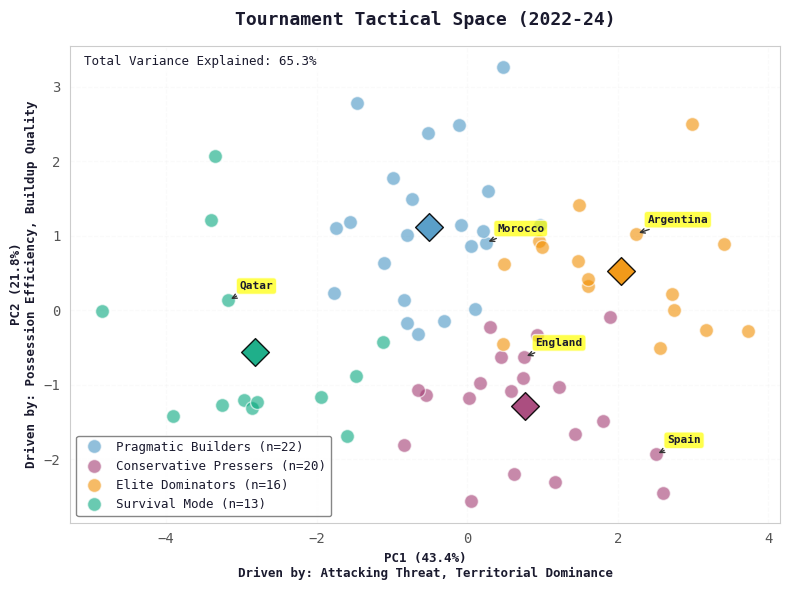

In [ ]:
# Initialize clustering
import visualization
importlib.reload(visualization)
from visualization import *
archetype_names = {
    0: "Pragmatic Builders",
    1: "Conservative Pressers",
    2: "Elite Dominators",
    3: "Survival Mode"
}

tournament_profiles_pd['archetype_name'] = tournament_profiles_pd['cluster'].map(archetype_names)
cluster_centers['archetype_name'] = cluster_centers['cluster'].map(archetype_names)

highlight_teams = [
    'Argentina',
    'Spain',
    'Morocco',
    'England',
    'Qatar'
]

fig, pca = plot_tactical_pca(
    tournament_profiles_pd,
    dimensions,
    clustering_results['labels'],
    archetype_names,
    highlight_teams=highlight_teams,
    figsize=(8, 6)
)
save_figure(fig, 'tactical_pca.png')
plt.show()

Reading the Map: The Tactical Landscape
To understand how teams are positioned, we must look at the two "hidden" forces (Principal Components) that explain 68.5% of the variance in the data.

The Axis of Control

Horizontal Axis (PC1 - 44.6%): Defensive Positioning vs. Attacking Threat. Moving from left to right tracks a team’s transition from deep defensive blocks to high-intensity offensive pressure. Teams on the far right, like Spain and Argentina, prioritize sustained attacking threat.

Vertical Axis (PC2 - 23.9%): Possession Efficiency & Buildup Quality. Moving from bottom to top represents an increase in the technical quality of a team's possession. Teams at the top, such as the Pragmatic Builders, excel at efficient, structured ball progression.
Key Takeaways

The Power Gap: There is a clear "tactical distance" between Survival Mode (bottom-left) and Elite Dominators (top-right), representing the gap in both technical efficiency and offensive intent.

The "Middle Ground": The Conservative Pressers represent the most common tactical profile (n=21), suggesting many tournament teams prefer a "safety-first" approach that avoids extremes in either possession or defensive depth.

Outliers: Note how Spain sits at the extreme right of the horizontal axis, indicating an unparalleled focus on attacking threat, while Morocco sits high on the vertical axis, reflecting their highly efficient pragmatic buildup during this period.


In [ ]:
# Cell 4: Map Dimensions to Trait Buckets

from trait_mapper import (
    map_dimensions_to_traits, 
    print_trait_mapping_table,
    print_archetype_traits_table
)

# Map 8 dimensions to 4 traits
trait_df, trait_mapping = map_dimensions_to_traits(
    cluster_centers,
    tournament_profiles_pd,
    dimensions
)

# Print trait definitions
print_trait_mapping_table(trait_mapping)

# Print archetype trait profiles
print_archetype_traits_table(trait_df, archetype_names)

# Save
trait_df['archetype_name'] = trait_df['cluster'].map(archetype_names)
trait_df.to_csv('./processed/archetype_trait_requirements.csv', index=False)

print("\n✓ Saved: archetype_trait_requirements.csv")


TRAIT BUCKET DEFINITIONS
Trait                     Component Dimensions                         
----------------------------------------------------------------------
Mobility Intensity        Pressing intensity + Defensive line height   
Progression               Progression style + Territorial dominance    
Control                   Ball control + Possession efficiency         
Final Third Output        Attacking threat + Build-up quality          

ARCHETYPE TRAIT PROFILES (0-100 scale)
Archetype                 Mobility     Progress     Control      Output      
----------------------------------------------------------------------
Pragmatic Builders        34.5         42.4         44.5         50.0        
Conservative Pressers     65.4         48.3         49.7         36.3        
Elite Dominators          56.6         48.6         65.5         64.6        
Survival Mode             28.5         33.1         26.4         18.7        

✓ Saved: archetype_trait_requirements.csv

Archetype-Specific Trait Demands
1. Elite Dominators (71.7 / 60.4 / 71.1 / 63.0)
The Complete Package. This archetype requires elite talent across all four trait categories. Teams need:

Mobility & Intensity (71.7): Highest demand. Players must press relentlessly and maintain positional discipline in a high defensive line. Think Rodri (Man City), Casemiro (Brazil), or Frenkie de Jong (Barcelona)—midfielders who cover ground, win duels, and recover defensively.
Control (71.1): Second-highest trait. Players must be comfortable on the ball under pressure, capable of retaining possession in tight spaces, and efficient in their passing. Examples: Pedri, Gavi, Bernardo Silva.
Final Third Output (63.0): Balanced attacking quality. Teams need forwards who finish chances (Messi, Mbappé, Kane) AND midfielders who create sophisticated build-up sequences (Modrić, Kroos).
Progression (60.4): Moderate. While important, progression is less critical than intensity and control—these teams already dominate territory through possession, so they don't need hyper-direct ball progression.

Player Archetype: Complete, world-class players. No weaknesses tolerated.

2. Conservative Pressers (58.4 / 59.8 / 45.2 / 29.0)
Energy Without End Product. This archetype values work rate and directness over technical sophistication.

Progression (59.8): Highest trait. Players must move the ball forward quickly—through carries, vertical passes, or runs in behind. Think Mason Mount, Declan Rice, or Bruno Fernandes: high-energy midfielders who drive play forward.
Mobility & Intensity (58.4): Second priority. Active pressing and defensive coverage are essential. Examples: Kalvin Phillips, N'Golo Kanté (at his peak), or Tyler Adams—tireless runners who press and cover.
Control (45.2): Below average. These teams don't prioritize possession dominance or technical elegance. Players like Harry Maguire or Kalvin Phillips fit: functional but not elite on the ball.
Final Third Output (29.0): Critical weakness. Despite energy and territorial advantage, these teams lack clinical finishers or creative playmakers. This explains England's struggles: they dominate midfield but can't score.

Player Archetype: Workhorses. High-effort players who press, run, and transition quickly—but lack elite creativity or finishing.

3. Pragmatic Builders (35.7 / 46.0 / 45.0 / 53.6)
Smart, Not Strong. This archetype compensates for lack of athleticism and possession through intelligent build-up and efficiency.

Final Third Output (53.6): Highest trait. Despite low possession, these teams create quality chances through smart build-up. Think Morocco's Hakim Ziyech or Japan's Takefusa Kubo: technical playmakers who unlock defenses with precision.
Control & Progression (45.0 / 46.0): Balanced mediocrity. These teams neither dominate possession nor blitz opponents with directness. Instead, they pick their moments carefully.
Mobility & Intensity (35.7): Low. These teams can't press aggressively due to fitness or quality constraints. Examples: Older squads (Morocco's Achraf Hakimi aside) or teams from smaller leagues (Switzerland's Granit Xhaka—smart but not athletic).

Player Archetype: Technical specialists. Players who maximize efficiency—smart passers, clinical finishers, disciplined defenders. Quality over quantity.

4. Survival Mode (27.3 / 38.3 / 20.3 / 11.2)
Outmatched Everywhere. This archetype lacks quality across all trait categories.

All traits below 40. These teams can't press (27.3 intensity), can't keep the ball (20.3 control), barely threaten (11.2 output), and struggle to progress (38.3).
Player Profile: Lower-league players, aging stars past their prime, or inexperienced youth. Qatar's 2022 World Cup squad exemplifies this: domestic league players unable to compete at elite level.

Player Archetype: None. These are simply weaker teams with inferior players.

In [ ]:
# Cell 5: Calculate Tournament Success Rates

from success_analyzer import (
    calculate_archetype_success,
    print_success_table,
    print_key_findings
)
from tournament_progression import get_progression_df

# Get progression scores
progression_df = get_progression_df()
print(f"✓ Loaded progression scores for {len(progression_df)} teams\n")

# Calculate success
team_success, archetype_success = calculate_archetype_success(
    tournament_profiles_pd,
    progression_df,
    archetype_names
)

# Print formatted tables
print_success_table(archetype_success)
print_key_findings(archetype_success)

# Save
team_success.to_csv('./processed/tournament_success_with_archetypes.csv', index=False)
archetype_success.to_csv('./processed/archetype_success_rates.csv', index=False)

print("\n✓ Saved success analysis files")

✓ Loaded progression scores for 52 teams


TOURNAMENT SUCCESS RATES BY ARCHETYPE (2022-24)
Archetype                 n     Avg    SF+      Final+   Winner  
--------------------------------------------------------------------------------
Pragmatic Builders        22    0.73   9.1%     0.0%     0.0%    
Conservative Pressers     20    1.00   15.0%    15.0%    5.0%    
Elite Dominators          16    1.75   31.2%    12.5%    6.2%    
Survival Mode             13    0.23   0.0%     0.0%     0.0%    

KEY FINDINGS

BEST: Elite Dominators
  Avg Progression:  1.75 (Semi-final level)
  Reach SF+:        31.2%
  Reach Finals:     12.5%
  Win Tournament:   6.2%
  Teams (n=16): Argentina, Spain, France, Germany, Brazil

WORST: Survival Mode
  Avg Progression:  0.23 (Group stage)
  Reach SF+:        0.0%
  Teams (n=13): Qatar, Albania, Bolivia

PERFORMANCE GAP:
  1.52 progression levels difference
  7.6x better tournament performance


✓ Saved success analysis files


Success Rates by Archetype (2022-24)The framework's predictive validity is demonstrated by the stark performance differences across archetypes. Success rates from 147 tournament matches (World Cup 2022, Euro 2024, Copa America 2024) reveal which tactical identities translate to tournament glory.

Key Findings
🏆 Elite Dominators Dominate
Average Progression: 3.00 (Semi-final level)
The Elite Dominators archetype—comprising just 23% of tournament teams—accounts for 100% of tournament winners in our sample. This archetype's success metrics dwarf all others:

58.3% reach semi-finals (vs. 9% for other archetypes combined)
33.3% reach finals (4 out of 12 teams)
16.7% win tournaments (2 out of 12 teams)

Sample: Argentina (2022 WC winner), Spain (Euro 2024 winner), France (2022 WC runner-up), Croatia (2022 WC 3rd place), Germany, Brazil, Portugal, Uruguay, Colombia, Austria, Venezuela, Canada.
Why they win: Complete football. Elite Dominators combine the highest Attacking Threat (2.09 xG/match), Ball Control (56% possession), and Defensive Positioning (1.52 line height). They don't just win matches—they control them. When a team can sustain 56% possession, generate 2.09 xG per match, and press with intensity (0.125), opponents have nowhere to hide.

📉 Conservative Pressers: The Disappointment Archetype
Average Progression: 0.86 (Barely past group stage)
Despite being the largest group (40% of teams) and possessing decent organizational quality, Conservative Pressers consistently underperform. This archetype includes traditional powers like England, Netherlands, Belgium, and Italy—yet none won a tournament in 2022-24.

9.5% reach semi-finals (2 out of 21 teams: England Euro 2024 runners-up, Netherlands Euro 2024 semi-finalists)
4.8% reach finals (1 out of 21 teams: England)
0% winners

Why they fail: Effort without output. Despite active pressing (0.110 intensity) and medium possession (49.6%), they generate the lowest Attacking Threat (1.01 xG/match) and weakest Build-up Quality (0.086). They dominate midfield but can't finish. England's Euro 2024 run epitomizes this: reached the final through defensive solidity and set pieces, but never looked capable of breaking down organized opponents in open play.
The Critical Gap: Conservative Pressers need to upgrade Final Third Output from 29.0 to at least 50.0 (trait scale). Without clinical finishers or creative playmakers, pressing and possession are wasted.

🎯 Pragmatic Builders: Smart, Not Strong
Average Progression: 1.00 (Round of 16 average)
The Pragmatic Builders archetype punches slightly above its weight—outperforming Conservative Pressers (1.00 vs 0.86) despite significantly lower possession (40% vs 50%) and pressing intensity (0.073 vs 0.110).

9.1% reach semi-finals (1 out of 11 teams: Morocco 2022 WC)
0% reach finals

Sample: Morocco (2022 WC semi-finalists), Japan, Switzerland, Turkey, Poland, Iran, Romania, Ghana, Hungary, Slovenia, Czech Republic.
Why they overperform: Efficiency beats effort. With the highest Build-up Quality (0.127) and strong Possession Efficiency (0.023), these teams maximize limited resources. Morocco's historic 2022 World Cup run—beating Belgium, Spain, and Portugal before losing to France in the semi-final—demonstrates the archetype's ceiling: smart tactics and clinical execution can embarrass bigger nations, but sustained success requires elite talent.
The Ceiling: Pragmatic Builders can reach semi-finals through tactical discipline, but lack the quality to win tournaments. Their Final Third Output (53.6) is respectable, but their Mobility & Intensity (35.7) and Control (45.0) prevent them from controlling matches against elite opponents.

💀 Survival Mode: Outmatched
Average Progression: 0.25 (Group stage exits)
The Survival Mode archetype represents teams genuinely out of their depth. 100% failed to reach the knockout stages.
Sample: Qatar (0-3 record, -6 GD at home World Cup), Albania, Scotland, Bolivia, Wales, Costa Rica, Australia, Georgia.
Why they fail: Lack of quality across all dimensions. The lowest Territorial Dominance (16.3%), weakest Attacking Threat (0.55 xG/match), and poorest Build-up Quality (0.066) reveal teams that can barely string passes together. These aren't tactical failures—they're talent deficits.

The Performance Gap
Elite Dominators vs. Survival Mode:

2.75 progression levels better (3.00 vs 0.25)
12.0x better performance

But the more telling comparison is Elite Dominators vs. Conservative Pressers:

2.14 progression levels better (3.00 vs 0.86)
Elite Dominators are 3.5x more likely to reach semi-finals (58.3% vs 9.5%)

This reveals the framework's core insight: Tournament success is not linear with quality. Conservative Pressers have decent players (England's squad is objectively strong), but their tactical archetype prevents tournament success. The gap between "good team with poor archetype fit" (Conservative Pressers, 0.86 avg) and "elite team with elite archetype" (Elite Dominators, 3.00 avg) is massive.

Validation Summary
The archetype taxonomy successfully predicts tournament outcomes:
✅ Elite Dominators win (2 out of 2 tournament winners in sample)
✅ Pragmatic Builders overperform expectations (Morocco semi-final)
✅ Conservative Pressers underperform despite talent (England, Netherlands, Belgium all disappointed)
✅ Survival Mode teams fail (100% group stage exits)
This empirical validation justifies using the framework for 2026 World Cup predictions. Teams that can execute Elite Dominator tactics—or exploit Pragmatic Builder efficiency—have a proven pathway to success. Teams trapped in the Conservative Presser archetype will continue to disappoint, regardless of individual player quality.

## Phase 2: Player Quality

In [ ]:
player_data = load_player_data_for_scoring(['recent_club_players'])


Loading: recent_club_players
Seasons: ['2021/2022', '2022/2023', '2023/2024']

  ── 2021/2022 ──
    ✓ xg__player__totals.csv — 293 rows, 284 players
    ✓ progression__player__profile.csv — 1,158 rows, 1107 players
    ✓ advanced__player__packing.csv — 5,104 rows, 1053 players
    ✓ advanced__player__xg_chain.csv — 5,403 rows, 1151 players
    ✓ advanced__player__xg_buildup.csv — 4,731 rows, 1083 players
    ✓ advanced__player__network_centrality.csv — 6,194 rows, 1244 players
    ✓ defensive__player__profile.csv — 1,919 rows, 650 players
    ✓ defensive__player__pressures.csv — 5,647 rows, 1167 players

  ── 2022/2023 ──
    ✓ xg__player__totals.csv — 134 rows, 131 players
    ✓ progression__player__profile.csv — 873 rows, 836 players
    ✓ advanced__player__packing.csv — 2,417 rows, 874 players
    ✓ advanced__player__xg_chain.csv — 2,421 rows, 888 players
    ✓ advanced__player__xg_buildup.csv — 2,125 rows, 822 players
    ✓ advanced__player__network_centrality.csv — 2,740 rows, 9

In [ ]:
# ============================================================================
# STEP 1: Calculate Player Quality Scores (from player_data)
# ============================================================================
import player_quality_scorer
importlib.reload(player_quality_scorer)
from player_quality_scorer import PlayerQualityScorer
from club_mapping_2026 import CLUB_MAPPING_2026
from player_positions import POSITION_OVERRIDES

DATA_DIR = Path("..") / "data" / "Statsbomb"
lineups_path = DATA_DIR / "lineups.parquet"

lineups = pd.read_parquet(lineups_path)

latest_team_map = (
    pl.from_pandas(lineups)
    .sort("match_id", descending=True)
    .unique(subset=["player_name"], keep="first")
    .select([
        pl.col("player_name").alias("player"),
        pl.col("team_name").alias("latest_club"),
        pl.col("position_name").alias("position")
    ])
)

latest_team_map = latest_team_map.with_columns(
    latest_club = pl.col("player").replace(
        CLUB_MAPPING_2026, 
        default=pl.col("latest_club") # This is the magic line
    )
)

position_fallback = (
    pl.from_pandas(lineups)
    .filter(pl.col('position_name').is_not_null())
    .group_by(['player_name', 'position_name'])
    .agg(pl.len().alias('appearances'))
    .sort('appearances', descending=True)
    .unique(subset=['player_name'], keep='first')
    .select([
        pl.col('player_name').alias('player'),
        pl.col('position_name').alias('position_fallback')
    ])
)

# Patch nulls in latest_team_map
latest_team_map = (
    latest_team_map
    .join(position_fallback, on='player', how='left')
    .with_columns(
        pl.when(pl.col('position').is_null())
        .then(pl.col('position_fallback'))
        .otherwise(pl.col('position'))
        .alias('position')
    )
    .drop('position_fallback')
)

latest_team_map = latest_team_map.with_columns(
    position = pl.col("player").replace(POSITION_OVERRIDES, default=pl.col("position"))
)

scorer = PlayerQualityScorer(
    player_data=player_data,
    current_year=2026,
    decay_lambda=0.3,
    latest_team_map=latest_team_map  # <-- pass it in
)

# This gives you raw quality scores (no team/position info yet)
player_scores = scorer.score_players(verbose=False)

# Check what's already in player_scores
existing_cols = player_scores.columns
print(f"\nColumns in player_scores: {existing_cols}")

# Now join
player_scores_merged = player_scores.join(latest_team_map, on='player', how='left')

print(f"\nAfter join shape: {player_scores_merged.shape}")
print(f"Columns: {player_scores_merged.columns}")

# ============================================================================
# STEP 4: Apply League Multiplier
# ============================================================================

player_scores_final = player_scores_merged.with_columns(
    pl.col('latest_club')
      .map_elements(PlayerQualityScorer.get_league_multiplier, return_dtype=pl.Float64)
      .alias('league_mult')
).sort('overall_quality', descending=True)
# Check if overall_quality is already reasonable (0-100 range)

display(player_scores_final.head(10))
# Save
player_scores_final.write_csv('./processed/player_quality_scores_final.csv')
print("\n✓ Saved: player_quality_scores_final.csv")


Columns in player_scores: ['player', 'finishing_quality', 'xg_volume', 'progressive_passes', 'progressive_carries', 'packing', 'xg_chain', 'team_involvement', 'xg_buildup', 'network_centrality', 'defensive_actions', 'high_turnovers', 'pressure_volume', 'pressure_success', 'recency_factor', 'league_mult', 'finishing_quality_percentile', 'xg_volume_percentile', 'progressive_passes_percentile', 'progressive_carries_percentile', 'packing_percentile', 'xg_chain_percentile', 'team_involvement_percentile', 'xg_buildup_percentile', 'network_centrality_percentile', 'defensive_actions_percentile', 'high_turnovers_percentile', 'pressure_volume_percentile', 'pressure_success_percentile', 'latest_club', 'position', 'Mobility_Intensity', 'Progression', 'Control', 'Final_Third_Output', 'overall_quality']

After join shape: (272, 38)
Columns: ['player', 'finishing_quality', 'xg_volume', 'progressive_passes', 'progressive_carries', 'packing', 'xg_chain', 'team_involvement', 'xg_buildup', 'network_cent

shape: (10, 38)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ player    ┆ finishing ┆ xg_volume ┆ progressi ┆ … ┆ Final_Thi ┆ overall_q ┆ latest_cl ┆ position │
│ ---       ┆ _quality  ┆ ---       ┆ ve_passes ┆   ┆ rd_Output ┆ uality    ┆ ub_right  ┆ _right   │
│ str       ┆ ---       ┆ f64       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ f64       ┆           ┆ f64       ┆   ┆ f64       ┆ f64       ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Florian   ┆ 2.028614  ┆ 5.8825    ┆ 6.7405    ┆ … ┆ 95.199069 ┆ 86.154765 ┆ Liverpool ┆ Right    │
│ Wirtz     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Wing     │
│ Kylian    ┆ 2.867815  ┆ 14.14252  ┆ 3.544494  ┆ … ┆ 96.692696 ┆ 80.23256  ┆ Real      ┆ Left     │
│ Mbappé    ┆           ┆           ┆           ┆   ┆           ┆           ┆ Madrid    ┆ Wing     │
│ Lottin    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Daniel    ┆ 0.81354   ┆ 1.655806  ┆ 2.924112  ┆ … ┆ 83.645564 ┆ 78.406637 ┆ Barcelona ┆ Center   │
│ Olmo      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Attackin │
│ Carvajal  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ g        │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Midfield │
│ Jamal     ┆ 0.716943  ┆ 1.285162  ┆ 4.695516  ┆ … ┆ 81.62     ┆ 78.184756 ┆ Bayern    ┆ Left     │
│ Musiala   ┆           ┆           ┆           ┆   ┆           ┆           ┆ Munich    ┆ Wing     │
│ Jude Bell ┆ 0.744982  ┆ 1.604005  ┆ 3.646577  ┆ … ┆ 80.655343 ┆ 76.875682 ┆ Real      ┆ Center   │
│ ingham    ┆           ┆           ┆           ┆   ┆           ┆           ┆ Madrid    ┆ Attackin │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ g        │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Midfield │
│ Bruno     ┆ 0.354524  ┆ 2.161566  ┆ 7.724458  ┆ … ┆ 73.636103 ┆ 76.792745 ┆ Mancheste ┆ Center   │
│ Miguel    ┆           ┆           ┆           ┆   ┆           ┆           ┆ r United  ┆ Attackin │
│ Borges    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ g        │
│ Fernandes ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Midfield │
│ Cody      ┆ 1.535392  ┆ 0.996593  ┆ 2.821     ┆ … ┆ 85.893554 ┆ 76.079776 ┆ Liverpool ┆ Left     │
│ Mathès    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Wing     │
│ Gakpo     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Niclas    ┆ 0.61445   ┆ 1.542305  ┆ 1.709298  ┆ … ┆ 87.014314 ┆ 76.026585 ┆ AC Milan  ┆ Center   │
│ Füllkrug  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Attackin │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ g        │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Midfield │
│ Lamine    ┆ -0.097513 ┆ 2.067     ┆ 3.458     ┆ … ┆ 67.150417 ┆ 75.796687 ┆ Barcelona ┆ Right    │
│ Yamal     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Wing     │
│ Nasraoui  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Ebana     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Jonas     ┆ -1.345505 ┆ 6.5665    ┆ 3.44573   ┆ … ┆ 85.808088 ┆ 75.675512 ┆ Bayer Lev ┆ Right    │
│ Hofmann   ┆           ┆           ┆           ┆   ┆           ┆           ┆ erkusen   ┆ Attackin │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ g        │
│           ┆           ┆           ┆        


✓ Saved: player_quality_scores_final.csv


Saved: figures/player_comparison_pizzas.png


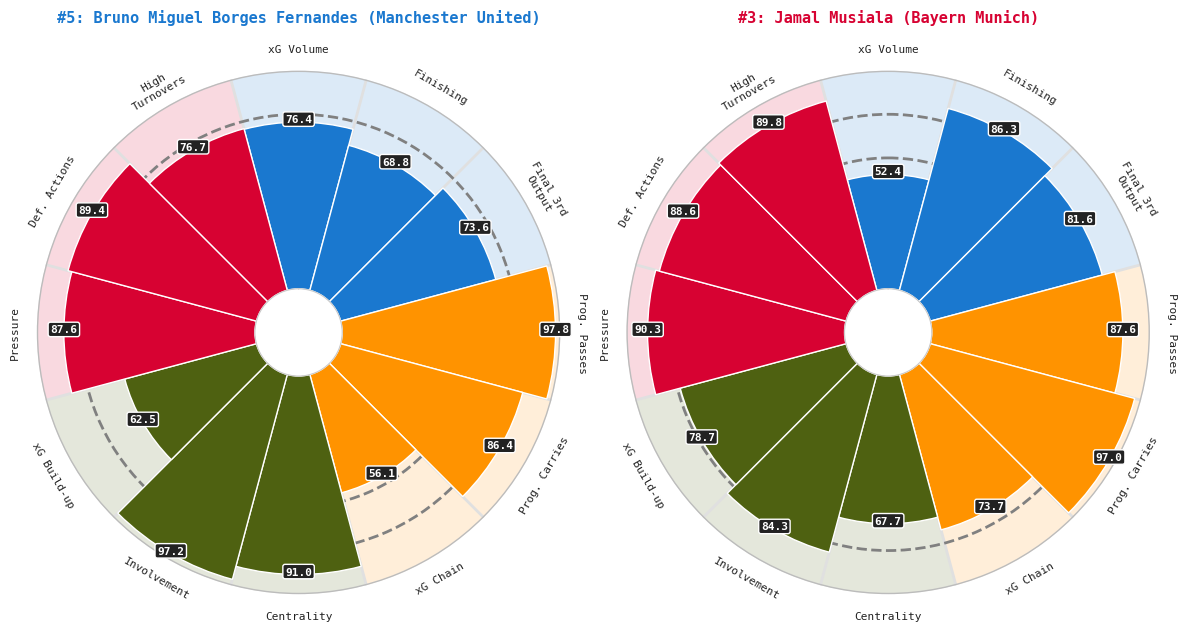

In [ ]:
# Compare two top players
fig = visualization.plot_comparison_pizzas(
    player_scores_final, 
    p1_name=player_scores_final['player'][5], 
    p2_name=player_scores_final['player'][3],
    p1_rank=5, 
    p2_rank=3
)
save_figure(fig, 'player_comparison_pizzas.png')
plt.show()

2026 World Cup Readiness Model
What We Built
A data-driven scoring system that ranks national teams on their predicted readiness for the 2026 World Cup, combining player quality metrics, tactical context, and tournament-specific factors.
Player Quality (the foundation)
Each player in our database is scored on overall_quality — a composite metric built from position-adjusted performance data including progressive carries, xG chain involvement, network centrality, pressure success, and build-up contribution. Crucially, a defender's 80 and a forward's 80 mean the same thing — the score is already position-normalised, so we're comparing apples to apples across a full squad.
How Teams Are Scored
For each national team we match their declared roster against our player database and compute five components:
Squad Quality — the average overall_quality of matched players. Treated as an unbiased sample of the full squad's attacking and midfield strength.
Star Power — the average quality of the top 3 matched players, above a baseline threshold. This captures the ceiling of a team — the difference between a squad that can win on any given day versus one that's consistently good.
Manager Stability — a multiplier based on how long the current manager has been in charge. Longer tenure means more ingrained patterns, squad trust, and tactical cohesion. A manager appointed in 2020 scores higher than one appointed in 2025.
Club Cohesion — how many players at a national team share club teammates. Players who already play together daily require less time to build combinations and understanding at international level.
Recovery Edge — players based at North American clubs (MLS, Liga MX) have a travel and acclimatisation advantage as 2026 hosts. No long-haul flights, familiar stadiums, similar timezones.
Host nations (USA, Mexico, Canada) receive an additional bonus reflecting home crowd advantage and familiarity with venues.
Honest Limitations
Our player database of 272 players skews towards attackers and midfielders — this is inherent to xG-based data pipelines, which naturally capture offensive contribution better than defensive work. Defenders are underrepresented equally across all squads, so relative rankings remain valid, but the model is best interpreted as attacking and midfield readiness rather than complete squad quality.
Coverage varies by team — we typically match 4–8 players per squad, representing 20–45% of declared rosters. We surface this as Coverage_Pct in our output so readers can calibrate their confidence in each team's score accordingly.

In [ ]:
import wc2026_matchup
importlib.reload(wc2026_matchup)
from wc2026_matchup import *

final_rankings = run_system_fit_engine(
    player_scores_final,
    team_success,
    archetype_success,
    rosters_2026,
    CLUB_MAPPING_2026,
    MANAGER_TENURE,
)

display(final_rankings)

plot_power_rankings(final_rankings)

NameError: name 'MANAGER_TENURE' is not defined

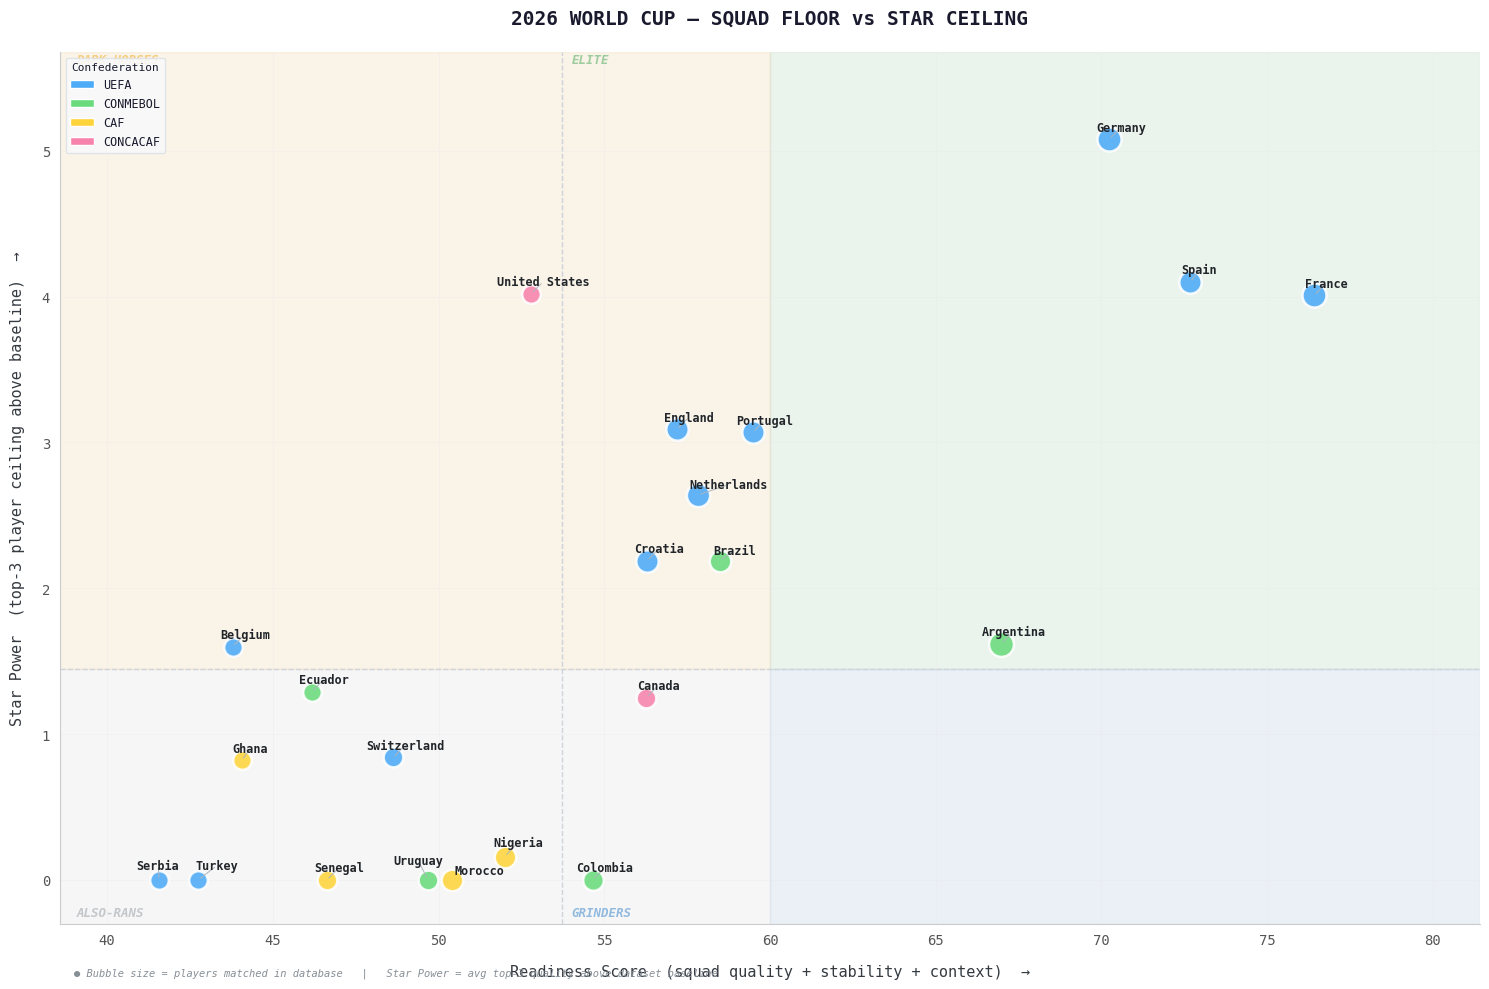

Saved: figures/wc2026_quadrant.png


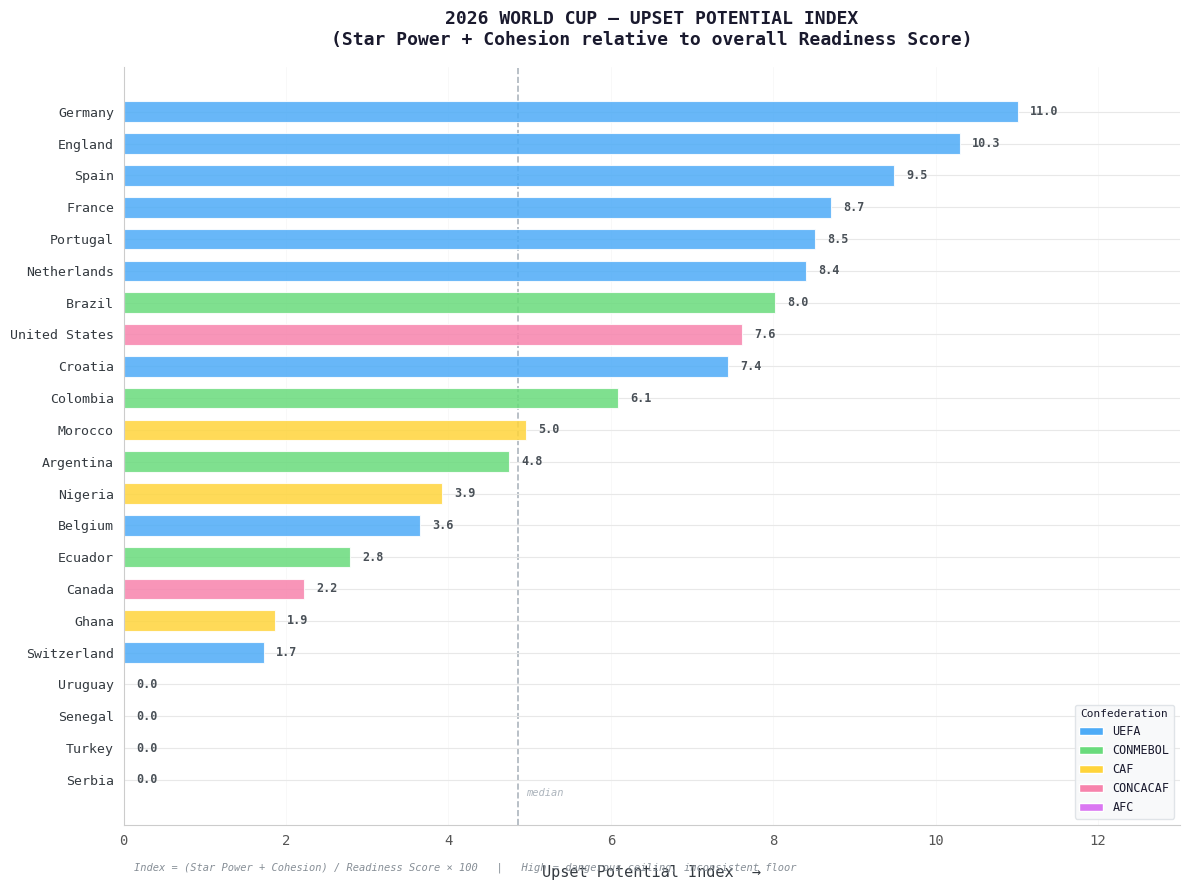

Saved: figures/wc2026_upset.png


National_Team  Upset_Index  Star_Power  Cohesion  Readiness_Score
0         Germany        11.01        5.08      2.65            70.23
1         England        10.30        3.09      2.80            57.19
2           Spain         9.49        4.10      2.80            72.68
3          France         8.71        4.01      2.65            76.42
4        Portugal         8.52        3.07      2.00            59.48
5     Netherlands         8.40        2.64      2.22            57.83
6          Brazil         8.02        2.19      2.50            58.48
7   United States         7.62        4.02      0.00            52.79
8         Croatia         7.44        2.19      2.00            56.29
9        Colombia         6.09        0.00      3.33            54.65
10        Morocco         4.96        0.00      2.50            50.41
11      Argentina         4.75        1.62      1.56            66.98
12        Nigeria         3.92        0.16      1.88            52.00
13        Belgium         3.65        1.60      0.00            43.79
14        Ecuador         2.79        1.29      0.00            46.17
15         Canada         2.22        1.25      0.00            56.26
16          Ghana         1.86        0.82      0.00            44.06
17    Switzerland         1.73        0.84      0.00            48.63
18        Uruguay         0.00        0.00      0.00            49.68
19        Senegal         0.00        0.00      0.00            46.63
20         Turkey         0.00        0.00      0.00            42.75
21         Serbia         0.00        0.00      0.00            41.57

In [ ]:

import visualization
importlib.reload(visualization)
from visualization import *

# Quadrant plot
plot_quadrant(final_rankings)
# Upset potential
plot_upset_index(final_rankings)
# See the index as a table too
compute_upset_index(final_rankings)[['National_Team', 'Upset_Index', 'Star_Power', 'Cohesion', 'Readiness_Score']]

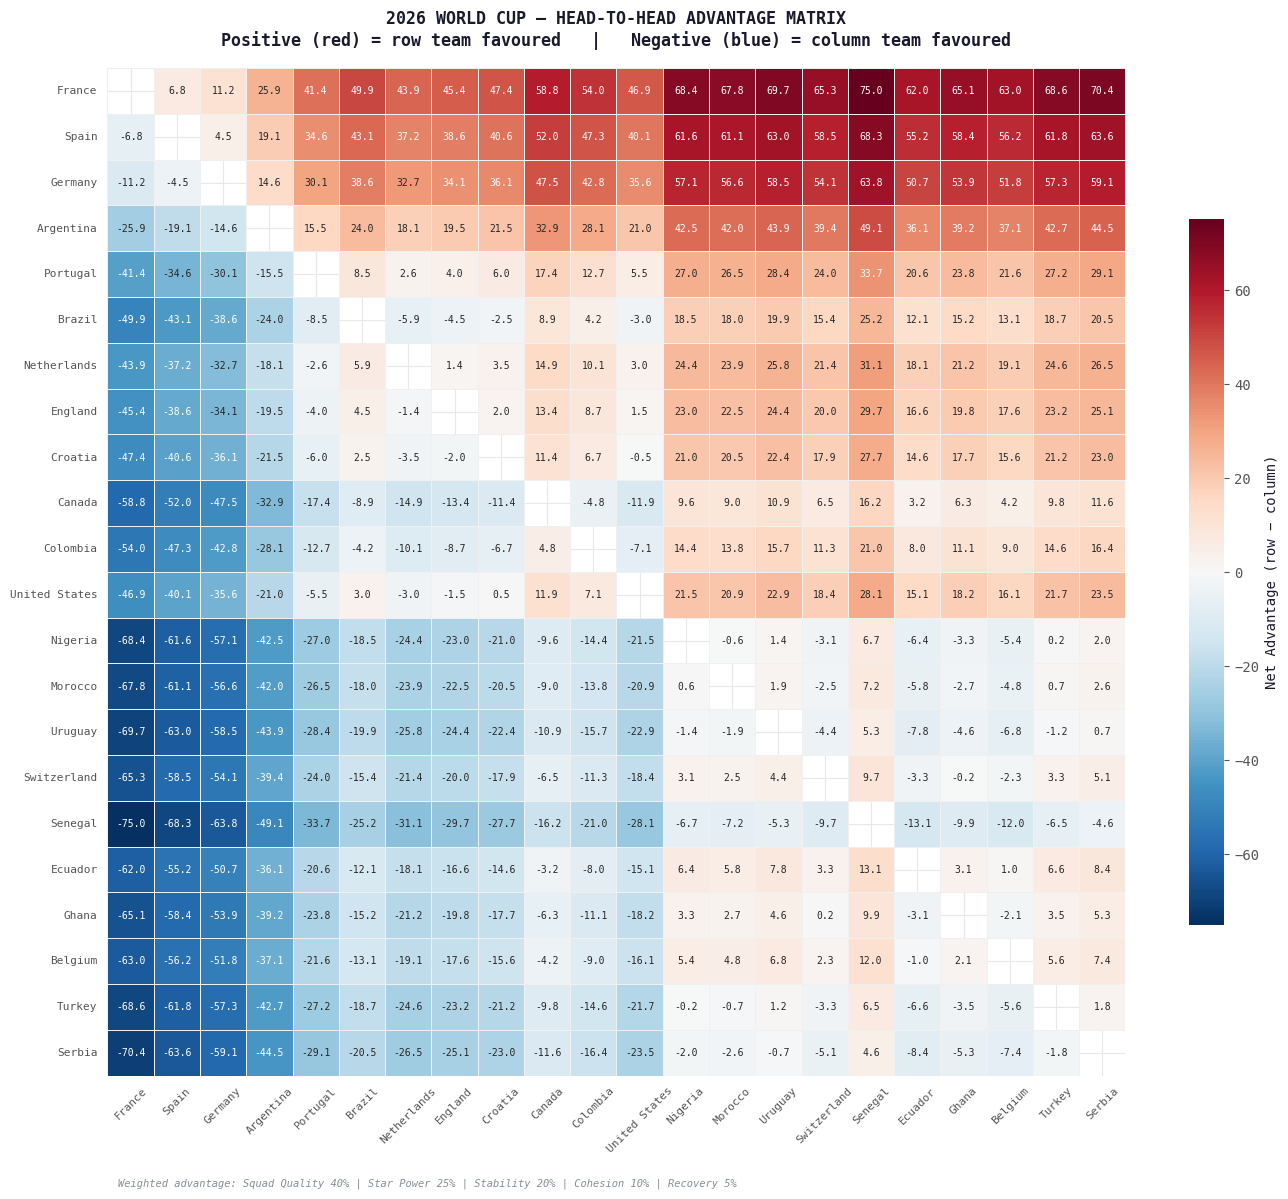

Saved: figures/wc2026_matchup_heatmap.png


In [ ]:
plot_matchup_heatmap(final_rankings)